<a href="https://colab.research.google.com/github/chenmargalit/Basicsc-to-STOA/blob/master/Basics_to_STOA_latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basics to STOA on images classification

This notebook is based on the wonderful fastai foundations course. Its aim is to teach everything we need for a STOA classification computer vision model, from scratch. We will use Pytorch only after we've implemented the functionallity ourselves. from scratch.

### Matrix multiplication

In [0]:
import operator

In [0]:
TEST = 'test'

In [0]:
# testing functions to help debugging

def test(a, b, cmp, cname=None):
    if cname is None:
        cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}\n{'problem is with these two above'}"

def test_eq(a,b):
    test(a, b, operator.eq, '==')
        

In [0]:
# Uncomment if neeed
# !pip3 install fastai

In [0]:
# check to see the tests are working. Change 'test' to anything else to see how it works.
test_eq(TEST, 'test')

In [0]:
# convenience to download mnist dataset 
from fastai import datasets 
import gzip, pickle
from torch import tensor
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
from torch import tensor
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [0]:
# get mnist
path = datasets.download_data(MNIST_URL, ext='.gz')
path

PosixPath('/root/.fastai/data/mnist.pkl.gz')

In [0]:
# split into train/validation
with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')


In [0]:
# train set 50k, validation - 10k
len(x_train), len(y_train), len(x_valid), len(y_valid)

(50000, 50000, 10000, 10000)

In [0]:
# # starts as a numpy array
type(x_train)

numpy.ndarray

In [0]:


# convert to tensors
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))
type(x_train)

torch.Tensor

In [0]:
# Each image is currently built out of 784 pixel numbers.
n,c = x_train.shape
n, c

(50000, 784)

In [0]:
# y train values are between 0 and 9
y_train.min(), y_train.max()

(tensor(0), tensor(9))

In [0]:
# images in mnist are one rank arrays, meaning black and white 
mpl.rcParams['image.cmap'] = 'gray'

In [0]:
# take the first image
img = x_train[2]

In [0]:
# make sure the size (784), fits to 28 * 28
test_eq(c, 28 * 28)

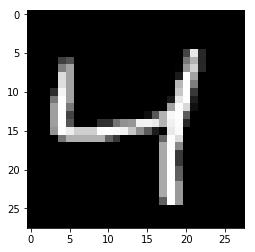

In [0]:
# change image from a 784 vector to a 28*28 matrix and use matplotlib to show it
plt.imshow(img.view(28,28))

In [0]:
# initialize with random weights and bias. * we will later find out this random initializing is quite a bad idea
# but more to come on that later
weights = torch.randn(784, 10)
bias = torch.zeros(10)

In [0]:
# regular matrix multipication. For every of left matrix, for every coloumn of right matrix, multiplie and add
# every intersection. for better visualization, see here http://matrixmultiplication.xyz/

def matmul1(a,b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                c[i,j] += a[i,k] * b[k,j]
    return c

In [0]:
# we're going to multiplie the 5 first images in validation set with the random weights we gathered
m1 = x_valid[:5]
m2 = weights

In [0]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [0]:
# make sure left matrix's columns fit right matrix's rows so multiplication is possible
assert m1.shape[1] == m2.shape[0]

In [0]:
# 5 pics took 521 ms. One epoch (with barely doing anything) would take 17 days. Lets make this faster
%time t1 = matmul1(m1, m2)

CPU times: user 886 ms, sys: 832 µs, total: 887 ms
Wall time: 901 ms


In [0]:
%timeit -n 10 _=matmul1(m1, m2) #this takes too much time. Disable it

10 loops, best of 3: 845 ms per loop


In [0]:
t1.shape

torch.Size([5, 10])

if a 5 images matrix calculation (which doesn't do much anyway) takes 500 ms, that's about 4 days, for basically doing something which is not too useful. We want to do things faster, the way we would do that, is basically not use Python (as its too slow). We will write python, but the calculation will be done in C++.

So the way we do this, is using pytorch's element-wise operations which will behind the scences use the Aten C++ library. https://pytorch.org/cppdocs/

So this 1 line change will make things much faster. Instead of going through every intersection and adding it, we will multiplie the entire column with the entire row, and only then sum it together. 

In [0]:
def matmul2(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            # only different part from our previous loop. * the : after a[i] is redundant, only here for making
            # things clearer
            c[i,j] = (a[i,:] * b[:,j]).sum()
    return c

In [0]:
%time t2 = matmul2(m1, m2)

CPU times: user 2.94 ms, sys: 28 µs, total: 2.96 ms
Wall time: 23.5 ms


In [0]:
%timeit -n 10 _=matmul2(m1, m2)

10 loops, best of 3: 1.44 ms per loop


Apperantly its a good idea !

In [0]:
679/1.23 # ~500 times faster

552.0325203252032

lets make sure the results are the same

In [0]:
def near(a, b):
    return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
    
def test_near(a, b):
    return test(a, b, near)

In [0]:
test_near(t1, t2) # same thing, totally different speeds

### Broadcasting

For the user, broadcasting is basically just a way to calculate faster. It seems as if its just replacing loops, but actually it works different and much faster. 

In [0]:
a = tensor([5, -0.4, 7, -5 ])
a > 0

tensor([1, 0, 1, 0], dtype=torch.uint8)

This line above works as expected although it could seem a bit weird it does. We are checking if 0 is smaller then every one of those numbers in the a tensor, although 0 is just a scalar. The way it actually works is that 0 is being broadcasted, meaning some kind of "copied" (not really copied, memory wise) 4 times, so its actually only checking if each 0 is smaller then the respective number, we just have 4 times 0.

In [0]:
b = 0

In [0]:
a > b

tensor([1, 0, 1, 0], dtype=torch.uint8)

In [0]:
a = tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

In [0]:
b = tensor([1, 2, 3])

This is what basically happens, b behaves as if it was expanded to the size needed to handle a 3 size tensor. What actually happened is that 

In [0]:
c = b.expand_as(a)
c

tensor([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]])

In [0]:
# big enough to handle a 3 by 3 matrix, although it's supposedly only a vector
c.shape

torch.Size([3, 3])

we see c is actually stored once, not really 3 times. So how does this work ? 

In [0]:
c.storage()

 1
 2
 3
[torch.LongStorage of size 3]

b (here named "c"), is just doing a 0 sized move everytime it moves line, and a 1 size movie everytime it moves a column, so for every row, it basically just does not move

In [0]:
c.stride()

(0, 1)

In [0]:
a = tensor([3])
# one rank tensor
a.shape

torch.Size([1])

In [0]:
# Two rank tensor
a.unsqueeze(1).shape

torch.Size([1, 1])

In [0]:
a.unsqueeze(1).shape == a[None].shape == a.unsqueeze(-1).shape

True

So lets reduce everything to 1 loop, only loop through the rows in the left matrix and say: broadcast the first row in a to a 2 rank tensor so it can be multiplied with b and then sum everything on the first axis. Do this for every row in a. 

In [0]:
def matmul3(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        c[i] = (a[i].unsqueeze(-1) * b).sum(dim=0)
    return c

In [0]:
%timeit -n 10 _=matmul3(m1, m2)

10 loops, best of 3: 335 µs per loop


~ 5000 (!) times faster than the beggining

In [0]:
1.23 * 1000000/237

5189.873417721519

In [0]:
# ~ same score, different speed
test_near(t1, matmul3(m1, m2))

Let's now use something called einstein summation, a pytorch function that describes products/sums in a very short and concise way. So in our 2X2 (a X b) multiplicaiton, we have i(rows) by k(columns), times same number of columns, by some number of rows. The result is a's rows by b's columns. Exactly like any other matrix multiplication. The resulting speed, is much better

In [0]:
def matmul4(a, b):
    return torch.einsum('ik,kj->ij', a,b)

In [0]:
%timeit -n 10 _= matmul4(m1, m2)

The slowest run took 56.04 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 3: 47.4 µs per loop


In [0]:
# ~ 24,000 times faster
1.23 * 1000000/50

24600.0

In [0]:
# passes 
test_near(t1, matmul4(m1, m2))

Lastly, we will use the pytorch function matmul (also works as @) which is by far the fastest. Pytorch uses a totally different way of calculaiton, where python has to use RAM memory again and again, pytorch splits the calculation into seperate parts and so is able to do things faster. *Pytorch doesn't really do it itself, it actually uses a linear algerbra library named BLAS (some companies like Intel, Nvidia etc have their own implications for that). Bottom line - it works way faster. The down side is of course, we loose quite a lot of flexibility

In [0]:
%timeit -n 10 _ = m1.matmul(m2)

The slowest run took 22.68 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 3: 17.3 µs per loop


In [0]:
%timeit -n 10 m1@m2

The slowest run took 6.32 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 3: 17.8 µs per loop


In [0]:
# ~ 82,000 times faster than our first attempt. Not bad !
1.23 * 1000000/ 15

82000.0

## Activation function

In [0]:
# As we are going to use this dataset quite a lot, lets write a function that will grab it and convert it into tensors
def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train, y_train, x_valid, y_valid))

In [0]:
x_train, y_train, x_valid, y_valid = get_data()

In [0]:
# As we'll see pretty soon, the data has to be normalized to perform well in a Neural network. 
def normalize(x, m, s):
    return (x-m)/s

In [0]:
train_mean = x_train.mean()
train_std = x_train.std()

In [0]:
# The mean is not 1, the std is not 1, which makes sense, because there's no praticulat reason for it to be so,
# but we do want that so we'll normalize which just means substracting the mean and dividing by standard deviation.
train_mean, train_std

(tensor(0.1304), tensor(0.3073))

We want to normalize all our data the same way, so validation data is being normalized on training data. The reasons is, we can't really compare the affect of different features if they are not scaled the same, because if the training is being done on one scale, and being tested on a different. It won't do well ...

In [0]:
type(x_train)

torch.Tensor

In [0]:
x_valid.shape

torch.Size([10000, 784])

In [0]:
x_train = normalize(x_train, train_mean, train_std)
x_valid = normalize(x_valid, train_mean, train_std)

after normalization, it is 0 and 1

In [0]:
train_mean = x_train.mean()
train_std = x_train.std()

In [0]:
def test_near_zero(a, tol=1e-3):
    assert a.abs() < tol, f'Near zero {a}'

So right now our data is normalized, mean of 1, std of 0. Thats great ,let's see how it evolves through training

In [0]:
# passes
test_near_zero(x_train.mean())
test_near_zero(1-x_train.std())

In [0]:
n, m = x_train.shape
c = y_train.max() + 1
n, m, c

(50000, 784, tensor(10))

So the problem is this: we want the inputs to any layer to be with a mean o 0 and std of 1. On the first layer, mission accomplished, we have it. Problem is .. if we initialize the weights randomly, the input to the second layer, won't be like this anymore. Lets see this

In [0]:
# num of hidden
nh = 50

In [0]:
w1 = torch.randn(m, nh)
b1 = torch.zeros(nh)

In [0]:
w1.shape, b1.shape

(torch.Size([784, 50]), torch.Size([50]))

In [0]:
x_valid.shape

torch.Size([10000, 784])

In [0]:
def lin(x, w, b):
    return x@w + b

In [0]:
r1 = lin(x_valid, w1, b1)

after one linear operation, mean is -3 and std 26. Getting good results like this would be on the verge of impossible. We need to make sure the stats stay as we need them through training

In [0]:
r1.mean(), r1.std()

(tensor(1.7274), tensor(26.3374))

Let's not try putting a bit more effort (than random) in our initialization. We are going to use the a different initialization which goes like this:

In [0]:
import math

w1 = torch.randn(m, nh)/math.sqrt(m)
b1 = torch.zeros(nh)
w2 = torch.randn(nh, 1)/math.sqrt(nh)
b2 = torch.zeros(1)

Same process with the differently initiated weights, looks good. The mean is ~ 0 and the std is ~ 1

In [0]:
r2 = lin(x_valid, w1, b1)
r2.mean(), r2.std()

(tensor(-0.0807), tensor(1.0222))

But actually as we know, this one linear function won't do much good. Even the first computation is run through relu right after the linear operation, so let's define relu and activate it on the reuslt of the same linear operation

In [0]:
def relu(x):
    return x.clamp_min(0.)

In [0]:
t = relu(lin(x_valid, w1, b1))

The result of the relu operation scrooed our mean/std. this makes sense right? as the function zeros the negative parts, the mean obviously can't be zero as there is nothing to balance the positive outcomes. As we removed about average of the scores we had, the std is also about half. Main problem is, this is only after one relu operation. If we would have a deeper network, which we obviouslly have to in order to get better results, if the variance halfs every operation, then after 3 relus it's going to be 1/8 ((1/2)^3) which will zero the gradients and we wont be able to learn anything

In [0]:
t.mean(), t.std()

(tensor(0.3671), tensor(0.5580))

So the trick we used earlier was good for linear functions, but not good for relus. As suggested in this papper https://arxiv.org/pdf/1502.01852.pdf, we are going to make a small but important change

In [0]:
w1 = torch.randn(m,nh)*math.sqrt(2/m)

In [0]:
t = relu(lin(x_valid, w1, b1))

And walla, we get much better measurs. Not perfect, but much better. The only difference is multiplying the square root instead of diving, and diving the number of inputs by 2, e.g (2/m). Still we see we have an issue with the mean which as we said, is quite reasonably about 0.5. Let's try taking care of this

In [0]:
t.mean(), t.std()

(tensor(0.5414), tensor(0.8305))

Not very fancy, but if it works then it works right ?

In [0]:
def relu(x):
    return x.clamp_min(0.) - 0.5

In [0]:
w1 = torch.randn(m, nh)*math.sqrt(2./m)

In [0]:
t = relu(lin(x_valid, w1, b1))

And now we have exactly the measuresments we wanted

In [0]:
t.mean(), t.std()

(tensor(-0.0025), tensor(0.7597))

So now that we created kaming init on our own, lets use Pytorch's which is basically the same

In [0]:
from torch.nn import init

As we can see, works pretty much the same, std not TOO far from 1. 

In [0]:
w1 = torch.zeros(m, nh)
init.kaiming_normal_(w1, mode='fan_out')
t = relu(lin(x_valid, w1, b1))
t.mean(), t.std()

(tensor(0.0381), tensor(0.8201))

A weird thing is we had to specifiy fan_out here, which according to the documentation deals with backward propogation, basically it's in charge of deciding what to divide the sqrt on, m or nh. In the forward (which we do here) it's m. So why do we specity fan_out, when we're doing forward ? let's see. This is our weights shape here, 784 by 50, when we're activing our own self made linear activation, thats how it looks

In [0]:
w1.shape

torch.Size([784, 50])

When we do the allegedly same thing, this time with pytorch nn.Linear, we get a transposed result. 50 by 784, not the other way around. this is actually the reason we do fang_out instead of in. * this happens with no good reasons, just cause the pytorch code inherited some code written in Lua (Torch library converted to PYtorch for python), and Torch couldnt handle batch multiplication without transpose. It doesn't bothr performance though so its fine, just important to know

In [0]:
import torch.nn
torch.nn.Linear(m,nh).weight.shape

torch.Size([50, 784])

In [0]:
# torch.nn.functional.linear??

running the code above shows us that indeed, pytorch does a transpose, and so we need to give it "transposed" info in mode. So lets do a forward pass with 2 linear layers and a relu between ... and ... its pretty fast !

In [0]:
def model(xb):
    l1 = lin(xb, w1, b1)
    l2 = relu(l1)
    l3 = lin(l2, w2, b2)
    return l3

In [0]:
%timeit -n 10 model(x_valid)

10 loops, best of 3: 20 ms per loop


In [0]:
# passes, shapes seems to fit
assert model(x_valid).shape == torch.Size([x_valid.shape[0], 1])

Now lets continue with a loss function. We will start with mse, obviously it makes no sense to use mse for a classification problem, and we will fix it soon, but just for the practice, lets start with this

In [0]:
# our model returns a matrix of 10k by 1, for mse we will have to get rid of this 1 axis,
#which will be done with squeeze
model(x_valid).shape

torch.Size([10000, 1])

In [0]:
# lets define mse, mean of sqaure differences between target and prediction. The square helps with negatives.
def mse(output, targ):
    return (output.squeeze(1) - targ).pow(2).mean()

In [0]:
# as mse could (and probably will be) a float, we need to convert y to floats.
y_train, y_valid = y_train.float(), y_valid.float()

In [0]:
preds = model(x_train)
preds.shape

torch.Size([50000, 1])

In [0]:
# our error measurement is 29. The idea with training would be reducing this number
mse(preds, y_train)

tensor(20.6072)

Okay so so far we've got a forward pass. It doesn't do much, but its a good start. Now we know how wrong we are, not to reduce our error, we will need the backward pass. For that, we need the gradients which will tell us how to modify the weights, to get the best result. How does it work ? 

Think of a neural network like a message being believered from one person to the other, it passes 5 people and it reaches the last person which has to say what was the messsage. The accuracy between the message the first person gave (the input), and what the last person said (output) is affected by all the different moderators on the way. If we have people a, b, c, d, e. Lets assume A delivers the message perfectlly, (we did used kaiming he after all ...)
if person b, scroos up, the entire process is not going to work well. So bsaically what we're going to do is calculate the gradients with respect to the weights of each layer and multiplie it by the input of the previous layer. We are actually saying, remember the input you gave me ? next time, before you give me something, change your message according to minor twick. * We will later add a learning rate parameter for better performance but more on that later. This results not only in person c giving a better forward message on its own, he also GETS a better message because the same training process happened to the one behind

As for the chain rule (the multiplication of gradients through the entire network) we need the gradients, we are going to save every layer's gradients in inp.g where inp is actually the output of the previous layer. So mse's inp, is actually the previous layer, out. It's the same.

In [0]:
# # gradient of something squared is just 2 * something. 
def mse_grad(inp, targ): 
    # grad of loss with respect to output of previous layer
    inp.g = 2. * (inp.squeeze() - targ).unsqueeze(-1) / inp.shape[0]

In [0]:
# Relu's gradient is 0 for anything negative and 1 for anything positive so its actually just the 1 * positive part
# which here is inp > 0. Then we multiplie it by the next layer's gradients, which is here stored as out.g
# this is the tuning process we've talked about. This is by how much do I tell the previous meessanger to change 
# his message. This is a big part of how the model learns.
def relu_grad(inp, out):
    inp.g = (inp > 0).float() * out.g

This is a good place to demonstrate that what we are actually twicking is not the input (which is given before hand by the data set) but the weights that modify the input. Depending on the architechture, we want to do some operation on the data entering the model so we can understand what's going on. The weights, are the things doing those opeartions, and so thats what we change. 

In [0]:
def lin_grad(inp, out, w, b):
    # grad of matmul with respect to input
    inp.g = out.g @ w.t()
    # Here we also need the grad with respect to the weights and bias, as we will twick this as well
    w.g = (inp.unsqueeze(-1) * out.g.unsqueeze(1)).sum(0)
    b.g = out.g.sum(0)

So how does a full run look like ? We start with the forward, with calculating everything to until the loss (not included as we dont need it here). Then moving backwards, when we act on our findings, we use the gradients to twick the weights and improve the input given by the previous layer each time.

In [0]:
# def forward_and_backward(inp, targ):
#     l1 = inp @ w1 + b1
#     l2 = relu(l1)
#     out = l2 @ w2 + b2
#     # loss calculation is not needed for the calculation
#     loss = mse(out, targ)

#     # backward:
#     mse_grad(out, targ)
#     # the lin_grad takes basically the same thing lin took, just an additional out for the gradient calculation
#     lin_grad(l2, out, w2, b2)
#     relu_grad(l1, l2)
#     lin_grad(inp, l1, w1, b1)


def forward_and_backward(inp, targ):
    # forward pass:
    l1 = inp @ w1 + b1
    l2 = relu(l1)
    out = l2 @ w2 + b2
    # we don't actually need the loss in backward!
    loss = mse(out, targ)
    
    # backward pass:
    mse_grad(out, targ)
    lin_grad(l2, out, w2, b2)
    relu_grad(l1, l2)
    lin_grad(inp, l1, w1, b1)

In [0]:
forward_and_backward(x_train, y_train)

In [0]:
def forward(inp, targ):
    l1 = inp @ w1 + b1
    l2 = relu(l1)
    out = l2 @ w2 + b2
    return mse(out, targ)

In [0]:
loss = forward(x_train, y_train)
loss

tensor(20.6072)

What might seem weird here is that even after all we've done, the loss is exactly the same. So why do this backward calculation ? answer is, that we haven't finished. We calculated the measurement needed, but did not yet change the weights accordingly. We will do so very soon. This step will be part of the optimizer.

In [0]:
class Relu():
    def __call__(self, inp):
        self.inp = inp
        self.out = inp.clamp_min(0.) - 0.5
        return self.out

    def backward(self):
        self.inp.g = (self.inp > 0).float() * self.out.g    

In [0]:
class Lin():
    def __init__(self, w, b):
        self.w, self.b = w, b
        
    def __call__(self, inp):
        self.inp = inp
        self.out = inp @ self.w + self.b
        return self.out
    
    def backward(self):
        self.inp.g = self.out.g @ self.w.t()
        self.w.g = (self.inp.unsqueeze(-1) * self.out.g.unsqueeze(1)).sum(0)
        self.b.g = self.out.g.sum(0)


In [0]:
class Mse():
    def __call__(self, inp, targ):
        self.inp = inp
        self.targ = targ
        self.out = (self.inp.squeeze(1) - targ).pow(2).mean()
        return self.out

    def backward(self):
        self.inp.g = 2. * (self.inp.squeeze() - self.targ).unsqueeze(-1) / self.targ.shape[0]        

In [0]:
class Model():
    def __init__(self, w1, b1, w2, b2):
        self.layers = [Lin(w1, b1), Relu(), Lin(w2,b2)]
        self.loss = Mse()
    
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()


In [0]:
w1.g, b1.g, w2.g, b2.g = [None] * 4
model = Model(w1, b1, w2, b2)

In [0]:
%time loss = model(x_train, y_train)

CPU times: user 116 ms, sys: 1.8 ms, total: 118 ms
Wall time: 122 ms


This is generally working ok, just super slow. Lets refactor to make this faster

In [0]:
%time model.backward()

CPU times: user 4.25 s, sys: 45 ms, total: 4.29 s
Wall time: 4.31 s


In [0]:
class Module():
    def __call__(self, *args):
        self.args = args
        self.out = self.forward(*args)
        return self.out
    
    def forward(self): raise Exception('not implemented')
    def backward(self): self.bwd(self.out, *self.args)

In [0]:
class Relu(Module):
    def forward(self, inp): return inp.clamp_min(0.)-0.5
    def bwd(self, out, inp): inp.g = (inp>0).float() * out.g

In [0]:
class Lin(Module):
    def __init__(self, w, b):
        self.w = w
        self.b = b
    
    def forward(self, inp): return inp @ self.w + self.b
    
    def bwd(self, out, inp):
        inp.g = out.g @ self.w.t()
        self.w.g = inp.t() @ out.g
        self.b.g = out.g.sum(0)
    

In [0]:
class Mse(Module):
    def forward (self, inp, targ): return (inp.squeeze() - targ).pow(2).mean()
    def bwd(self, out, inp, targ): inp.g = 2*(inp.squeeze()-targ).unsqueeze(-1) / targ.shape[0]

In [0]:
class Model():
    def __init__(self):
        self.layers = [Lin(w1, b1), Relu(), Lin(w2, b2)]
        self.loss = Mse()
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()

In [0]:
w1.g,b1.g,w2.g,b2.g = [None]*4
model = Model()

In [0]:
%time loss = model(x_train, y_train)

CPU times: user 115 ms, sys: 2.75 ms, total: 118 ms
Wall time: 127 ms


Same operation, much faster ! ~ 150 times faster

In [0]:
%time model.backward()

CPU times: user 236 ms, sys: 1.98 ms, total: 238 ms
Wall time: 248 ms


In [0]:
19.3 * 1000 / 113

170.79646017699116

And now we basically implemented the torch.nn.Module, so let use it !

In [0]:
from torch import nn

In [0]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
        self.loss = mse
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x, targ)

In [0]:
model = Model(m, nh, 1)

In [0]:
%time loss = model(x_train, y_train)

CPU times: user 107 ms, sys: 1.18 ms, total: 109 ms
Wall time: 113 ms


In [0]:
%time loss.backward()

CPU times: user 79.8 ms, sys: 24.6 ms, total: 104 ms
Wall time: 138 ms


So to this point we have a neural net with forward and backward propogations implemented from scratch. From now on we'll continue with Pytorch's implementations which is basically the same

## Neural net complete

In [0]:
del x_train, y_train, x_valid, y_valid

In [0]:

x_train,y_train,x_valid,y_valid = get_data()

In [0]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
        
    def __call__(self,x):
        for l in self.layers: x = l(x)
        return x

In [0]:
model = Model(m, nh, 10)

In [0]:
pred = model(x_train)

In [0]:
pred.shape

torch.Size([50000, 10])

## Loss function

Previously we used mse which doesnt make sense as it calculated the distance between some number and some label. For doing so in a useful way it has to know that in case the true label is 6, a prediction of 3 is more/less of a mistake than a prediction of 5. As in this case it doesnt make sense, the error which is based on that also doesn't make sense. We need a loss function which will treat everyone equal, saying 0 when its a 4 its as bad as saying it's any other number (assuming the data is distributed equally which in this case it kind of is)

now We're going to use Cross Entropy loss which will give us a classification prediction, which is just what we need.

In [0]:
# example showing that the number 5 represents about 10% of the data. replace 5 with any number between 0 - 9
# to see other exmaples
count = 0
for i in y_train:
    if i == 5:
        count +=1
count/y_train.shape[0]

0.09012

In [0]:
pred[:3]

tensor([[-0.1620, -0.1441, -0.1201,  0.2420,  0.4056,  0.0385, -0.0897, -0.1624,
         -0.0509,  0.2044],
        [-0.2530, -0.1950, -0.2390,  0.1683,  0.4891,  0.1021,  0.0128, -0.1867,
         -0.1490,  0.1763],
        [-0.0469, -0.1654, -0.0817,  0.0399,  0.1808,  0.0922, -0.0401, -0.0313,
         -0.0242,  0.1004]], grad_fn=<SliceBackward>)

Cross Entropy loss
$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$

or more concisely:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum_{0 \leq j \leq n-1} e^{x_{j}}}$$ 

In practice, we will need the log of the softmax when we calculate the loss.

In [0]:
# log because thats what the negative LOG likelihood function (coming right up) expects
def log_softmax(x):
    return (x.exp()/(x.exp().sum(-1, keepdim=True))).log()

The cross entropy loss for some target $x$ and some prediction $p(x)$ is given by:

$$ -\sum x\, \log p(x) $$

But since our $x$s are 1-hot encoded, this can be rewritten as $-\log(p_{i})$ where i is the index of the desired target.

In [0]:
sm_pred = log_softmax(pred)

In [0]:
# 10 predictions for every image
sm_pred.shape

torch.Size([50000, 10])

In [0]:
# model gives the heighest probablity to the 4th tensor, meaning the number 5 which as we'll see in a second,
# is correct. Not too impressive assuming this is done on the training set
sm_pred[0].argmax()

tensor(4)

Negative loss likelihood - lets say we calculate the probably of this image being a dog. We calculate the log of the probability of dog (for that image), and the log of propability for all the other classes (for simplicity lets assume 2 classes). Then we sum the multiplication of every logged probability with it's actual (which really means a one hot encoded vector as all but 1 are 0) and we take the negative of that. That's negative log likelihood.

As you might notice, multiplying by a one hot encoded vector means most of the time (except for one case assuming there's only one true category but the logic stays the same for more) we multiplie by 0, meaning we don't change anything, but we do run a computation. A better way to do this, which doesn't waste so many computations is this:
We take the index of the true value and just take the logged probability of this index. Instead of multiplying by 0 on everything, we just pick the right one and only pull this value.

In other words, instead of taking the sum of minus x times the logged p(x) (p being probability), as all of x (but 1) are 0, its pointless, we just do -log(pi) (pi being the true value's prediction). How do we do this in code ? thanks to pytorch's numpy like array indexing features, lets see an example


In [0]:
# the first 3 real results, are 5, 0 and 4. If our model precits perfectlly, this is what it will predict
y_train[:3]

tensor([5, 0, 4])

A very short and concise way to index pytroch saying for the 0th row give me the value in the 5th column (5h index, 6th column), for the first row give me the 0th index value etc. 

In [0]:
sm_pred[[0, 1, 2], [5, 0, 4]]

tensor([-2.2993, -2.5759, -2.1288], grad_fn=<IndexBackward>)

Lets implement this in our negative log likelihood function

In [0]:
def nll(inp, targ):
    return -inp[range(targ.shape[0]), targ].mean()

In [0]:
loss = nll(sm_pred, y_train)

In [0]:
loss

tensor(2.3154, grad_fn=<NegBackward>)

Note that the formula 

$$\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$$ 

gives a simplification when we compute the log softmax, which was previously defined as `(x.exp()/(x.exp().sum(-1,keepdim=True))).log()`

Let's simplify a bit our loss function. As log and exponential are opposites, e^x is just x, and so:

In [0]:
def log_softmax(x):
    return x - x.exp().sum(-1, keepdim=True).log()

In [0]:
# rsults stays the same
test_near(nll(log_softmax(pred), y_train), loss)

But we have a probelm, as the function requires raising e to the power of x, numbers could get very high very fast. Normal computers are not designed to give accurate predictions with such high values and therefor pretty fast we could get to a situation where the numbrers we get are not accurate.

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

To hanmdle this, we would use the LogSumExp trick:
[LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). We will use this formula:

where a is the maximum of the $x_{j}$. The idea is basically taking a, removing it from the power and adding it to the result.

In [0]:
def logsumexp(x):
    # get maxium x and name m
    m = x.max(-1)[0]
    # subsbtract m from all x and then do the same
    return m + (x-m[:,None]).exp().sum(-1).log()

In [0]:
# lets test this against pytorch's logsumexp, and as we see, result is ~ the same
test_near(logsumexp(pred), pred.logsumexp(-1))

In [0]:
def log_softmax(x):
    return x - x.logsumexp(-1, keepdim=True)

In [0]:
import torch.nn.functional as F

In [0]:
# also with pytorch's nll/softmax, it's working
test_near(F.nll_loss(F.log_softmax(pred, -1), y_train), loss)

In [0]:
# nll of log_softmax is actually pytorch's cross entropy, so lets just use that
test_near(F.cross_entropy(pred, y_train), loss)

In [0]:
loss_func = F.cross_entropy

In [0]:
# check when is the highest probablity, (e.g the prediction) is equal to the real value
def accuracy(out, yb):
    return (torch.argmax(out, dim=1) == yb).float().mean()

In [0]:
bs = 64
xb = x_train[0:bs]
preds = model(xb)
preds[0]

tensor([-0.1620, -0.1441, -0.1201,  0.2420,  0.4056,  0.0385, -0.0897, -0.1624,
        -0.0509,  0.2044], grad_fn=<SelectBackward>)

In [0]:
preds.shape

torch.Size([64, 10])

In [0]:
yb = y_train[0:bs]
loss_func(preds, yb)

tensor(2.2979, grad_fn=<NllLossBackward>)

In [0]:
# as expected, predictions is pretty bad as this model is not trained
accuracy(preds, yb)

tensor(0.1250)

So lets train the model to get a better prediction

In [0]:
lr = 0.5
epochs = 1

Why do we do torch.no_grad() ? what happen is, layers are connected in many places, they affect many layers and so they get gradients from many layers. In order to calculate their total cumulative affect, we need to add it all together. As a result, if we dont zero_grad it ourselves, the next time there's a loos.backward() it will add the old gradients as well and thus give a sub optimial calculation

In [0]:
# for every epoch
for epoch in range(epochs):
    # run through the entire dataset (n=50k) in chunks of bs
    for i in range((n-1)//bs + 1):
        start_i = i * bs
        end_i = start_i + bs
            
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        loss = loss_func(model(xb), yb)
        # calculate gradients
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                # if the model has a weight attribute, modify it
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias -= l.bias.grad * lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()

In [0]:
loss_func(model(xb), yb)

tensor(0.0690, grad_fn=<NllLossBackward>)

In [0]:
# acc went up from 0.0625 to 93%, this got better. Don't mind the somewhat good prediction as this is done on
# 1 mini batch, data from the training set. But .. it got betterm thats whats important
accuracy(model(xb), yb)

tensor(1.)

 So this is training a full mode, from getting the data to doing a one epoch, one batch training. Let's refactor this training loop. We'll start from refactoring the bottom part of the loop, the training part. In order for us not go to through each model's layers and update it, we need to fit all the model's weights/biases into one dictionary

In [0]:
class testModule():
    def __init__(self, n_in, nh, n_out):
        # creat a dictionary that will hold all model's paramerters
        self._modules = {}
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        
    # everytime we call self.[whatever] pytorch actually uses the __setattr__ dunder method, we when we create
    # the nn.Linear function, we want to enter it's parameters to the modules dictionary
        
    def __setattr__(self, k, v):
        # make sure it's not a pytorch thing that starts with _
        if not k.startswith('_'):
            self._modules[k] = v
        super().__setattr__(k, v)
    
    def __repr__(self):
        return 'the model parameters are: 'f'{self._modules}'
        
    def parameter(self):
        for l in self._modules.values():
            for p in l.parameters():
                yield p

In [0]:
mdl = testModule(m, nh, 10)

So we just built a dictionary that holds the parameters and weights but this is actually quite useful

In [0]:
mdl

the model parameters are: {'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

Let's now use pytorch's implementation of this which is called nn.Module

In [0]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        
    def __call__(self, x):
        return self.l2(F.relu(self.l1(x)))

In [0]:
model = Model(m, nh, 10)

Same, looks a bit better

In [0]:
for name, l in model.named_children():
    print (f'{name}: {l}')

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


This not gets much shorter and easier to maintain

In [0]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            loss = loss_func(model(xb), yb)
            
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
                

In [0]:
# accuracy goes to 1, as we said, working, but accuracy number doesn't really tell much
fit()
loss_func(model(xb), yb)
accuracy(model(xb), yb)

tensor(1.)

Let's refactor some more

In [0]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10)]

In [0]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = layers
        # doing the same as before, instead of creating our own dictionary we put it inside pytorch's parameters
        # dictionary using the add_module function
        for i, l in enumerate(layers):
            self.add_module(f'layer_{i}', {l})
    
    def __call__():
        for l in self.layers:
            x = l(x)
        return x

In [0]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        # pytorch's way of doing what we did before with enumerate and add_module
        self.layers = nn.ModuleList(layers)
        
    def __call__(x):
        for l in slef.layers():
            x = l(x)
        return x

In [0]:
model = SequentialModel(layers)

In [0]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

Finally, lets fully use pytorch for doing this:

In [0]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [0]:
%time
fit()
loss_func(model(xb), yb)
# working as expected
accuracy(model(xb), yb)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.82 µs


tensor(0.9375)

Let's keep on refactroing the fit function to make it as simple as possible

In [0]:
class Optimizer():
    def __init__(self, params, lr=0.5):
        self.params = list(params)
        self.lr = lr
        
    def step(self):
        # this will allow us to write just Optimizer.step
        with torch.no_grad():
            for p in self.params:
                p -= lr * p.grad

    # this will allow us to zero the grads with just Optimizer.zero_grad
    def zero_grad(self):
        for p in self.params:
            p.grad.data.zero_()
        

In [0]:
# model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [0]:
# model

In [0]:
# opt = Optimizer(model.parameters())

In [0]:
# for epoch in range(epochs):
#     for i in range((n-1)//bs + 1):
#         start_i = i *bs
#         end_i = start_i + bs
#         xb = x_train[start_i:end_i]
#         yb = y_train[start_i:end_i]
        
#         pred = model(xb)
#         loss = loss_func(pred, yb)
        
#         loss.backward()
#         opt.step()
#         opt.zero_grad()

So now lets use pytorch's opmitizer, which is called optim. Pytorch's optim does a few more things like momentum weight deacy and a few other stuff, we will implement this as well later

In [0]:
# loss = loss_func(model(xb), yb)
# acc = accuracy(model(xb), yb)

In [0]:
# just a function that calls our model for us
def get_model():
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [0]:
loss = loss_func(model(xb), yb)

### Dataset & DataLoader

Let's make the creation of dataset and dataloader much easier 

In [0]:
start_i = i * bs
end_i = start_i + bs

xb = x_train[start_i:end_i]
yb = y_train[start_i:end_i]

In [0]:
class Dataset():
    def __init__(self, x, y):
        self. x = x
        self.y = y
        
    def __len__(self):
        # enable our self made dataset to return the len of the data
        return len(self.x)
    
    def __getitem__(self, i):
        # enable users to index into our self made dataset
        return self.x[i], self.y[i]

In [0]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [0]:
# making sure the dataset class works properly at least length wise
assert len(train_ds) == len(x_train)
assert len(valid_ds) == len(x_valid)

In [0]:
xb, yb = train_ds[0:5]
assert xb.shape == (5, 28*28)
assert yb.shape == (5,)
xb, yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4, 1, 9]))

In [0]:
# using our pre made function that just returns the model and the optim wit hlr = 0.5
model, opt = get_model()

Our fit function is already much shorter

In [0]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        xb,yb = train_ds[i*bs:i*bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()

In [0]:
loss = loss_func(model(xb), yb)
acc = accuracy(model(xb), yb)
assert acc > 0.7

In [0]:
loss, acc

(tensor(0.0589, grad_fn=<NllLossBackward>), tensor(1.))

#### DataLoader 
Subset of the dataset, which will make iterating through the dataset, much easier

In [0]:
class DataLoader():
    def __init__(self, ds, bs):
        self.ds = ds
        self. bs = bs
    # when ever we do for whatever in whatever, python actually does __iter__ on x
    # for every iteration, return a slice of the data in the size of the batch size.
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs):
            # yield is a keyword that basically acts as a function, but it doesnt return something once like a normal
            # function, but you can actually call next on it and it will return the next thing and not just the exact
            # same thing, like perhaps a normal function
            yield self.ds[i:i+self.bs]

In [0]:
# Lets create two dataloaders
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [0]:
# We got a minibatch of 64 images in the right size
xb, yb = next(iter(valid_dl))
assert xb.shape == (bs,28*28)
assert yb.shape == (bs,)

tensor(8)

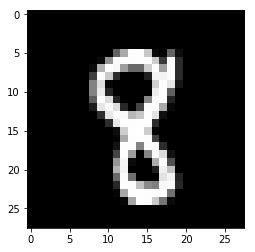

In [0]:
plt.imshow(xb[13].view(28, 28))
yb[13]

In [0]:
# We now have a concise fit function. Easy to understand, easy to maintain
def fit():
    for epoch in range(epochs):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [0]:
fit()

In [0]:
# working as expected

loss = loss_func(model(xb), yb)
acc = accuracy(model(xb), yb)
assert acc > 0.7
loss, acc

(tensor(0.0426, grad_fn=<NllLossBackward>), tensor(1.))

### Random sampling
Right now we're training by order, If the dataset has some kind of chronological order, the results would be very biased. Lets add a possibility to shuffe the data so we can more reliable results. For this we will use 2 pytorch functions, arange and randperm, let's see how they function

In [0]:
# return a list of n-1 numbrers, by order
torch.arange(10)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [0]:
# return a list of n-1 numbrers, by random order
torch.randperm(10)

tensor([0, 1, 6, 2, 3, 5, 7, 4, 9, 8])

In [0]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n = len(ds)
        self.bs = bs
        self.shuffle = shuffle
        
    def __iter__(self):
        # if shuffle is true, give me a list of random numbers in the length of the ds. Otherwise, by order
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        # take those numbers and return parts of the dataset, indexed by those numbers
        for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]

Lets test this

In [0]:
# take a small ds
small_ds = Dataset(*train_ds[:10])

In case you're not farmiliar with the * notation, it's basically just a convient unpacking feature, Uncomment the cells below to see example of astrix unpacking

In [0]:
# def unpack(x, y):
#     print(x+y)

In [0]:
# a = (3, 4)

In [0]:
# # this won't work as a is a tuple, while the function expects two integers. With unpacking however,
# # we can use it.
# unpack(a)

In [0]:
# unpack(*a)

In [0]:
# Lets see what shuffling function Sampler returns when shuffle is off
unShuffled = Sampler(small_ds, 4, False)

In [0]:
# the ds by order, with bs of 4
[a for a in unShuffled]

[tensor([0, 1, 2, 3]), tensor([4, 5, 6, 7]), tensor([8, 9])]

In [0]:
shuffled = Sampler(small_ds, 4, True)

In [0]:
# same thing, but shuffled
[a for a in shuffled]

[tensor([8, 0, 4, 1]), tensor([6, 3, 5, 9]), tensor([2, 7])]

Uncomment to see an example of zip. Notice you can only run the for loop once as this is how zip works

In [0]:
# a = [1, 2, 3]
# b = [3, 4, 5]
# c = zip(a, b)

In [0]:
# for i in c:
#     print(i)

In [0]:
# take that list of tensors (lengthed by bs) and glue them together so every x tensor as a corresponding y tensor
def stack(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

class DataLoader():
    def __init__(self, ds, sampler, stack_fn=stack):
        self.ds = ds
        self.sampler = sampler
        self.stack_fn = stack_fn
        
    def __iter__(self):
        for s in self.sampler:
            # give me a list of tensors
            yield self.stack_fn([self.ds[i] for i in s])
        

In [0]:
train_samp = Sampler(train_ds, bs, shuffle=True)
valid_samp = Sampler(valid_ds, bs, shuffle=False)

In [0]:
train_dl = DataLoader(train_ds, sampler=train_samp, stack_fn=stack)
valid_dl = DataLoader(valid_ds, sampler=valid_samp, stack_fn=stack)

tensor(3)

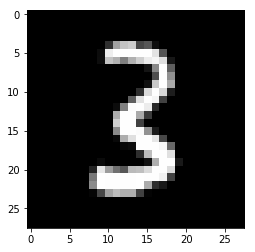

In [0]:
# first number in the first batch is 3
xb, yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(5)

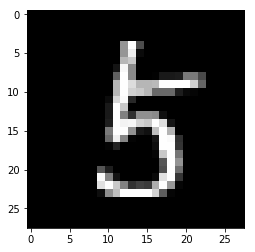

In [0]:
# now that we used next, we itered, we get the first number in the next batch. Note that everytime you re-run this
# you get a different number, as this is shuffled while the one above, valid stays the same as it is not shuffled
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [0]:
# all working as expected

model, opt = get_model()
fit()

loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc > 0.7
loss, acc

(tensor(0.2509, grad_fn=<NllLossBackward>), tensor(0.9375))

In [0]:
# lets check pytorch's version
from torch.utils.data import DataLoader,SequentialSampler, RandomSampler

In [0]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=stack)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=stack)

In [0]:
# all working as expected

model, opt = get_model()
fit()

loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc > 0.7
loss, acc

(tensor(0.0872, grad_fn=<NllLossBackward>), tensor(0.9844))

In [0]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [0]:
# all working as expected

model, opt = get_model()
fit()

loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc > 0.7
loss, acc

(tensor(0.1694, grad_fn=<NllLossBackward>), tensor(0.9531))

Something implemented in pytorch which is not implemented here is the num_workers parameter which uses multiplie proccessors

### validation
To see how is our model behaving with data it hasn't seen before, not predicting the train_set as we've previously done, let's add validation to our fit function

In [0]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # sets an enternal pytorch attribute called training to true (or false in the case of model.eval). This does
        # a few changes in the layers's behavior. For example batch norm, dropout only randomizes on training
        
        model.train()
#         print('after model.train', model.training)
        for xb, yb, in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        # change to eval mode    
        model.eval()
#         print('after model.eval', model.training)
        with torch.no_grad():
            tot_loss = 0.
            tot_acc = 0.
            for xb, yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc += accuracy(pred, yb)
            # nb - number of batches
            # as the batch sizes varies (the lsat one is probably not the same size as the others) it doesnt really
            # make sense to do it like this, but thata how most libraries do it. We will improve this soon
            nb = len(valid_dl)
            print(epoch, tot_loss/nb, tot_acc/nb)
    return tot_loss/nb, tot_acc/nb

In [0]:
# helper func to create data loaders

def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            # in the validation we don't do backward, we don't store grdients, so theres more room. we can increase bs
           DataLoader(valid_ds, batch_size = bs * 2, shuffle=False, **kwargs))

In [0]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
model, opt = get_model()
%time loss, acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

# now we get loss and accuracy (which are calculated a bit differently) of validation. Reasonable time, reasonable
# accuracy

0 tensor(0.2670) tensor(0.9154)
1 tensor(0.2170) tensor(0.9286)
2 tensor(0.1067) tensor(0.9693)
3 tensor(0.1071) tensor(0.9674)
4 tensor(0.1169) tensor(0.9655)
CPU times: user 5.29 s, sys: 294 ms, total: 5.58 s
Wall time: 5.66 s


In [0]:
assert acc > 0.85

## Callbacks

Callbacks are basically functions that are functions called by functions. It can be defined outside of the main function and so keep the main function very clean and concise. It allows us to add functionality without making the main function more complicated. So the callbacks will be defined somewhere else, but will affect the main function. This is going to prove as super useful

In [0]:
del x_train, y_train, x_valid, y_valid

x_train, y_train, x_valid, y_valid = get_data()
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh = 50
bs = 64
c = y_train.max().item() + 1
loss_func = F.cross_entropy

Lets simplify a few things, to make it easier to use and less type errors prone

In [0]:
class DataBunch():
    # lets store c as the number of classes needed in the end, the number of different classes in y.
    def __init__(self, train_dl, valid_dl ,c):
        self.train_dl = train_dl
        self.valid_dl = valid_dl
        self.c = c
    
    # property allows us to treat train_ds as if we wrote DataBunch.train_ds, its a property of the class
    @property
    def train_ds(self):
        return self.train_dl.dataset

    @property
    def valid_ds(self):
        return self.valid_dl.dataset

In [0]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [0]:
def get_model(data, lr=0.5, nh=50):
    # m = 784
    m = data.train_ds.x.shape[1]
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, data.c))
    return model, optim.SGD(model.parameters(), lr=lr)

# Just a wrapper that holds everything needed for training, will make things easier
class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model = model
        self.opt = opt
        self.loss_func = loss_func
        self.data = data

In [0]:
# get_model takes care of model and opt. the * is needed as data takes a few parameters which also uses * 
# as it uses a few parameters. We can then see why is it so useful. Otherwise, things would get messy and error prone
learn = Learner(*get_model(data), loss_func, data)

In [0]:
# same fit funcation as before, the only changes are that data related stuff comes from data. and the rest comes 
# from stuff comes from learn.

def fit(epochs, learn):
    for epoch in range(epochs):
        learn.model.train()
        for xb, yb, in learn.data.train_dl:
            loss = loss_func(learn.model(xb), yb)
            loss.backward()
            learn.opt.step()
            learn.opt.zero_grad() 
        learn.model.eval()
        with torch.no_grad():
            tot_loss = 0.
            tot_acc = 0.
            for xb, yb in learn.data.valid_dl:
                pred = learn.model(xb)
                tot_loss += learn.loss_func(pred, yb)
                tot_acc += accuracy(pred, yb)
            nb = len(learn.data.valid_dl)
            print(epoch, tot_loss/nb, tot_acc/nb)
    return tot_loss/nb, tot_acc/nb

In [0]:
%time loss, acc = fit(3, learn)

0 tensor(0.6452) tensor(0.8352)
1 tensor(0.1342) tensor(0.9608)
2 tensor(0.1621) tensor(0.9518)
CPU times: user 3.2 s, sys: 118 ms, total: 3.31 s
Wall time: 3.37 s


### Callback system
We are now going to define our callback system which its rapper will be called Runner

In [0]:
import re
_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')

def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

All callbacks will inherit from this callback super class. It defines 3 things:
1. Order - which will make sure a callback that is based on a previous callback, will run only afterwards
2. set_runner - Sets the correct runner. As the callbacks operate but are not defined inside the runner, it needs access to the data/context in which it is operating
3. __getattr__ convienience dunder method which will allow us to write self.x instead of self.specificContext.x  (I will show examples when it will be used)
4. name function makes sure its very easy to add callback classes, as its taking care of camel/snake casing and of naming. I will show an exmaple

This is an example callback class which we are using. The class is called with runner, the functions are defined here and called during the training in the runner class (which wraps the fit function)

Functions that turns many things into lists, example:

In [0]:
from typing import *

def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, str): return [o]
    if isinstance(o, Iterable): return list(o)
    return [o]

This is the main and most important class as it wraps everything. This class defines the training and call the callbacks (which as mentioned, are defined elsewhere)

it Holds 5 main functions (with some class functions for convienience, e.g @property):
1. init takes incoming functions and uses setattr to set them a name so they could be called with a simple name. It also receives the TrainEvalCallback class we defined above (later we will add an additional callback class)
2. The most important part is fit. As we can see, this function doesn't really do anything, it only calls other functions that are actually doing the heavy lifting. It's designed this way for maximum flexibility and comfortable experiments.
3. At the beginning of every epoch, fit calls all batches which in turn calls one batch.
4. We see the __call__ method, this is only mostly for convience, as we could name it otherwise. The bonus we're getting with using __call__ and not calling it any other name, is that we can now just do self.('callbackName') because everytime we do self. it actually uses the __call__ method. Alternatively we can name __call__ by any other name, say .. doIt and then we would just do self.doIt('callbackName') - somewhat less convienient in my view.



In [0]:
class Callback():
    _order=0
    def set_runner(self, run): self.run=run
    def __getattr__(self, k): return getattr(self.run, k)
    
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f(): return True
        return False

class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs=0.
        self.run.n_iter=0
    
    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1
        
    def begin_epoch(self):
        self.run.n_epochs=self.epoch
        self.model.train()
        self.run.in_train=True

    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False

class CancelTrainException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass

In [0]:
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs

    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self):      return self.learn.data

    def one_batch(self, xb, yb):
        try:
            self.xb,self.yb = xb,yb
            self('begin_batch')
            self.pred = self.model(self.xb)
            self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb)
            self('after_loss')
            if not self.in_train: return
            self.loss.backward()
            self('after_backward')
            self.opt.step()
            self('after_step')
            self.opt.zero_grad()
        except CancelBatchException: self('after_cancel_batch')
        finally: self('after_batch')

    def all_batches(self, dl):
        self.iters = len(dl)
        try:
            for xb,yb in dl: self.one_batch(xb, yb)
        except CancelEpochException: self('after_cancel_epoch')

    def fit(self, epochs, learn):
        self.epochs,self.learn,self.loss = epochs,learn,tensor(0.)

        try:
            for cb in self.cbs: cb.set_runner(self)
            self('begin_fit')
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad(): 
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                self('after_epoch')
            
        except CancelTrainException: self('after_cancel_train')
        finally:
            self('after_fit')
            self.learn = None

    def __call__(self, cb_name):
        res = False
        for cb in sorted(self.cbs, key=lambda x: x._order): res = cb(cb_name) and res
        return res

This is callback that differs from the callbacks we used before in a sense that it uses another class. The class AvgStatsCallback is what being used in runner, but it relies on AvgStats doing the heavy lifting

In [0]:
class AvgStats():
    def __init__(self, metrics, in_train): 
        self.metrics =  listify(metrics)
        self.in_train = in_train
    
    def reset(self):
        self.tot_loss = 0.
        self.count = 0.
        self.tot_mets = [0.] * len(self.metrics)
        
    @property
    def all_stats(self): return [self.tot_loss.item()] + self.tot_mets
    @property
    def avg_stats(self): return [o/self.count for o in self.all_stats]
    
    # makes the func more readable when printed
    def __repr__(self):
        if not self.count: return ""
        return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"
    
    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        for i,m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb) * bn

class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        # On training, avgStat's in_train receives True. On eval, it receives false
        self.train_stats = AvgStats(metrics,True)
        self.valid_stats = AvgStats(metrics,False)
  
    # Note that begin epoch is also defined in the previous callback class and so we add functionality on the same
    # time in training. The name of the cb is "deciding" when does this function take place
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
    
    # on traning stats are training stats, same for evaluation
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)

In [0]:
learn = Learner(*get_model(data), loss_func, data)

This is one way of adding callbacks

In [0]:
stats = AvgStatsCallback([accuracy])
run = Runner(cbs=stats)

In [0]:
run.fit(2, learn)

train: [0.318854765625, tensor(0.9024)]
valid: [0.17940682373046876, tensor(0.9464)]
train: [0.144626826171875, tensor(0.9564)]
valid: [0.643386669921875, tensor(0.8036)]


Partial is a function that returns a function. So partial gets a class with the needed attribute, and acc_cbf is a function, that can create another function (defined in the AvgStasCallback). Inside runner we will activate acc_cbf through cb_funcs

In [0]:
class TestCallback(Callback):
    _order = 1
    def after_step(self):
        print(self.n_iter)
        if self.n_iter >= 10:
            print('training over, goodbye')
            raise CancelTrainException()

In [0]:
run = Runner(cb_funcs=TestCallback)

In [0]:
run.fit(3, learn)

0
1
2
3
4
5
6
7
8
9
10
training over, goodbye


In [0]:
from functools import partial

This is the second way

In [0]:
acc_cbf = partial(AvgStatsCallback, accuracy)

In [0]:
run = Runner(cb_funcs=acc_cbf)

In [0]:
run.fit(1, learn)

train: [0.107977978515625, tensor(0.9661)]
valid: [0.10814755859375, tensor(0.9670)]


In [0]:
def first(someFunc):
    def third():
        print('this is third')
        someFunc()
    return third

In [0]:
# when I activate this function, 
@first
def second():
    print('this is second')

In [0]:
@first
def something():
    print('this is something')

In [0]:
second()

this is third
this is second


In [0]:
something()

this is third
this is something


Lets now use this callback system to generate discriminative learning rates, meaning - lets train different parts of the model with a different lr. As a neural network behaves differently in different part of its training, its a very good idea to give it different hyper parameters (lr, weight decay, dropout etc) depending on what bets suits this part of the training. 

In [0]:
# initializing the data

del x_train, y_train, x_valid, y_valid

x_train, y_train, x_valid, y_valid = get_data()
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh, bs = 50, 512
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [0]:
# get the data
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [0]:
# convienience function to create a learner as its a wrapper anyway
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [0]:
learn = create_learner(get_model, loss_func, data)
# build the runner the same way as before
run = Runner([AvgStatsCallback([accuracy])])

# good speed, reasonable prediction for this super shallow model. * defaults to lr=0.5
%time run.fit(3, learn)

train: [0.6661690625, tensor(0.8081)]
valid: [0.3281145751953125, tensor(0.8999)]
train: [0.29720892578125, tensor(0.9131)]
valid: [0.2432054443359375, tensor(0.9281)]
train: [0.2400436328125, tensor(0.9304)]
valid: [0.20361383056640625, tensor(0.9427)]
CPU times: user 2.2 s, sys: 27.4 ms, total: 2.23 s
Wall time: 2.27 s


In [0]:
# trying with lr= 0.3, gives results which are worse
learn = create_learner(partial(get_model, lr=0.3), loss_func, data)
run.fit(3, learn)

train: [0.7695396875, tensor(0.8004)]
valid: [0.3526537841796875, tensor(0.8964)]
train: [0.342393359375, tensor(0.9028)]
valid: [0.295682177734375, tensor(0.9163)]
train: [0.290835625, tensor(0.9169)]
valid: [0.2539874267578125, tensor(0.9286)]


In [0]:
# convienience model for different lr, defaulting to 0.5
def get_model_func(lr=0.5):
    return partial(get_model, lr=lr)

So now lets actually do the lr schedulling. We need 2 callbacks for that. The first will keep track of loss and current lr, and the second will actually schedule the correct lr

In [0]:
# sched lin is using a decorator. That means it uses the _inner that takes start and end, and returns a function
# (sched_lin) that only takes pos (as start & end are already given) with the logic defined in that function
# (sched_lin). So sched_lin actually turns into a function that only takes one parameter, making the function again,
# concise and easy to maintain and experiment

def annealer(f):
    def _inner(start, end):
        return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos):
    return start + pos*(end-start)

In [0]:
class Recorder(Callback):
    def begin_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []

    def after_batch(self):
        if not self.in_train: return
        for pg,lr in zip(self.opt.param_groups,self.lrs): lr.append(pg['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self, pgid=-1): plt.plot(self.lrs[pgid])
    def plot_loss(self, skip_last=0): plt.plot(self.losses[:len(self.losses)-skip_last])
        
    def plot(self, skip_last=0, pgid=-1):
        losses = [o.item() for o in self.losses]
        lrs    = self.lrs[pgid]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs): self.pname,self.sched_funcs = pname,sched_funcs
        
    def begin_fit(self):
        if not isinstance(self.sched_funcs, (list,tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)

    def set_param(self):
        assert len(self.opt.param_groups)==len(self.sched_funcs)
        for pg,f in zip(self.opt.param_groups,self.sched_funcs):
            pg[self.pname] = f(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

In [0]:
@annealer
def sched_cos(start, end, pos):
    return start + (1 + math.cos(math.pi*(1-pos))) * (end - start) / 2

@annealer
def sched_no(start, end, pos):
    return start

@annealer
def sched_exp(start, end, pos):
    return start * (end/start) ** pos

# without this plotting won't work
torch.Tensor.ndim = property(lambda x: len(x.shape))

In [0]:
annealings = "NO LINEAR COS EXP".split()

In [0]:
annealings

['NO', 'LINEAR', 'COS', 'EXP']

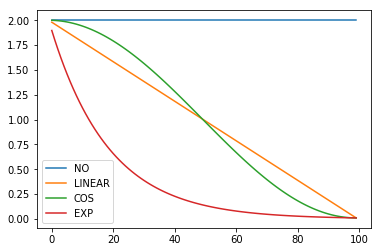

In [0]:
a = torch.arange(0, 100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

In [0]:
def combine_scheds(pcts, scheds):
    pcts = tensor([0] + listify(pcts))
    pcts = torch.cumsum(pcts, 0)
#     import pdb
#     pdb.set_trace()
    def _inner(pos):   
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

In [0]:
# 30% of the batches, do two faces, 0.3-0.6 and 0.6-0.2
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])

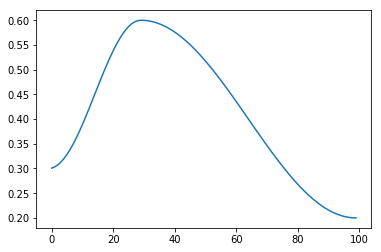

In [0]:
plt.plot(a, [sched(o) for o in p])

In [0]:
# the architechture of runner allows us to take partial, enter it the class and the attributes it needs,
# stick it into cbfs and it will run
cbfs = [Recorder,
       partial(AvgStatsCallback, accuracy),
       partial(ParamScheduler, 'lr', sched)]

In [0]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs = cbfs)

In [0]:
run.fit(3, learn)

train: [0.770825625, tensor(0.7905)]
valid: [0.4005251708984375, tensor(0.8774)]
train: [0.30976638671875, tensor(0.9100)]
valid: [0.252619580078125, tensor(0.9275)]
train: [0.241400625, tensor(0.9312)]
valid: [0.216352978515625, tensor(0.9410)]


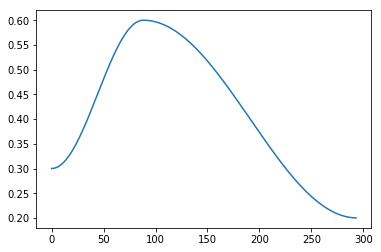

In [0]:
run.recorder.plot_lr()

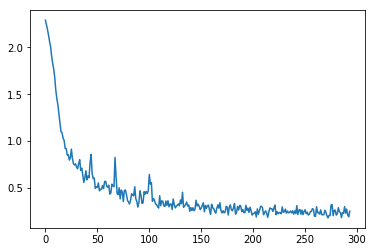

In [0]:
run.recorder.plot_loss()

In [0]:
# To change the lrs/schedules of lrs, change the attributes here and re-run
# sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])

In [0]:
run.recorder.losses

[tensor(2.2914),
 tensor(2.2434),
 tensor(2.1932),
 tensor(2.1277),
 tensor(2.0647),
 tensor(2.0069),
 tensor(1.9071),
 tensor(1.8276),
 tensor(1.7709),
 tensor(1.6748),
 tensor(1.5429),
 tensor(1.4531),
 tensor(1.3861),
 tensor(1.2843),
 tensor(1.1924),
 tensor(1.1007),
 tensor(1.0868),
 tensor(1.0308),
 tensor(1.0064),
 tensor(0.9221),
 tensor(0.9206),
 tensor(0.8502),
 tensor(0.8541),
 tensor(0.7960),
 tensor(0.8194),
 tensor(0.9130),
 tensor(0.8126),
 tensor(0.7558),
 tensor(0.7432),
 tensor(0.7560),
 tensor(0.7208),
 tensor(0.7030),
 tensor(0.7586),
 tensor(0.7999),
 tensor(0.6853),
 tensor(0.7090),
 tensor(0.6363),
 tensor(0.5564),
 tensor(0.6065),
 tensor(0.6807),
 tensor(0.5849),
 tensor(0.6249),
 tensor(0.6077),
 tensor(0.7676),
 tensor(0.8569),
 tensor(0.6504),
 tensor(0.5977),
 tensor(0.6025),
 tensor(0.4933),
 tensor(0.5086),
 tensor(0.5027),
 tensor(0.5512),
 tensor(0.4672),
 tensor(0.4852),
 tensor(0.4846),
 tensor(0.5239),
 tensor(0.4905),
 tensor(0.5677),
 tensor(0.5682

As we have everything needed, let's create a callback that stops training if we crossed some number of iterations OR if we're getting much worse results, in this case it's probably useless to continue

In [0]:
class LR_Find(Callback):
    _order = 1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter = max_iter
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.best_loss = 1e9
    
    def begin_batch(self):
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.param_groups:
            pg['lr'] = lr
    
    def after_step(self):
        if self.n_iter >= self.max_iter or self.loss > self.best_loss * 10:
            raise CancelTrainException()
        if self.loss < self.best_loss:
            self.best_loss = self.loss

In [0]:
learn = create_learner(get_model, loss_func, data)
run = Runner(cb_funcs=[LR_Find, Recorder])
run.fit(2, learn)

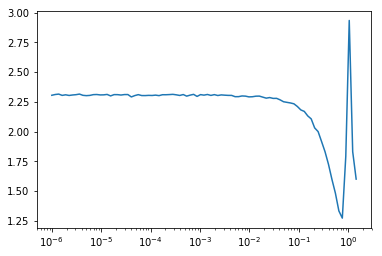

In [0]:
# lr finder shows us when it's ruining our training
run.recorder.plot(skip_last=5)

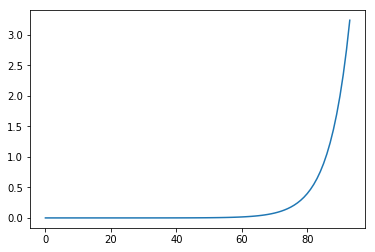

In [0]:
# it only does less than 100 epochs, as the loss got too big
run.recorder.plot_lr()

In [0]:
class cudaCallback(Callback):
  def __init__(self, device):
    self.device = device
    
  def begin_batch(self):
    self.model.to(device)
    
  def begin_batch(self):
    self.run.xb = self.xb.to(device)
    self.run.yb = self.yb.to(device)

In [0]:
class CudaCallback(Callback):
  def begin_fit(self):
    self.model.cuda()
    
  def begin_batch(self):
    self.run.xb = self.xb.cuda()
    self.run.yb = self.yb.cuda()

In [0]:
def conv2d(ni, nf, ks=3, stride=2):
  return nn.Sequential(
      nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

In [0]:
class BatchTransformXCallback(Callback):
  _order = 2
  def __init__(self, tfm):
    self.tfm = tfm
    
  def begin_batch(self):
    self.run.xb = self.tfm(self.xb)
    
def view_tfm(*size):
  def _inner(x):
     return x.view(*((-1,)+size))
  return _inner

In [0]:
def get_cnn_layers(data, nfs):
  nfs = [1] + nfs
  return [
      # ks is 5x5 for the first layer, 3 on all other layers
      conv2d(nfs[i], nfs[i+1], 5 if i == 0 else 3)
      for i in range(len(nfs) -1)
  ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]
  
def get_cnn_model(data, nfs):
  return nn.Sequential(*get_cnn_layers(data, nfs))

In [0]:
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func=F.cross_entropy):
  if opt_func is None:
    opt_func = optim.SGD
  opt = opt_func(model.parameters(), lr=lr)
  learn = Learner(model, opt, loss_func, data)
  return learn, Runner(cb_funcs=listify(cbs))

## Hooks

In [0]:
# Lets rebuild the sequential model we built before, but this time save the different layers's mean and std

class SequentialModel(nn.Module):
  def __init__(self, *layers):
    super().__init__()
    self.layers = nn.ModuleList(layers)
    self.act_means = [[] for _ in layers]
    self.act_stds = [[] for _ in layers]
    
  def __call__(self, x):
    for i, l in enumerate(self.layers):
      x = l(x)
      self.act_means[i].append(x.data.mean())
      self.act_stds[i].append(x.data.std())
    return x
  
  def __iter__(self):
    return iter(self.layers)

In [0]:
# will be used for storing the means and stds in the [] we created, when ever the layer is calculated. This is the callback
def append_stats(i, mod, inp, outp):
  act_means[i].append(outp.data.mean())
  act_stds[i].append(outp.data.std())

As this is being used a lot, lets use pytorch's hooks

In [0]:
# model's children are its layers, uncomment loop below so see how it looks
def children(m):
  return list(m.children())

# for l in children(model):
#   print(l)

In [0]:
class Hook():
  def __init__(self, m, f):
    # use some function f, with self, meaning with the hook
    self.hook = m.register_forward_hook(partial(f, self))
  # we need to remove the hooks after appending them because otherwise next time pytorch will calculate all the hooks, which will get very memory wise expensive
  def remove(self):
      self.hook.remove()
  # function in python that deals with cleaning memory. When we're done with the hooks this will be activated, which in turn will activate def remove    
  def __del__(self):
      self.remove()

In [0]:
def append_stats(hook, mod, inp, outp):
  if not hasattr(hook, 'stats'):
    hook.stats = ([], [])
  means, stds = hook.stats
  means.append(outp.data.mean())
  stds.append(outp.data.std())

In [0]:
# a very handy class that will help us deal with hooks. For example, __getitem__ is what being called when we index into something (e.g x[3])
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int,slice)): return self.items[idx]
        if isinstance(idx[0],bool):
            assert len(idx)==len(self) # bool mask
            return [o for m,o in zip(idx,self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

In [0]:
from torch.nn import init

class Hooks(ListContainer):
  def __init__(self, ms, f):
    super().__init__([Hook(m, f) for m in ms])
    
    # both enter and exit are used to later call the hook with "with" context manager, which will clear the hooks from memory after use
  def __enter__(self, *args):
    return self
  def __exit__(self, *args):
    self.remove()
  def __del__(self):
    self.remove()
  
  def __delitem__(self, i):
    self[i].remove()
    super().__delitem__(i)
    
  def remove(self):
    for h in self:
      h.remove()

We don't like the bumpiness because it can easily mean our gradients are very close to 0 and the model won't learn. Nonetheless, it could be that a bumpy model will learn well, for example if the data is very bumpy for any reason. What we actually want to know, is what happens with our gradients ? are they being used or are they just 0 ?. We will add an histogram to help ourselves see that better

In [0]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'):
      hook.stats = ([], [], [])
    means, stds, hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds.append(outp.data.std().cpu())
    # these histograms are not supported on GPU and so removed to cpu
    # in histc we don't need to go lower than 0 as we've got relu, nothing is negative
    hists.append(outp.data.cpu().histc(40,0,10))

In [0]:
def get_hist(h):
  return torch.stack(h.stats[2]).t().float().log1p()

In [0]:
# the first two hisgorams are approximitaley 0 (h1[:2]) so lets check which part of the actions is actually pretty much the same, and plot it. 

def get_min(h):
  h1 = torch.stack(h.stats[2]).t().float()
  return h1[:2].sum(0)/h1.sum(0)

So lets try and fix this, we will do so by introducing a bit of a different kind of activation function than the one we've been using (relu)

In [0]:
def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
    nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))
    


class GeneralRelu(nn.Module):
  def __init__(self, leak=None, sub=None, maxv=None):
    self.leak = leak
    self.sub = sub
    self.maxv = maxv
    super().__init__()
    
  def forward(self, x):
    x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
    if self.sub is not None: x.sub_(self.sub)
    if self.maxv is not None: x.clamp_max_(self.maxv)
    return x

def init_cnn(m, uniform=False):
  f = init.kaiming_uniform if uniform else init.kaiming_normal_
  for l in m:
    if isinstance(l, nn.Sequential):
      f(l[0].weight, a = 0.1)
      l[0].bias.data.zero_()

def get_cnn_model(data, nfs, layer, **kwargs):
  return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))
    

In [0]:
def append_stats(hook, mod, inp, outp):
  if not hasattr(hook, 'stats'):
    hook.stats = ([], [], [])
  means, stds, hists = hook.stats
  means.append(outp.data.mean().cpu())
  stds.append(outp.data.std().cpu())
  hists.append(outp.data.cpu().histc(40,-7,7))

In [0]:
def get_min(h):
  h1 = torch.stack(h.stats[2]).t().float()
  return h1[19:22].sum(0)/h1.sum(0)

In [0]:
del x_train, y_train, x_valid, y_valid

x_train,y_train,x_valid,y_valid = get_data()

In [0]:
def normalize_to(train, valid):
    m,s = train.mean(),train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [0]:
x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

In [0]:
x_train.mean(),x_train.std()


(tensor(0.0001), tensor(1.))

In [0]:
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [0]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

def flatten(x):      return x.view(x.shape[0], -1)

In [0]:
def mnist_resize(x): return x.view(-1, 1, 28, 28)


In [0]:

def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
        nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
        nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
        nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32,data.c)
    )

In [0]:
model = get_cnn_model(data)


In [0]:
cbfs = [Recorder, partial(AvgStatsCallback,accuracy)]


In [0]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [0]:
%time run.fit(1, learn)

In [0]:
device = torch.device('cuda',0)

In [0]:

class CudaCallback(Callback):
    def __init__(self,device): self.device=device
    def begin_fit(self): self.model.to(self.device)
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.to(self.device),self.yb.to(self.device)

In [0]:
torch.cuda.set_device(device)


In [0]:
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()

In [0]:
cbfs.append(CudaCallback)


In [0]:
model = get_cnn_model(data)


In [0]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [0]:
%time run.fit(3, learn)

In [0]:

def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

In [0]:
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)

def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

In [0]:
mnist_view = view_tfm(1,28,28)
cbfs.append(partial(BatchTransformXCallback, mnist_view))

In [0]:
nfs = [8,16,32,32]


In [0]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

In [0]:
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [0]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [0]:
run.fit(3, learn)

In [0]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds [i].append(x.data.std ())
        return x
    
    def __iter__(self): return iter(self.layers)

In [0]:
model =  SequentialModel(*get_cnn_layers(data, nfs))
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [0]:
run.fit(2, learn)

train: [1.96021265625, tensor(0.2994, device='cuda:0')]
valid: [1.10287744140625, tensor(0.6034, device='cuda:0')]
train: [0.4742244140625, tensor(0.8423, device='cuda:0')]
valid: [0.19626802978515626, tensor(0.9366, device='cuda:0')]


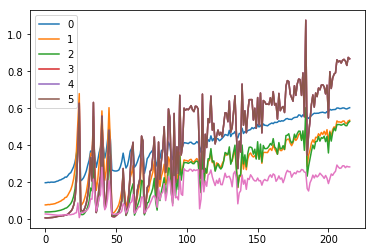

In [0]:

for l in model.act_means: plt.plot(l)
plt.legend(range(6));

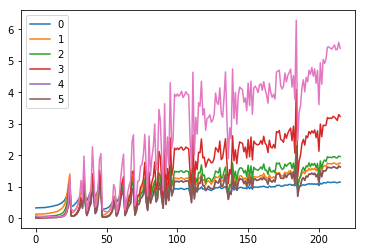

In [0]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(6));


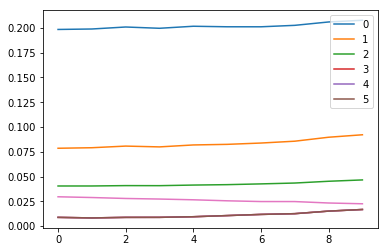

In [0]:

for l in model.act_means: plt.plot(l[:10])
plt.legend(range(6));


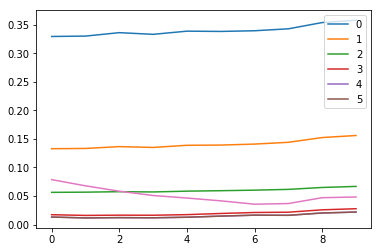

In [0]:

for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(6));

In [0]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [0]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

In [0]:

def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds [i].append(outp.data.std())

In [0]:
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))


In [0]:
run.fit(1, learn)

train: [2.22744703125, tensor(0.1858, device='cuda:0')]
valid: [1.683660546875, tensor(0.4158, device='cuda:0')]


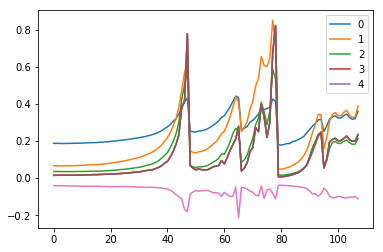

In [0]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

In [0]:
def children(m): return list(m.children())

class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    means,stds = hook.stats
    means.append(outp.data.mean())
    stds .append(outp.data.std())

In [0]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [0]:
hooks = [Hook(l, append_stats) for l in children(model[:4])]


In [0]:
run.fit(1, learn)


train: [1.62567078125, tensor(0.4379, device='cuda:0')]
valid: [0.9091265625, tensor(0.7363, device='cuda:0')]


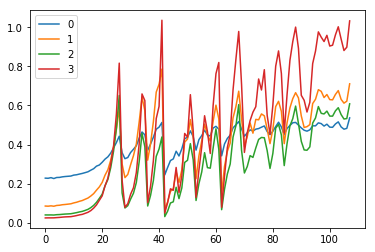

In [0]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4));

In [0]:
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int,slice)): return self.items[idx]
        if isinstance(idx[0],bool):
            assert len(idx)==len(self) # bool mask
            return [o for m,o in zip(idx,self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

In [0]:
ListContainer(range(10))


ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [0]:
ListContainer(range(100))


ListContainer (100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

In [0]:
t = ListContainer(range(10))
t[[1,2]], t[[False]*8 + [True,False]]

([1, 2], [8])

In [0]:
from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self: h.remove()

In [0]:
model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [0]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7f20e7607208>, <__main__.Hook object at 0x7f20e7607da0>, <__main__.Hook object at 0x7f20e7607710>, <__main__.Hook object at 0x7f20e75cb9b0>, <__main__.Hook object at 0x7f20e75cbf98>, <__main__.Hook object at 0x7f20e75cbc18>, <__main__.Hook object at 0x7f20e75cb358>]

In [0]:
hooks.remove()


In [0]:
x,y = next(iter(data.train_dl))
x = mnist_resize(x).cuda()

In [0]:
x.mean(),x.std()


(tensor(-0.0005, device='cuda:0'), tensor(0.9984, device='cuda:0'))

In [0]:

p = model[0](x)
p.mean(),p.std()

(tensor(0.1567, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.2741, device='cuda:0', grad_fn=<StdBackward0>))

In [0]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [0]:
p = model[0](x)
# p.mean(),p.std()

train: [nan, tensor(0.1292, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]


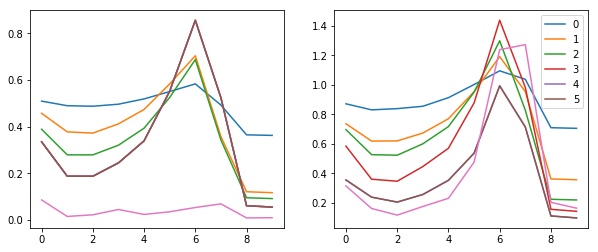

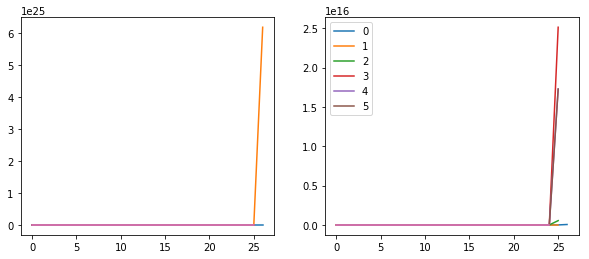

In [0]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6));


In [0]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,0,10)) #histc isn't implemented on the GPU

In [0]:

model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [0]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [0]:
with Hooks(model, append_stats) as hooks: run.fit(1, learn)


train: [1.40512609375, tensor(0.5247, device='cuda:0')]
valid: [0.263621728515625, tensor(0.9202, device='cuda:0')]


In [0]:
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()


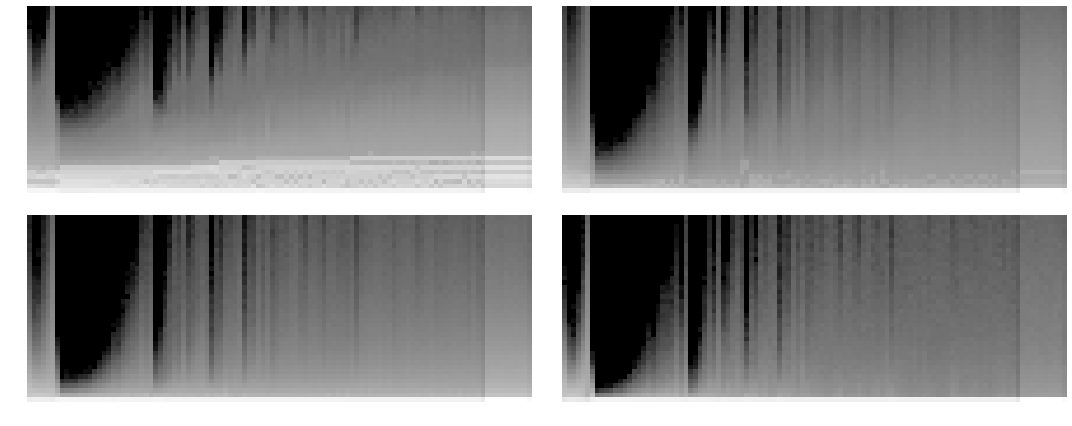

In [0]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [0]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:2].sum(0)/h1.sum(0)


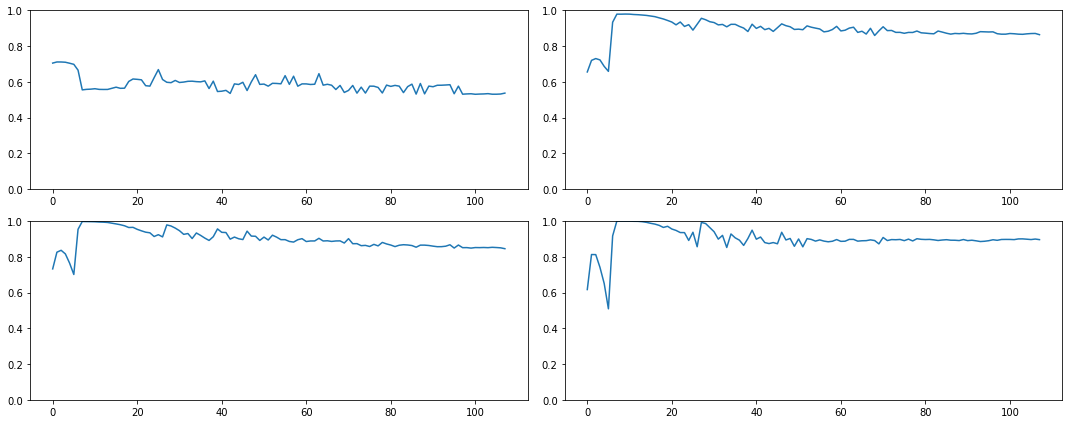

In [0]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

In [0]:
def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))

class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.1)
            l[0].bias.data.zero_()

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [0]:
# def append_stats(hook, mod, inp, outp):
#     if not hasattr(hook,'stats'): hook.stats = ([],[],[])
#     means,stds,hists = hook.stats
#     means.append(outp.data.mean().cpu())
#     stds .append(outp.data.std().cpu())
#     hists.append(outp.data.cpu().histc(40,-7,7))

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,-7,7))

In [0]:
model =  get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

train: [0.5494515234375, tensor(0.8226, device='cuda:0')]
valid: [0.1668673095703125, tensor(0.9525, device='cuda:0')]


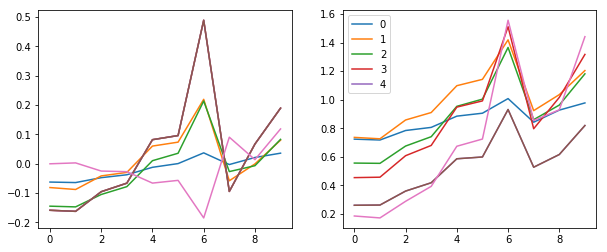

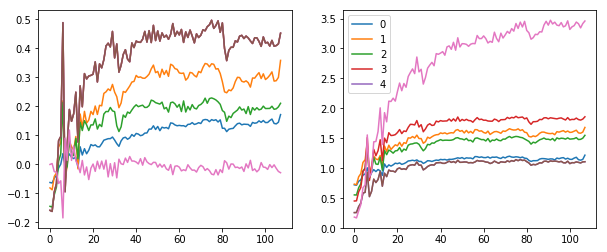

In [0]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

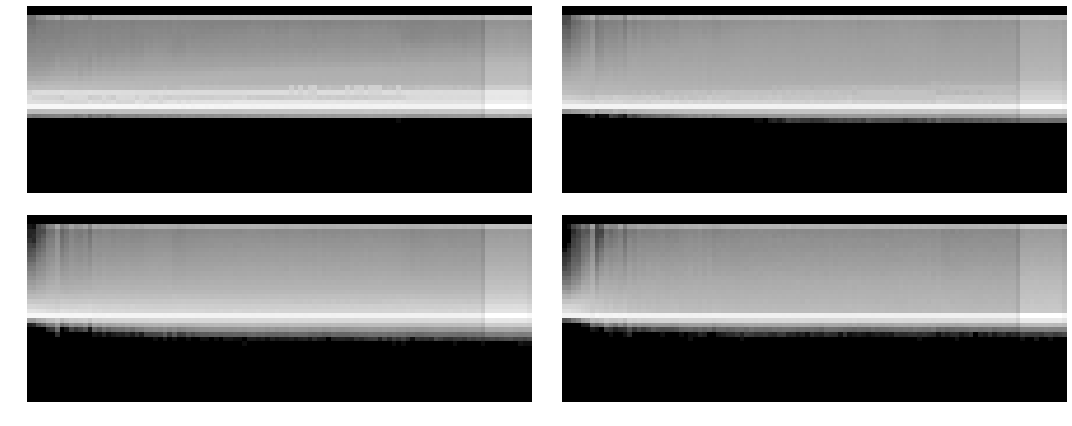

In [0]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [0]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19:22].sum(0)/h1.sum(0)

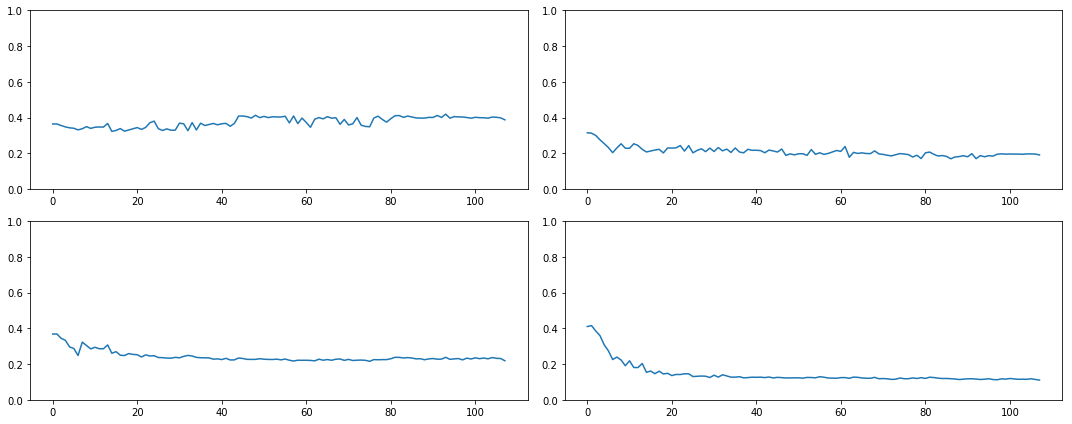

In [0]:

fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

In [0]:
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [0]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)])


In [0]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs+[partial(ParamScheduler,'lr', sched)])


In [0]:
run.fit(8, learn)

train: [1.1320675, tensor(0.6358, device='cuda:0')]
valid: [0.30437822265625, tensor(0.9100, device='cuda:0')]
train: [0.333939765625, tensor(0.8975, device='cuda:0')]
valid: [0.451065673828125, tensor(0.8547, device='cuda:0')]
train: [0.19403203125, tensor(0.9413, device='cuda:0')]
valid: [0.127369970703125, tensor(0.9610, device='cuda:0')]
train: [0.2328848828125, tensor(0.9275, device='cuda:0')]
valid: [0.12905372314453126, tensor(0.9617, device='cuda:0')]
train: [0.085245263671875, tensor(0.9731, device='cuda:0')]
valid: [0.09474446411132813, tensor(0.9738, device='cuda:0')]
train: [0.0588696435546875, tensor(0.9825, device='cuda:0')]
valid: [0.06893562622070312, tensor(0.9810, device='cuda:0')]
train: [0.043768408203125, tensor(0.9869, device='cuda:0')]
valid: [0.0667878662109375, tensor(0.9810, device='cuda:0')]
train: [0.0362720166015625, tensor(0.9895, device='cuda:0')]
valid: [0.06642067260742188, tensor(0.9816, device='cuda:0')]


In [0]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, uniform=True,
                          cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [0]:
run.fit(8, learn)

train: [1.000054921875, tensor(0.6883, device='cuda:0')]
valid: [0.2658014404296875, tensor(0.9208, device='cuda:0')]
train: [0.278333671875, tensor(0.9160, device='cuda:0')]
valid: [0.15751712646484375, tensor(0.9536, device='cuda:0')]
train: [0.21820017578125, tensor(0.9347, device='cuda:0')]
valid: [0.1155056396484375, tensor(0.9653, device='cuda:0')]
train: [0.131544609375, tensor(0.9607, device='cuda:0')]
valid: [0.0950859130859375, tensor(0.9726, device='cuda:0')]
train: [0.989590859375, tensor(0.6947, device='cuda:0')]
valid: [0.2942487548828125, tensor(0.9067, device='cuda:0')]
train: [0.17646974609375, tensor(0.9468, device='cuda:0')]
valid: [0.12232322998046875, tensor(0.9633, device='cuda:0')]
train: [0.113875322265625, tensor(0.9656, device='cuda:0')]
valid: [0.10978885498046875, tensor(0.9697, device='cuda:0')]
train: [0.094743095703125, tensor(0.9713, device='cuda:0')]
valid: [0.10039966430664063, tensor(0.9712, device='cuda:0')]


## Batch Norm
We're going to add normalization named batch norm that will enable us to raise the lr, while still training well

In [0]:
x_train,y_train,x_valid,y_valid = get_data()

x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [0]:
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]

In [0]:

nfs = [8,16,32,64,64]


In [0]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

So this is our PRE batch_norm training which we are going to compare to PRE batch_norm. lr is 0.4 (more than that brings worse results) and the accuracy is 95%

In [0]:
%time run.fit(3, learn)

train: [0.917395859375, tensor(0.7009, device='cuda:0')]
valid: [0.21254638671875, tensor(0.9362, device='cuda:0')]
train: [0.13326482421875, tensor(0.9584, device='cuda:0')]
valid: [0.1062825927734375, tensor(0.9694, device='cuda:0')]
train: [0.08581740234375, tensor(0.9727, device='cuda:0')]
valid: [0.09245447998046875, tensor(0.9730, device='cuda:0')]
CPU times: user 4.31 s, sys: 1.38 s, total: 5.69 s
Wall time: 5.72 s


The idea of batch normalization is pretty simple: normalize the data, multiplie by a parameter (gamma) and add another one (Beta).  We are going to define 2 parameters (learned variables) which we will name mults and adds (originally named gamma and beta). Those parameters will be initiated as 1 and 0, and the network will learn what value to give it.

In [0]:
class BatchNorm(nn.Module):
  def __init__(self, nf, mom=0.1, eps=1e-5):
    super().__init__()
    self.mom = mom
    # eps for epsilon
    self.eps = eps
    # initially we multiplie by 1 and add 0, so nothing changes
    self.mults = nn.Parameter(torch.ones(nf, 1, 1))
    self.adds = nn.Parameter(torch.zeros(nf, 1, 1))
    # Register buffer does adds useful functionallity. It moves whats being declared (vars/means) to the GPU (in case we move the model to the GPU).
    # Second thing is that it saves those variables so we can use in the forward
    self.register_buffer('vars', torch.ones(1,nf,1,1))
    self.register_buffer('means', torch.zeros(1,nf,1,1))

    
  def update_stats(self, x): 
    # (0,2,3) means we average on each filter. 0 is batches, 2 & 3 are height and width. Keepdim makes sure broadcasting works by leave en empty unix axis in 0, 2 and 3 axis
    m = x.mean((0, 2, 3), keepdim=True)
    v = x.var((0, 2, 3,), keepdim=True)
    # lerp is pytorch's way of doing linear interpolation (taking some value times x and another value times 1-x and sums the two products). This value will be our momentum. In pytorch
    # lerp does 1 minus what we give it, so if we want momentum of 0.9 (which means each step is 10% its average, and 90% the previous average), we need to specify mom=0.1 
    self.means.lerp_(m, self.mom)
    self.vars.lerp_(v, self.mom)
    return m,v
    
    
  
  def forward(self, x):
    if self.training:
      with torch.no_grad():
        m,v = self.update_stats(x)
    else:
      m = self.means
      v = self.vars
      # eps here helps make sure that even if v is very low, activations won't blow up (diving by something very small, will make activations very big)
    x = (x-m) / (v+self.eps).sqrt()
    return x*self.mults + self.adds

    
  

In [0]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
  layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
  GeneralRelu(**kwargs)]
  if bn:
    layers.append(BatchNorm(nf))
  return nn.Sequential(*layers)
  

In [0]:
# # A function that initializes the layers with 0 in bias and kaiming uniform/normal according to what being chosen. This happen recurcevly, so for every layer

def init_cnn_(m ,f):
  if isinstance(m, nn.Conv2d):
    f(m.weight, a=0.1)
    if getattr(m, 'bias', None) is not None:
      m.bias.data.zero_()
  for l in m.children():
    init_cnn(l, f)
    
def init_cnn(m, uniform=False):
  f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
  init_cnn_(m, f)


# and now combining the cc with our runner
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
  model = get_cnn_model(data, nfs, layer, **kwargs)
  init_cnn(model, uniform=uniform)
  return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)


In [0]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)


And we can see - our std starts at 1 exactly, (right column) and our mean starts at 0 exactly (left column) and our training looks much better. No sudden crashes, no massive ups and downs

train: [0.2940396875, tensor(0.9068, device='cuda:0')]
valid: [0.156294287109375, tensor(0.9505, device='cuda:0')]


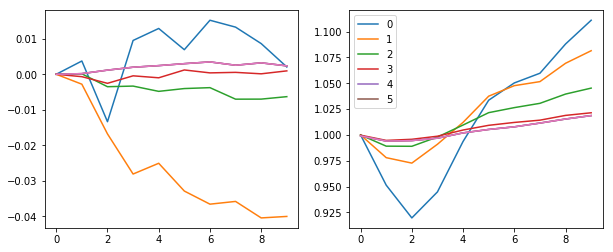

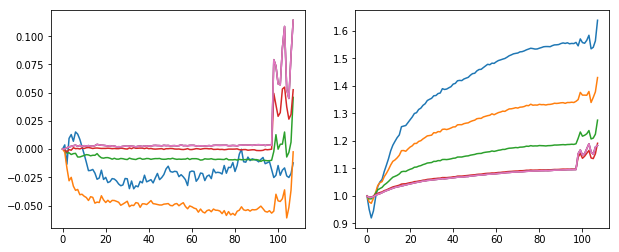

In [0]:
with Hooks(learn.model, append_stats) as hooks:
  run.fit(1, learn)
  fig,(ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
  for h in hooks[:-1]:
    ms,ss,hi = h.stats
    ax0.plot(ms[:10])
    ax1.plot(ss[:10])
    h.remove()
  plt.legend(range(6))
  
  fig,(ax0, ax1) = plt.subplots(1, 2, figsize=(10,4))
  for h in hooks[:-1]:
    ms,ss,hi = h.stats
    ax0.plot(ms)
    ax1.plot(ss)

In [0]:
learn, run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)

Here are the actual results. We rose to lr of 1, and prediction went up to 97.65% (from ~ 95% pre batch norm) in about the same time of training. (I wouldnt pay TOO MUCH attention to time here as with only 3 epochs, it's hard to prove a real difference)

In [0]:
%time run.fit(3, learn)

train: [0.2705878125, tensor(0.9135, device='cuda:0')]
valid: [0.1287407958984375, tensor(0.9614, device='cuda:0')]
train: [0.083797255859375, tensor(0.9745, device='cuda:0')]
valid: [0.1278916748046875, tensor(0.9600, device='cuda:0')]
train: [0.0597355029296875, tensor(0.9816, device='cuda:0')]
valid: [0.09127631225585937, tensor(0.9731, device='cuda:0')]
CPU times: user 4.85 s, sys: 1.21 s, total: 6.07 s
Wall time: 6.1 s


In [0]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
  # use bias only if there's no batch norm as the torch.zeros (beta) part is exactly the same
  layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
           GeneralRelu(**kwargs)]
  if bn:
    layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
  return nn.Sequential(*layers)

In [0]:
learn, run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

Let's use pytorch's BatchNorm - and we get pretty much the same results

In [0]:
%time run.fit(3, learn)

train: [0.2725666015625, tensor(0.9179, device='cuda:0')]
valid: [0.137381982421875, tensor(0.9558, device='cuda:0')]
train: [0.0773958056640625, tensor(0.9754, device='cuda:0')]
valid: [0.0874432861328125, tensor(0.9728, device='cuda:0')]
train: [0.0525229248046875, tensor(0.9841, device='cuda:0')]
valid: [0.062898974609375, tensor(0.9810, device='cuda:0')]
CPU times: user 4.41 s, sys: 1.25 s, total: 5.66 s
Wall time: 5.69 s


In [0]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 0.2), sched_lin(2., 0.1)])

In [0]:
learn, run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs+[partial(ParamScheduler, 'lr', sched)])

Using batch norm we can even go as high as lr of 2, and it doesn't break. We actually get the best results so far, 98.6% 

In [0]:
run.fit(8, learn)

train: [0.36707171875, tensor(0.8970, device='cuda:0')]
valid: [0.113928955078125, tensor(0.9673, device='cuda:0')]
train: [0.096532412109375, tensor(0.9718, device='cuda:0')]
valid: [0.08498358764648438, tensor(0.9753, device='cuda:0')]
train: [0.26597056640625, tensor(0.9251, device='cuda:0')]
valid: [0.11265648193359375, tensor(0.9662, device='cuda:0')]
train: [0.089286689453125, tensor(0.9724, device='cuda:0')]
valid: [0.07953837890625, tensor(0.9763, device='cuda:0')]
train: [0.05485484375, tensor(0.9829, device='cuda:0')]
valid: [0.05894521484375, tensor(0.9818, device='cuda:0')]
train: [0.03964577392578125, tensor(0.9880, device='cuda:0')]
valid: [0.05738314208984375, tensor(0.9826, device='cuda:0')]
train: [0.02894171142578125, tensor(0.9912, device='cuda:0')]
valid: [0.050466973876953126, tensor(0.9855, device='cuda:0')]
train: [0.02222004638671875, tensor(0.9942, device='cuda:0')]
valid: [0.04886356201171875, tensor(0.9853, device='cuda:0')]


So BatchNorm is pretty awesome, BUT ..  it has a big problem. The problem is that diving by variance could be quite risky, because if the variance would be very small, activations would blow up. This is especially problematic in low batch sizes, and close to impossible on a batch size of 1 (with online learning for example). This is also a big problem with RNN, which I don't know a solution for, but, we are going to see an attempt to help with small bs. Let's look at the problem first

We initialize everything as usuall, using a very small bs (2). We can see two problems:
1. Super slow (bs of 2 means loading the data again and again many times, might run faster on CPU)
2. Bad accuracy. So why such bad accuracy ? cause of what we said, in some part of the training, there comes two images which are somewhat alike (for example two '0'), the variance is very small as they are quite the same, and the activations explode

In [0]:
data = DataBunch(*get_dls(train_ds, valid_ds, 2), c)

This is the exact function we had before. As mentioned, epsilon helps us not divide by too little, it gives a minimum of some number so the activations won't blow up. If you raise epsilon to be bigger, you'll get less of this problem and a better result. * uncomment an example right below to see the difference

In [0]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [0]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [0]:
%time run.fit(1, learn)

train: [2.34716921875, tensor(0.1561, device='cuda:0')]
valid: [2008726215.0656, tensor(0.2287, device='cuda:0')]
CPU times: user 1min 43s, sys: 2.12 s, total: 1min 45s
Wall time: 1min 47s


We are going to try and solve this with an algorithm named Running Batch norm. True to somewhere around April 2019, this was never officialy published (paper wise) so don't be surprised if you don't know it. 

The idea is this: As the problem is two matching batches (variance wise) - don't use two batches's variance, using the moving average statistics at training as well (on inference we already do it). This will cancel out some of the affect. Think about it has a difference between taking the opinion of 2 doctors, and the average of 100 doctors. With only two doctors you could unluckly get the same opinions. Although there could be many solutions, those two doctors are very like minded. Going to 100 docs and some kind of averaging their opinions .. might give you a better result. * Don't steal my startup idea, u've been warned ;)
 

Getting this right includes a few details, let's try to get it right. We start by offering a differnet way to calculate. 
variance, which of course gives the exact same result. Lets see this also in code

$$\operatorname{E}\left[X^2 \right] - \operatorname{E}[X]^2$$

In [0]:
t = torch.tensor([1.,2.,4.,18])
m = t.mean();

In [0]:
t

tensor([ 1.,  2.,  4., 18.])

In [0]:
m

tensor(6.2500)

Two ways, of doing the same calculation. The one on the right, which is the formula we see above, is easier to work with. It's basically mean of x^2 - mean of x, where the result is squared

In [0]:
# "regular" way of calculating variance vs the way we're going to use
(t-m).pow(2).mean(), (t*t).mean() - (m*m)

(tensor(47.1875), tensor(47.1875))

So we need to grad hold of the sums and the squares (x^2), for this calculation

Another issue we have to solve, is that we want to make sure no single observations affects too much. As the average is mooving, the data that came first takes affect for longer and so affects more than newer data although it has no additional credibility. The way we fix it, is to initialize the sum and squares to zeros at first, and then as the training goes on, we do lerp with the the statistic and the momentum. The way to do this correctly is with debiasing, which means we divide the score we get by (1-momentum)^number of steps. The first calculation would be 1-0.9 (0.9 being the hyper parameter we chose), the next time would be (1-0.9)^2, then ^3 etc. This reduces the affect of every previous point by enlarging the value (dividing by less) of this specific data point.

* There is a bit of a more efficient way to write this (obviosuly many more) that I'm aware of, but this is a bit easier to understand

In [0]:

class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        # keep track of sums, and next line is same for sqaures
        self.register_buffer('sums', torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        # As batches are not all the same size, keep track of the differnet sizes
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('step', tensor(0.))
        self.register_buffer('dbias', tensor(0.))

    def update_stats(self, x):
        bs,nc,*_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        # sum
        s = x.sum(dims, keepdim=True)
        # squares (of sum)
        ss = (x*x).sum(dims, keepdim=True)
        # total number of elements in the bs, (height X width X bs) / number of channels. So we get an average by channel while bs is taken into consideration
        c = self.count.new_tensor(x.numel()/nc)
        mom1 = 1 - (1-self.mom)/math.sqrt(bs-1)
        self.mom1 = self.dbias.new_tensor(mom1)
        # exponential mooving average of sums and squares, as like we said we want to average the doctor's opinions
        self.sums.lerp_(s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        # exponentially moving average of the counts, (e.g batch size) so we know what to divide by
        self.count.lerp_(c, self.mom1)
        self.dbias = self.dbias*(1-self.mom1) + self.mom1
        self.batch += bs
        self.step += 1

    def forward(self, x):
        if self.training: self.update_stats(x)
        sums = self.sums
        sqrs = self.sqrs
        c = self.count
        if self.step<100:
          # this is the actual debiasing operation as we devide the sums and squares by the debiasing amount (as explaine, is (1-momentum)^steps)
            sums = sums / self.dbias
            sqrs = sqrs / self.dbias
            c    = c    / self.dbias
        # var and means are calculated as we said, according to the formula above , squares/count - means^2
        means = sums/c
        vars = (sqrs/c).sub_(means*means)
        # in case the first batch's variance is very close to 0, we don't want activations to explode, so we do a caution opearation that says:
        # if you haven't seen more than 20 items, just return a minimum of 0.01 (or the real var if its bigger)
        if bool(self.batch < 20): vars.clamp_min_(0.01)
        x = (x-means).div_((vars.add_(self.eps)).sqrt())
        return x.mul_(self.mults).add_(self.adds)

In [0]:
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

In [0]:
learn,run = get_learn_run(nfs, data, 0.4, conv_rbn, cbs=cbfs)

And walla - the exact same thing, with the new BatchNorm - works. Although the bs is very small

In [0]:
%time run.fit(1, learn)

train: [0.5162675, tensor(0.8590, device='cuda:0')]
valid: [2.7275154296875, tensor(0.9633, device='cuda:0')]
CPU times: user 4min 21s, sys: 5.26 s, total: 4min 26s
Wall time: 4min 27s


In [0]:
data = DataBunch(*get_dls(train_ds, valid_ds, 32), c)

In [0]:
learn,run = get_learn_run(nfs, data, 0.9, conv_rbn, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched_lin(1., 0.2))])


In [0]:
%time run.fit(1, learn)

train: [0.155133759765625, tensor(0.9519, device='cuda:0')]
valid: [0.07131940307617188, tensor(0.9797, device='cuda:0')]
CPU times: user 17.2 s, sys: 347 ms, total: 17.5 s
Wall time: 17.6 s


### LSUV
As setting the layers to mean of 0 and std of 1 is really hard, and every change in the model (activation function, dropout etc), changes it - its not an easy task. Let's see a short trick to help with this. We are going to just go through the layers, and this if the stats are not good enough, we will normalize *recoursevley* (check spelling mistakes)

In [0]:
x_train,y_train,x_valid,y_valid = get_data()

x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [0]:
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]

In [0]:
class ConvLayer(nn.Module):
    def __init__(self, ni, nf, ks=3, stride=2, sub=0., **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True)
        self.relu = GeneralRelu(sub=sub, **kwargs)
    
    def forward(self, x): return self.relu(self.conv(x))
    
    # keeps score of how much we substracted from the activation Relu (is it a relu, leaky relu etc)
    @property
    def subs(self): return -self.relu.sub
    # substracts the subs value
    @subs.setter
    def subs(self,v): self.relu.sub = -v
    @property
    def weight(self): return self.conv.weight

In [0]:
learn,run = get_learn_run(nfs, data, 0.6, ConvLayer, cbs=cbfs)


In [0]:
run.fit(2, learn)


train: [nan, tensor(0.1127, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]


This was our baseline, now lets try with the LSUV trick

In [0]:
learn,run = get_learn_run(nfs, data, 0.6, ConvLayer, cbs=cbfs)

In [0]:
# function that takes a batch of x and batch of corresponding y
def get_batch(dl, run):
    run.xb,run.yb = next(iter(dl))
    for cb in run.cbs: cb.set_runner(run)
    run('begin_batch')
    return run.xb,run.yb

In [0]:
xb,yb = get_batch(data.train_dl, run)

In [0]:
def find_modules(m, cond):
    if cond(m): return [m]
    return sum([find_modules(o,cond) for o in m.children()], [])

def is_lin_layer(l):
    lin_layers = (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear, nn.ReLU)
    return isinstance(l, lin_layers)

In [0]:
mods = find_modules(learn.model, lambda o: isinstance(o,ConvLayer))

In [0]:
mods


[ConvLayer(
   (conv): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
   (relu): GeneralRelu()
 ), ConvLayer(
   (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (relu): GeneralRelu()
 ), ConvLayer(
   (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (relu): GeneralRelu()
 ), ConvLayer(
   (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (relu): GeneralRelu()
 ), ConvLayer(
   (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (relu): GeneralRelu()
 )]

In [0]:
# lets grab the mean and std of the layers
def append_stat(hook, mod, inp, outp):
    d = outp.data
    hook.mean,hook.std = d.mean().item(),d.std().item()

In [0]:
# put the model on the GPU
mdl = learn.model.cuda()

As we see, means are not 0, stds are not 1

In [0]:
with Hooks(mods, append_stat) as hooks:
    mdl(xb)
    for hook in hooks: print(hook.mean,hook.std)

0.5821654200553894 1.117226004600525
0.42828890681266785 0.9602174162864685
0.4489121437072754 0.7791958451271057
0.4415850043296814 0.6645100712776184
0.21803684532642365 0.3665209114551544


In [0]:
def lsuv_module(m, xb):
    h = Hook(m, append_stat)
    # while the mean of the model is not close enough to zero, substract the mean 
    while mdl(xb) is not None and abs(h.mean)  > 1e-3: m.subs -= h.mean
    # divide by the layer's std
    while mdl(xb) is not None and abs(h.std-1) > 1e-3: m.weight.data /= h.std

    h.remove()
    return h.mean,h.std

And .. its pretty good ! stds are 1. Means are not exactly zero as it is affected by the stds, which are not 1 at the time of improving the mean. But, its much closer than before

In [0]:
for m in mods: print(lsuv_module(m, xb))

(-0.06108425557613373, 1.0)
(0.10900206118822098, 1.0000001192092896)
(0.12326544523239136, 1.0)
(0.14247632026672363, 0.9999998211860657)
(0.2961071729660034, 0.9999998807907104)


Trains well. We don't see a huge difference here because its a shallow and simple model. With big and deep artchitectures .. this technique shines

In [0]:
%time run.fit(2, learn)

train: [nan, tensor(0.1080, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 2.89 s, sys: 974 ms, total: 3.87 s
Wall time: 3.89 s


## Data block API
Starting from scratch, we reached a good enough model with Mnist. Nonetheless, as Mnist is a pretty easy task, let's do something harder. Let's try building a good model for Imagenet. As Imagenet is too big for experiments, we are going to use a smaller DS made by Jermey. As Mnist is also not a big DS we could load everything before starting to work on it. Tis DS is too big for that and so we'll build an API that can grab the image when needed

In order to build a full Data usage API, we are going to need a few things, which we will build from scratch:
1. Getting the files
2. Splitting to validation
3. Labeling data
4. Transformations
5. Dataloader
6. Databunch
7. Adding a test set (optional)

In [0]:
from fastai.imports import *

In [0]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

#### Getting the files

In [0]:
# this is a pathlib object, made so by the untar_data method
path

PosixPath('/root/.fastai/data/imagenette-160')

In [0]:
import PIL, os, mimetypes
# adding comfortable functionallity to path
Path.ls = lambda x: list(x.iterdir())

In [0]:
# validation and training folders
path.ls()

[PosixPath('/root/.fastai/data/imagenette-160/train'),
 PosixPath('/root/.fastai/data/imagenette-160/val')]

In [0]:
# lets take a pick at the validation folder
(path/'train').ls()

[PosixPath('/root/.fastai/data/imagenette-160/train/n02979186'),
 PosixPath('/root/.fastai/data/imagenette-160/train/n03028079'),
 PosixPath('/root/.fastai/data/imagenette-160/train/n02102040'),
 PosixPath('/root/.fastai/data/imagenette-160/train/n03417042'),
 PosixPath('/root/.fastai/data/imagenette-160/train/n01440764'),
 PosixPath('/root/.fastai/data/imagenette-160/train/n03888257'),
 PosixPath('/root/.fastai/data/imagenette-160/train/n03445777'),
 PosixPath('/root/.fastai/data/imagenette-160/train/n03394916'),
 PosixPath('/root/.fastai/data/imagenette-160/train/n03000684'),
 PosixPath('/root/.fastai/data/imagenette-160/train/n03425413')]

In [0]:
path_tench = path/'val'/'n01440764'

In [0]:
# lets look at some random image, opening it with PIL
img_fn = path_tench.ls()[0]
img_fn

PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00021740.JPEG')

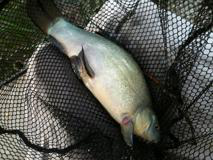

In [0]:
img = PIL.Image.open(img_fn)
img

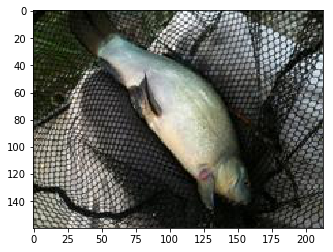

In [0]:
plt.imshow(img)

In [0]:
import numpy 

# the image is 160 X 213 with 3 color channels (e.g colourful)
imga = numpy.array(img)
imga.shape

(160, 213, 3)

As we can see, the PIL library opens the images and returns bytes, ints between 0 - 255 (0 for comeplete darkness, 255 for complete white)

In [0]:
imga[:10, :10, 0]

array([[ 31,  31,  26,  13, ...,   1,   9,  10,   4],
       [ 50,  33,  13,   2, ...,   0,   0,   4,  32],
       [ 32,  16,   0,   0, ...,   4,   0,  10,  51],
       [  0,   0,   1,   2, ...,   7,  10,  21,  39],
       ...,
       [  7,   1,   0,   3, ...,  34,  35,  27,  46],
       [  0,   3,   8,  12, ...,  13,  12,  30,  38],
       [  8,   0,   5,  62, ...,  34,  42,  39,  11],
       [  0,  19,  72, 114, ...,  64,  49,  37,  40]], dtype=uint8)

In [0]:
# lets take a list of image files from the mimetypes library
image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))

In [0]:
' '.join(image_extensions)

'.ief .jp2 .svg .crw .jng .art .gif .pat .erf .psd .ico .jpe .pbm .nef .orf .pnm .png .xbm .ppm .jpf .bmp .ras .svgz .jpm .jpx .wbmp .tif .pcx .jpg2 .cdt .cdr .cr2 .xpm .jpeg .cpt .rgb .tiff .djvu .pgm .djv .xwd .jpg'

In [0]:
# we want to check which extention do the images in imageNet have. As in real imageNet there are 1.3 milion imags, we have to do it fast.
# the fastest way to check if something is in a list, is turn it into a set. Setify makes sure something is a list, if its not, its turns it into a list and the list into a set
def setify(o):
  return o if isinstance(0, set) else set(listify(o))

In [0]:
# lets test to see that this is working as expected
test_eq(setify('aa'), {'aa'})
test_eq(setify(['aa',1]), {'aa',1})
test_eq(setify(None), set())
test_eq(setify(1), {1})
test_eq(setify({1}), {1})

In [0]:
# a function that goes through all the files
def _get_files(p, fs, extensions=None):
  # allows you to insert a string or a path object to your liking
  p = Path(p)
  # make sure the file does not start with a dot, as it might be an operating system's file
  res = [p/f for f in fs if not f.startswith('.')
        # making sure a specific extension wasn't specified and that the extension is in our list of extensions
        and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
  return res

In [0]:
# path_tench is a folder of tenches (fishes) with images.
path_tench.ls()[:3]

[PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00021740.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00037834.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00017472.JPEG')]

In [0]:
# this is an example for fetching hte images (and presenting 3) in path_tench
t = [o.name for o in os.scandir(path_tench)]
t = _get_files(path, t, extensions=image_extensions)
t[:3]

[PosixPath('/root/.fastai/data/imagenette-160/ILSVRC2012_val_00021740.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/ILSVRC2012_val_00037834.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/ILSVRC2012_val_00017472.JPEG')]

In [0]:
def get_files(path, extensions=None, recurse=False, include=None):
    path = Path(path)
      # make sure extensions is a set
    extensions = setify(extensions)
      # lower everything in the set so it maches the extensions given by the library
    extensions = {e.lower() for e in extensions}
      # in case of a folder inside of a folder that contains files
    if recurse:
        res = []
    # p - dirpath
    # d - dirname
    # f - filenames
        for i,(p,d,f) in enumerate(os.walk(path)): # returns (dirpath, dirnames, filenames)
            if include is not None and i==0: d[:] = [o for o in d if o in include]
           # take all the files that are in the included folders, as long as it doesn't start with a dot.
            else:
              d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
        return res
    else:
          # scandir is a python wrapper of a C API, so its re ally fast
        f = [o.name for o in os.scandir(path) if o.is_file()]
        return _get_files(path, f, extensions)

In [0]:
# this is how it works
get_files(path_tench, image_extensions)[:3]

[PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00021740.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00037834.JPEG'),
 PosixPath('/root/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00017472.JPEG')]

In [0]:
# we have 13k images
all_fns = get_files(path, image_extensions, recurse=True)
len(all_fns)

13394

Takes us 80 ms to fetch 13k images. As mentioned, scandir and walk are super fast

In [0]:
%timeit -n 10 get_files(path, image_extensions, recurse=True)

10 loops, best of 3: 81.1 ms per loop


ItemList will fetch the files using the get_files function, will turn it over to ItemList for more comfortable access and better representation and will activate compose on it. Compose basically says: take this item and this function by order, activate a function, return the post function item and do another function on this new value

In [0]:
def compose(x, funcs, *args, order_key='_order', **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    for f in sorted(listify(funcs), key=key): x = f(x, **kwargs)
    return x

class ItemList(ListContainer):
    def __init__(self, items, path='.', tfms=None):
        super().__init__(items)
        self.path,self.tfms = Path(path),tfms

    def __repr__(self): return f'{super().__repr__()}\nPath: {self.path}'
    
    def new(self, items, cls=None):
        if cls is None: cls=self.__class__
        return cls(items, self.path, tfms=self.tfms)
    
    def  get(self, i): return i
    def _get(self, i): return compose(self.get(i), self.tfms)
    
    # when we index into itemList, __getitem__ is called. The index gets transferred to the super class, which is ListContainer. Listcontainer will return either an item
    # if we gave it one file, or a list, if we gave it a list and then call self._res on the file/s. That activates the _get function which activates get on the image.
    # This time its the get of the class actually running all of this, which is ItemList, so it does PIL.Image.open - opens the image. And in addition it will run the func tfms
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        if isinstance(res,list): return [self._get(o) for o in res]
        return self._get(res)

class ImageList(ItemList):
    @classmethod
    def from_files(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        if extensions is None: extensions = image_extensions
          # this gets returned as "items" in ItemList (super class)
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn): return PIL.Image.open(fn)

Something that happens often is that you try to upload a mini batch of images. One of those images is black and white, which means it only has 1 color axis (not 3) and so PIL returns just the height and width. As other images has 3 color channels, it doesn't fit and you can't fit all on the same batch. This will throw an error. A convinient way to deal with this issue is create a transform class/function that takes all images and turn into RGB, making the black & white images fit to what we need

In [0]:
# two ways of doing the same, the class could perhaps be more comfortable as it introduces order which can be helpful

class Transform():
  _order: 0
    
class MakeRGB(Transform):
  def __call__(self, item):
    return item.convert('RGB')
  
def make_rgb(item):
  return item.convert('RGB')

In [0]:
il = ImageList.from_files(path, tfms=make_rgb)

In [0]:
# ItemList inherits from listContainer which has __repr__, which is why we see a good representation of things here
il

ImageList (13394 items)
[PosixPath('/root/.fastai/data/imagenette-160/train/n02979186/n02979186_25404.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n02979186/n02979186_9415.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n02979186/n02979186_745.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n02979186/n02979186_20577.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n02979186/n02979186_10111.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n02979186/n02979186_1587.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n02979186/n02979186_25159.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n02979186/n02979186_1783.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n02979186/n02979186_13427.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n02979186/n02979186_4754.JPEG')...]
Path: /root/.fastai/data/imagenette-160

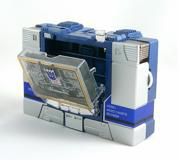

In [0]:
# indexing to an image activates the __getitem__ method declared in the super class and so we just see the representation
img = il[0]
img

#### Splitting to valdiation

In [0]:
# file name. What comes after the last '/' is the file name. '/' before that is the parent. '/' before that is the grandparent.
fn = il.items[0]
fn

PosixPath('/root/.fastai/data/imagenette-160/train/n02979186/n02979186_25404.JPEG')

In [0]:
# parent of a parent is the grandparent, which according to how our DS is built, its the train/val indication
fn.parent.parent.name

'train'

In [0]:
# split the folders by the "gradnfather", valid/train. Again this is based on this DS structure, other structures would need modifications
def grandparent_splitter(fn, valid_name='valid', train_name='train'):
  gp = fn.parent.parent.name
  return True if gp == valid_name else False if gp == train_name else None

# put training files to training and validation files to validation
def split_by_func(ds, f):
  items = ds.items
  mask = [f(o) for o in items]
  train = [o for o,m in zip(items, mask) if m == False]
  valid = [o for o,m in zip(items, mask) if m == True]
  return train, valid

In [0]:
splitter = partial(grandparent_splitter, valid_name='val')

In [0]:
%time train, valid = split_by_func(il, splitter)

CPU times: user 54.6 ms, sys: 1.95 ms, total: 56.5 ms
Wall time: 59.8 ms


In [0]:
# 40 ms later, we get the split. * this currently does not allow us to decide on the percentage of seperation as we would maybe want, it seperates by the structure of the DS
len(train), len(valid)

(12894, 500)

In [0]:
# This is way too small for validation in my opinion. I would want something between 2.5/5 times "better" ratio in favor of validation
500 / 12894

0.03877772607414301

Let's turn this into a class for better convienience

In [0]:
class SplitData():
  def __init__(self, train, valid):
    self.train = train
    self.valid = valid
    
  def __getattr__(self, k):
    return getattr(self.train, k)
  
  @classmethod
  # new of il.new is a part of the itemList class. The idea is that we want to get back the item list of the same type we gave it (il) which in this case is imageList. 
  # itemList uses self.__class__ to determine the type (class) of the item and do the functions according to this classes's methods. So now if we give it a list of items
  # made from class x, it's going to return a list made as class x defined
  def split_by_func(cls, il, f):
    lists = map(il.new, split_by_func(il, f))
    return cls(*lists)
  
  def __repr__(self): return f'{self.__class__.__name__}\nTrain: {self.train}\nValid: {self.valid}\n'

In [0]:
 sd = SplitData.split_by_func(il, splitter)

In [0]:
sd

SplitData
Train: ImageList (12894 items)
[PosixPath('/root/.fastai/data/imagenette-160/train/n02979186/n02979186_25404.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n02979186/n02979186_9415.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n02979186/n02979186_745.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n02979186/n02979186_20577.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n02979186/n02979186_10111.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n02979186/n02979186_1587.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n02979186/n02979186_25159.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n02979186/n02979186_1783.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n02979186/n02979186_13427.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n02979186/n02979186_4754.JPEG')...]
Path: /root/.fastai/data/imagenette-160
Valid: ImageList (500 items)
[PosixPath('/root/.fastai/data/imagenette-

#### Labeling

For labeling we are going to use proccessors. A processor is a transformation being done at initialization with some state. We are going to learn something about the training data, in this case - creating a vocabulary for the different labels and then apply the same labels to the validation. For example if we decide tench is 0, house is 1 and guns are 2, we decide that using the training set and apply the **same** labels on the validation set

In [0]:
from collections import OrderedDict

def uniqueify(x, sort=False):
  res = list(OrderedDict.fromkeys(x).keys())
  if sort: res.sort()
  return res

In [0]:
class Processor(): 
    def process(self, items): return items

class CategoryProcessor(Processor):
    def __init__(self): self.vocab=None
    
    def __call__(self, items):
        # The vocab is defined on the first use.
        if self.vocab is None:
          # create the vocab
            self.vocab = uniqueify(items)
            # create an object to string mapping
            self.otoi  = {v:k for k,v in enumerate(self.vocab)}
            # process what ever is given according to the mapping we just made
        return [self.proc1(o) for o in items]
    def proc1(self, item):  return self.otoi[item]
    
    # Allows us for example to print out the inferences, using the right label in a specific index
    def deprocess(self, idxs):
        assert self.vocab is not None
        return [self.deproc1(idx) for idx in idxs]
    def deproc1(self, idx): return self.vocab[idx]

In [0]:
def parent_labeler(fn): return fn.parent.name

def _label_by_func(ds, f, cls=ItemList): return cls([f(o) for o in ds.items], path=ds.path)

#This is a slightly different from what was seen during the lesson,
#   we'll discuss the changes in lesson 11
class LabeledData():
    def process(self, il, proc): return il.new(compose(il.items, proc))

    def __init__(self, x, y, proc_x=None, proc_y=None):
        self.x,self.y = self.process(x, proc_x),self.process(y, proc_y)
        self.proc_x,self.proc_y = proc_x,proc_y
        
    def __repr__(self): return f'{self.__class__.__name__}\nx: {self.x}\ny: {self.y}\n'
    def __getitem__(self,idx): return self.x[idx],self.y[idx]
    def __len__(self): return len(self.x)
    
    def x_obj(self, idx): return self.obj(self.x, idx, self.proc_x)
    def y_obj(self, idx): return self.obj(self.y, idx, self.proc_y)
    
    def obj(self, items, idx, procs):
        isint = isinstance(idx, int) or (isinstance(idx,torch.LongTensor) and not idx.ndim)
        item = items[idx]
        for proc in reversed(listify(procs)):
            item = proc.deproc1(item) if isint else proc.deprocess(item)
        return item

    @classmethod
    def label_by_func(cls, il, f, proc_x=None, proc_y=None):
        return cls(il, _label_by_func(il, f), proc_x=proc_x, proc_y=proc_y)

def label_by_func(sd, f, proc_x=None, proc_y=None):
    train = LabeledData.label_by_func(sd.train, f, proc_x=proc_x, proc_y=proc_y)
    valid = LabeledData.label_by_func(sd.valid, f, proc_x=proc_x, proc_y=proc_y)
    return SplitData(train,valid)

In [0]:
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

In [0]:
# this is the mapping, each folder gets a unique class (number)
ll.train.proc_y.otoi

{'n01440764': 4,
 'n02102040': 2,
 'n02979186': 0,
 'n03000684': 8,
 'n03028079': 1,
 'n03394916': 7,
 'n03417042': 3,
 'n03425413': 9,
 'n03445777': 6,
 'n03888257': 5}

In [0]:
# train and validation using the same processor
assert ll.train.proc_y is ll.valid.proc_y

In [0]:
# Nice representations, could be somewhat annoying that we don't see the names of the labels (only 0,0,0,0,0,0)
ll

SplitData
Train: LabeledData
x: ImageList (12894 items)
[PosixPath('/root/.fastai/data/imagenette-160/train/n02979186/n02979186_25404.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n02979186/n02979186_9415.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n02979186/n02979186_745.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n02979186/n02979186_20577.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n02979186/n02979186_10111.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n02979186/n02979186_1587.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n02979186/n02979186_25159.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n02979186/n02979186_1783.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n02979186/n02979186_13427.JPEG'), PosixPath('/root/.fastai/data/imagenette-160/train/n02979186/n02979186_4754.JPEG')...]
Path: /root/.fastai/data/imagenette-160
y: ItemList (12894 items)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.

#### Transformations

We can't put PIL objects in the model, we need tensors, so lets transform it to tensors

In [0]:
ll.train[0]

(<PIL.Image.Image image mode=RGB size=178x160 at 0x7F20E6D535C0>, 0)

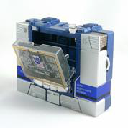

In [0]:
# ll[0] is the first batch, aother [0] would indicate we want the x value and not y. You can replace with y to see the label
# ll.train[0][1]

# We need images in a rectangular form (height X width same size)
ll.train[0][0].resize((128,128))

In [0]:
 class ResizeFixed(Transform):
    # this has to happen after the conversion to RGB
    _order = 10
    def __init__(self, size):
      # if an int is given, turn into a tuple with the same init in both places
      if isinstance(size, int):
        size = (size, size)
        self.size = size
        
    def __call__(self, item):
      return item.resize(self.size, PIL.Image.BILINEAR)
    
def to_byte_tensor(item):
  # torch vision way of converting to torches
  res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
  w, h = item.size
  # permute just puts the channel first (it's 2 because PIL puts it last)
  return res.view(h, w, -1).permute(2, 0, 1)
to_byte_tensor._order = 20

def to_float_tensor(item):
  # make sure what we get is between 0 and 255
  return item.float().div_(255.)
# Do this last
to_float_tensor._order=30 
    

In [0]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, splitter)
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

In [0]:
def show_image(im, figsize=(3,3)):
  plt.figure(figsize=figsize)
  plt.axis('off')
  plt.imshow(im.permute(1,2,0))

In [0]:
x,y = ll.train[0]
x.shape

torch.Size([3, 128, 128])

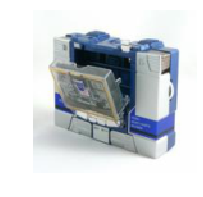

In [0]:
show_image(x)

#### DataBunch
We have tensors that are floats and are all the same size, so we can put it into a model

In [0]:
bs = 64 

In [0]:
train_dl, valid_dl = get_dls(ll.train, ll.valid, bs, num_workers=0)

In [0]:
x, y = next(iter(train_dl))

We've got a databunch of 64 X 3 X 128 X 128

In [0]:
x.shape

torch.Size([64, 3, 128, 128])

'n03445777'

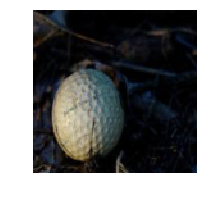

In [0]:
show_image(x[0])
# corresponding vocab
ll.train.proc_y.vocab[y[0]]

In [0]:
# Entire bs y's so labels for 64 items
y

tensor([6, 0, 5, 6, 3, 9, 7, 5, 2, 4, 7, 1, 3, 6, 3, 5, 4, 4, 3, 4, 0, 6, 3, 9,
        6, 3, 5, 3, 3, 6, 5, 6, 0, 8, 9, 6, 7, 4, 8, 8, 3, 8, 7, 8, 8, 9, 9, 3,
        9, 1, 7, 0, 3, 8, 6, 5, 4, 7, 2, 8, 9, 4, 1, 2])

In [0]:
class DataBunch():
    def __init__(self, train_dl, valid_dl, c_in=None, c_out=None):
        self.train_dl,self.valid_dl,self.c_in,self.c_out = train_dl,valid_dl,c_in,c_out

    @property
    def train_ds(self): return self.train_dl.dataset

    @property
    def valid_ds(self): return self.valid_dl.dataset

In [0]:
# Normally we'd just go back and put this into our SplitData class. I'm leaving this here to show a way to put a new function into an existing class. This is definitely not a best
# practice as it might be confusing, so it stays here for educational purposes. I find those kind of techniques useful with iterating and experimenting faster

def databunchify(sd, bs, c_in=None, c_out=None, **kwargs):
    dls = get_dls(sd.train, sd.valid, bs, **kwargs)
    return DataBunch(*dls, c_in=c_in, c_out=c_out)

SplitData.to_databunch = databunchify

Let's look at the entire process so far

In [0]:
# get the data and store to path
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
# do the first transformations
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

# create the imageList
il = ImageList.from_files(path, tfms=tfms)
# split to valid/training
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
# label according to split
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
# create a dataBunch
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

#### Model

In [0]:
# get the callbacks
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback]

In [0]:
# normalize by 3 channels
m,s = x.mean((0,2,3)).cuda(),x.std((0,2,3)).cuda()
m,s

(tensor([0.4201, 0.4230, 0.4047], device='cuda:0'),
 tensor([0.2929, 0.2824, 0.2975], device='cuda:0'))

In [0]:
def normalize_chan(x, mean, std):
    return (x-mean[...,None,None]) / std[...,None,None]

_m = tensor([0.47, 0.48, 0.45])
_s = tensor([0.29, 0.28, 0.30])
norm_imagenette = partial(normalize_chan, mean=_m.cuda(), std=_s.cuda())

In [0]:
# cbfs.append(partial(BatchTransformXCallback, norm_imagenette))
cbfs.append(partial(BatchTransformXCallback, norm_imagenette))


In [0]:
# nfs = [64,64,128,256]
nfs = [64,64,128,256]


Lets create a model bsase don the Bag of Tricks paper
http://openaccess.thecvf.com/content_CVPR_2019/papers/He_Bag_of_Tricks_for_Image_Classification_with_Convolutional_Neural_Networks_CVPR_2019_paper.pdf

In [0]:
import math
def prev_pow_2(x): return 2**math.floor(math.log2(x))

def get_cnn_layers(data, nfs, layer, **kwargs):
    def f(ni, nf, stride=2): return layer(ni, nf, 3, stride=stride, **kwargs)
    l1 = data.c_in
    # As the kernel is a 3x3 we're getting 3x3xc_in coming in. We wouldn't want more of this coming out, as we want the kernel to extract the important stuff and save room, not spend more.
    # Hence, for the output we can use the next biggest number (rounded down) which is a power of 2 (*see example below). This makes sure we won't use more space than given.
    # for example, input of 64 * 3 * 3 = 576. We will spit out, 512
    l2 = prev_pow_2(l1*3*3)
    layers =  [f(l1  , l2  , stride=1),
               # next layers is just the same, multiplied by 2
               f(l2  , l2*2, stride=2),
               f(l2*2, l2*4, stride=2)]
    # And the rest of the model (non convolutional layers are just what we specified)
    nfs = [l2*4] + nfs
    layers += [f(nfs[i], nfs[i+1]) for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), Lambda(flatten), 
               nn.Linear(nfs[-1], data.c_out)]
    return layers

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [0]:
data.c_in

3

In [0]:
# math.log2(x) returns the power in which u need to raise 2, to get to this number (a.k.a, log2).
# As this returns the biggest rounded power of 2, 27 gives 16, 32 gives 32, anything up to 63 will still give 32, and 64 will give 64

2**math.floor(math.log2(27)) # 16
2**math.floor(math.log2(32)) #32 
# 40 * 3 * 3 = 360
2**math.floor(math.log2(40*3*3)) #256 

256

In [0]:
sched = combine_scheds([0.3,0.7], [sched_cos(0.1,0.3)])

In [0]:
learn,run = get_learn_run(nfs, data, 0.2, conv_layer, cbs=cbfs)

With this pretty basic model we get to a nice prediction on a non trivial task. Let's continue improving it

In [0]:
%time run.fit(5, learn)

train: [1.7121117380176827, tensor(0.4095, device='cuda:0')]
valid: [1.478362548828125, tensor(0.4820, device='cuda:0')]
train: [1.262985160854855, tensor(0.5823, device='cuda:0')]
valid: [1.1689422607421875, tensor(0.6000, device='cuda:0')]
train: [1.0331528351364976, tensor(0.6576, device='cuda:0')]
valid: [1.58275927734375, tensor(0.5420, device='cuda:0')]
train: [0.8622354631999379, tensor(0.7175, device='cuda:0')]
valid: [1.0226614379882812, tensor(0.6660, device='cuda:0')]
train: [0.7056588820381573, tensor(0.7687, device='cuda:0')]
valid: [1.10462841796875, tensor(0.6380, device='cuda:0')]
CPU times: user 16.5 s, sys: 9.7 s, total: 26.2 s
Wall time: 1min 46s


#### Optimizers

In [0]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs=128

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

In [0]:
nfs = [32,64,128,256]

In [0]:
cbfs = [partial(AvgStatsCallback,accuracy), CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [0]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [0]:
run.fit(1, learn)

train: [1.7864318251221498, tensor(0.3787, device='cuda:0')]
valid: [1.537991455078125, tensor(0.4880, device='cuda:0')]


Pytorch's optimizer is a dictionary holding hyper parameters and references to the model's parameters (with respect to parameters's groups). It has a step method that updates the gradients and a zero_grad method to detach and zero gradients so the calculation does not accumulate, and we get the right score.

We will build this from scratch, with some additional flexibility

---------------------------------

We'll first start with the idea of param groups. We want to be able to train different parts of the model wit differnet hyper parameters (for example, 90% of the model is lr = 0.01, last 10% is lr=0.1). To do so we need to give the optimizer a few sets of hyper parameters, or better said, a few lists. We are going to provide a list of lists, where each list contains hyper parameters matching its respective params group

In [0]:
class Optimizer():
  def __init__(self, params, steppers, **defaults):
    self.param_groups = list(params)
    # if the first item in param_group is not a list, make it a list
    if not isinstance(self.param_groups[0], list):
      self.param_groups = [self.param_groups]
      # creates a dictionary (of hypyter parameters) for every list in the param_group. **dictionary makes sure each dicitonary gets a different reference in memory
    self.hypers = [{**defaults} for p in self.param_groups]
    self.steppers = listify(steppers)
       
  def grad_params(self):
    # helper function to go through every parameter in every parameter_group so we zero_grad it all
        return [(p,hyper) for pg,hyper in zip(self.param_groups,self.hypers)
            for p in pg if p.grad is not None]
  
  def zero_grad(self):
    for p,hyper in self.grad_params():
      p.grad.detach_()
      p.grad.zero_()
      
  def step(self):
    for p,hyper in self.grad_params():
      compose(p, self.steppers, **hyper)

In [0]:
# regular sgd optimizer, nothing sepcial
# **kwargs here is the **hyper received from step above
def sgd_step(p, lr, **kwargs):
  p.data.add_(-lr * p.grad.data)
  return p

In [0]:
opt_func = partial(Optimizer, steppers=[sgd_step])

In [0]:
# refactoring of the Recorder and LR_Find callbacks to match our new optimizer. 

class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[]

    def after_batch(self):
        if not self.in_train: return
        # hypers is added here on opt, as this is the place we store the hyper parameters dictionary
        self.lrs.append(self.opt.hypers[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)
        
    def plot(self, skip_last=0):
        losses = [o.item() for o in self.losses]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(self.lrs[:n], losses[:n])

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs):
        self.pname,self.sched_funcs = pname,listify(sched_funcs)

    def begin_batch(self): 
        if not self.in_train: return
        fs = self.sched_funcs
        if len(fs)==1: fs = fs*len(self.opt.param_groups)
        pos = self.n_epochs/self.epochs
        for f,h in zip(fs,self.opt.hypers): h[self.pname] = f(pos)
            
class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter,self.min_lr,self.max_lr = max_iter,min_lr,max_lr
        self.best_loss = 1e9
        
    def begin_batch(self): 
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.hypers: pg['lr'] = lr
            
    def after_step(self):
        if self.n_iter>=self.max_iter or self.loss>self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

In [0]:
# This is a good example for what we've been building this for. Here the training gets a different lr in different times of training
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])

In [0]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback, Recorder,
        partial(ParamScheduler, 'lr', sched)]

In [0]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs, opt_func=opt_func)

In [0]:
%time run.fit(1, learn)

train: [1.7511224333992554, tensor(0.3958, device='cuda:0')]
valid: [1.3160546875, tensor(0.5540, device='cuda:0')]
CPU times: user 3.81 s, sys: 2.73 s, total: 6.54 s
Wall time: 22.3 s


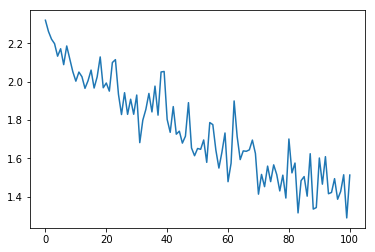

In [0]:
run.recorder.plot_loss()

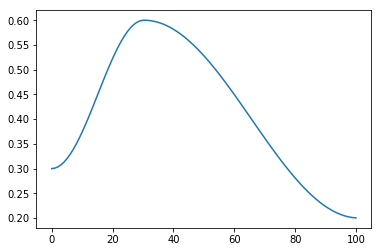

In [0]:
# good visualization of the changes in lr
run.recorder.plot_lr()

Adding weight decay. Weight decay (wd) is used to help us generlaize better. There's always a risk of the model learning the data so well that it only knows the data itself and doesn't really understand the features that makes the data. Its as if the model is memorizing, and not really understanding. Therefor when new data arrives, it doesn't do a good job predicting whats needed as the weights are not good enough. This is overfitting issue.

To combat this, we are using wd. We use the L2 regularization formula and basically we add (wd/2)*weights^2 (wd being a hyper parameter) to the loss function. This incentivises the loss to use as small weights as possible, as its "paying" for additional weights. As numbers become super high and calculation unstable, we can alternatively just add wd * weight to the gradient of the weights. 

*this works well with SGD, as Adam, RMSProp etc are somewhat different, we do it a bit differently

In [0]:
# option A

def weight_decay(p, lr, wd, **kwargs):
  p.data.mul_(1 - lr*wd)
  return p
weight_decay._defaults = dict(wd=0.)

In [0]:
# option B

def l2_reg(p, lr, wd, **kwargs):
  # this add_ in pytorch axctually does p.data * wd and only then adds it to p.grad.data
  p.grad.data.add_(wd, p.data)
  return p
# we're adding a default "state" to the function with wd being 0. Its easier then turning it off everytime we dont want it, so its 0 by default and we can change it anytime we want to use
l2_reg._defaults = dict(wd=0.)

In [0]:
# helper function that goes through the hyper parameters provided by default, if the specific hypter parameter is not in the defaults, but IS requested in the function,
# add it to the defaults of this specific train

def maybe_update(os, dest, f):
    for o in os:
      for k,v in f(o).items():
        if k not in dest: dest[k] = v

def get_defaults(d):
  return getattr(d, '_defaults', {})

In [0]:
# same exact optimizer, just with maybe_update method. The reason this is maybe, is because if there are no new hypter parameters requested, there will be no update

class Optimizer():
    def __init__(self, params, steppers, **defaults):
        self.steppers = listify(steppers)
        maybe_update(self.steppers, defaults, get_defaults)
        # might be a generator
        self.param_groups = list(params)
        # ensure params is a list of lists
        if not isinstance(self.param_groups[0], list): self.param_groups = [self.param_groups]
        self.hypers = [{**defaults} for p in self.param_groups]

    def grad_params(self):
        return [(p,hyper) for pg,hyper in zip(self.param_groups,self.hypers)
            for p in pg if p.grad is not None]

    def zero_grad(self):
        for p,hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()

    def step(self):
        for p,hyper in self.grad_params(): compose(p, self.steppers, **hyper)

In [0]:
sgd_opt = partial(Optimizer, steppers=[weight_decay, sgd_step])

In [0]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs, opt_func=sgd_opt)

In [0]:
model = learn.model

In [0]:
# take the optimizer with lr of -.1
opt = sgd_opt(model.parameters(), lr=0.1)
# check that there's a wd of 0 as it is default and we didn't change it, and also that lr is 0.1 and thats what we requested. Both pass, works fine
test_eq(opt.hypers[0]['wd'], 0.)
test_eq(opt.hypers[0]['lr'], 0.1)

In [0]:
# Overriding the wd, works as well
opt = sgd_opt(model.parameters(), lr=0.1, wd=1e-4)
test_eq(opt.hypers[0]['wd'], 1e-4)
test_eq(opt.hypers[0]['lr'], 0.1)

In [0]:
cbfs = [partial(AvgStatsCallback,accuracy), CudaCallback]

In [0]:
learn,run = get_learn_run(nfs, data, 0.3, conv_layer, cbs=cbfs, opt_func=partial(sgd_opt, wd=0.01))

In [0]:
run.fit(1, learn)


train: [1.7848064930878704, tensor(0.3821, device='cuda:0')]
valid: [1.66558544921875, tensor(0.4180, device='cuda:0')]


#### Momentum
Momentum will obligate us to know what had happened in the previous step for every activation. We will do this with a "state" added to the class

In [0]:
class StatefulOptimizer(Optimizer):
  def __init__(self, params, steppers, stats=None, **defaults):
    self.stats = listify(stats)
    maybe_update(self.stats, defaults, get_defaults)
    super().__init__(params, steppers, **defaults)
    self.state = {}
    
  def step(self):
    # look at all our parameters
    for p, hyper in self.grad_params():
      # if this specific parameter p does not appear, then create it
      if p not in self.state:
        self.state[p] = {}
        # update p if needed
        maybe_update(self.stats, self.state[p], lambda o: o.init_state(p))
      state = self.state[p]
      for stat in self.stats:
        # update the parameter
        state = stat.update(p, state, **hyper)
        # call compose on the parameter, the difference is that this time we also give the state, as the calculation depends on it
      compose(p, self.steppers, **state, **hyper)
      self.state[p] = state

In [0]:
# This is a blueprint for stats. Every stat will do 2 things: at first initialize the the state, and second - updating the respective stat's value

class Stat():
  _defaults = {}
  def init_state(self, p):
    raise NotImplementedError
  def update(self, p, state, **kwargs):
    raise NotImplementedError

In [0]:
# # Example of stat. First we initialize the average gradient so we can work with it. Second we update it so the Optimizer knows what's the current situation
# # and so it can do the momentum

class AverageGrad(Stat):
    _defaults = dict(mom=0.9)

    def init_state(self, p): return {'grad_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, mom, **kwargs):
        state['grad_avg'].mul_(mom).add_(p.grad.data)
        return state

In [0]:
def momentum_step(p, lr, grad_avg, **kwargs):
  p.data.add_(-lr, grad_avg)
  return p

In [0]:
sgd_mom_opt = partial(StatefulOptimizer, steppers=[momentum_step, weight_decay], stats=AverageGrad(), wd=0.01)

In [0]:
learn,run = get_learn_run(nfs, data, 0.3, conv_layer, cbs=cbfs, opt_func=sgd_mom_opt)

In [0]:
# 20 seconds
%time run.fit(1, learn)

train: [1.8041896000562276, tensor(0.3730, device='cuda:0')]
valid: [1.7277916259765624, tensor(0.4380, device='cuda:0')]
CPU times: user 3.12 s, sys: 2.17 s, total: 5.29 s
Wall time: 21.6 s


Let's experiment a bit with momentum to see how it behaves and improve it

In [0]:
# some random data. 200 points between -4 and 4
x = torch.linspace(-4, 4, 200)
# 200 random numbers with an average of 0.3
y = torch.randn(200) + 0.3
# some betas to act as momntum
betas = [0.5, 0.7, 0.9, 0.99]

In [0]:
def plot_mom(f):
    _,axs = plt.subplots(2,2, figsize=(12,8))
    for beta,ax in zip(betas, axs.flatten()):
        ax.plot(y, linestyle='None', marker='.')
        avg,res = None,[]
        for i,yi in enumerate(y):
            avg,p = f(avg, beta, yi, i)
            res.append(p)
        ax.plot(res, color='red')
        ax.set_title(f'beta={beta}')

As we can see, if the numbers are even a bit biased to some direction (which real data probably will be, its not random) a high momentum pushes us way too high as the previous step always has a big say. * to see how it works with real random data, run the experiment below the graphs. Its the same, just without the + 0.3 which makes it actually random

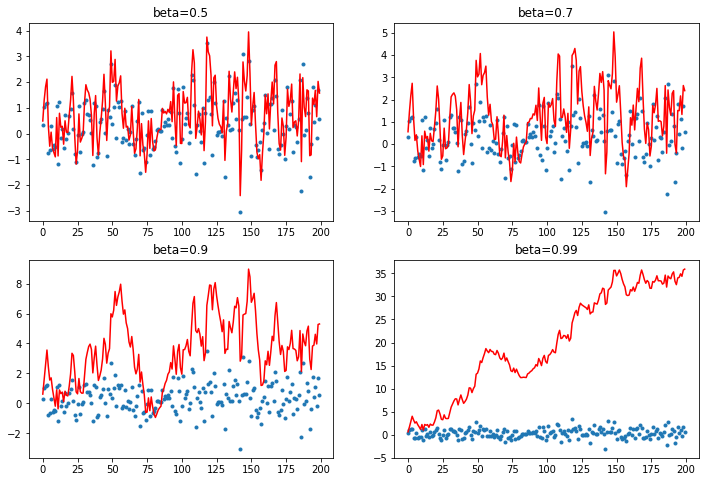

In [0]:
def mom1(avg, beta, yi, i): 
    if avg is None: avg=yi
    res = beta*avg + yi
    return res,res
plot_mom(mom1)

In [0]:
# run this to see momentum acting on random data. * Note that real world data will probably not be random though

# x = torch.linspace(-4, 4, 200)
# y = torch.randn(200)
# betas = [0.5, 0.7, 0.9, 0.99]


# def mom1(avg, beta, yi, i): 
#     if avg is None: avg=yi
#     res = beta*avg + yi
#     return res,res
# plot_mom(mom1)

So lets improve on this a bit, by giving the current step a bit of a higher vote in the decision

In [0]:
# exponentially weighted moving average (a.k.a lerp in pytorch)
def ewma(v1, v2, beta): return beta * v1 + (1-beta) * v2

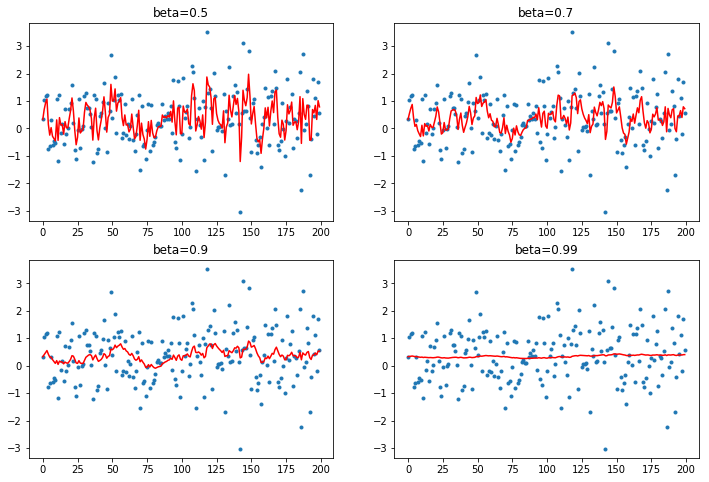

In [0]:
def mom2(avg, beta, yi, i):
    if avg is None: avg=yi
    avg = ewma(avg, yi, beta)
    return avg, avg
plot_mom(mom2)

In [0]:
# Lets look at data that has a strong bias in the direction. Its really not random
y = 1 - (x/3) ** 2 + torch.randn(200) * 0.1

In [0]:
# outlier
y[0]=0.5

With a low momentum we're fine (first point is the outlier). But, with a high momentum, its not working well at all and the reason is - that the curve is super biased by the beggining (as mom = 0.99) which does not accurately represents the following data

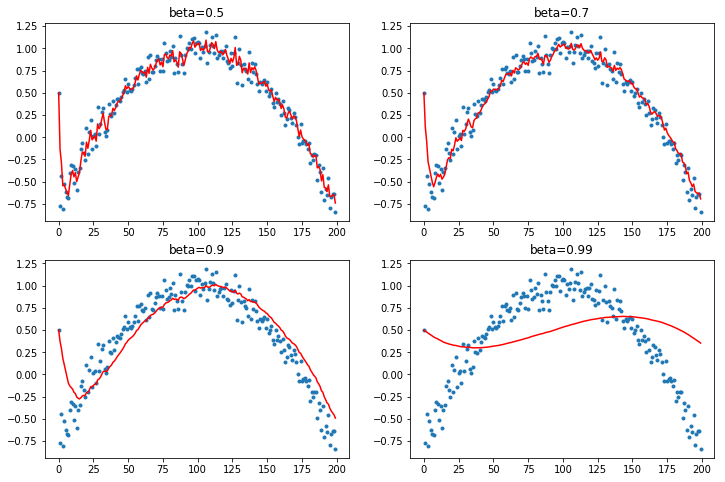

In [0]:
plot_mom(mom2)

To improve on this, we are going to use debiasing, which will somewhat cancel out the bias of the calculation, giving better results. We doing this with debiasing. If we have a momentum of 0.9, so the first step's calculation is 0.9 * 0 ( as we always start with zero) and 0.1 * what we just got. This means, the true value will be 10 times behind (it only got 10% of the votes). So, what we do is just divide the value by (1-mom)^number of steps, so in this case (1-0.9)^1. As diving by 0.1 is the same as multiplying by 10, we get the correct value

-------------

And - its much better !. We can also see why 0.9 is a good starting point, it fits the data nicely. Its an hyper parameter of course, so you can change it to your needs, but as I said, good first test

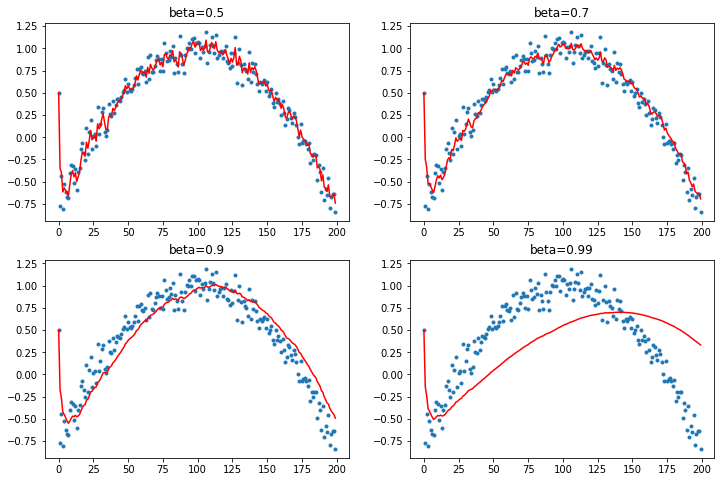

In [0]:
def mom3(avg, beta, yi, i):
    if avg is None: avg=0
    avg = ewma(avg, yi, beta)
    # we do the explained above. diving by 1-mom (here named beta) by the number of steps
    return avg, avg/(1-beta**(i+1))
plot_mom(mom3)

We now have everything we need to create our better optimizer - Adam

In [0]:
class AverageGrad(Stat):
  _defaults = dict(mom=0.9)
  
  def __init__(self, dampening:bool=False): self.dampening = dampening
    # starts with zero gradients
  def init_state(self, p): return {'grad_avg': torch.zeros_like(p.grad.data)}
  def update(self, p, state, mom, **kwargs):
    # dampening depending on choice. Dampening here is reducing the momentum from 1
    state['mom_damp'] = 1-mom if self.dampening else 1
    # gradient's average times momentum + the dampened momentum times the gradient (previously indicated as (1-beta) * v2)
    state['grad_avg'].mul_(mom).add_(state['mom_damp'], p.grad.data)
    return state
    

In [0]:
# one small but important difference than the AverageGrad class, we multiplie by p.grad.data squared
class AverageSqrGrad(Stat):
    _defaults = dict(sqr_mom=0.99)
    
    def __init__(self, dampening:bool=True): self.dampening=dampening
    def init_state(self, p): return {'sqr_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, sqr_mom, **kwargs):
        state['sqr_damp'] = 1-sqr_mom if self.dampening else 1.
        state['sqr_avg'].mul_(sqr_mom).addcmul_(state['sqr_damp'], p.grad.data, p.grad.data)
        return state

In [0]:
# Keep track of the step, to know what to divide on. Starting with 0 and incrementing
class StepCount(Stat):
  def init_state(self, p): return {'step': 0}
  def update(self, p, state, **kwargs):
    state['step'] +=1
    return state

In [0]:
# if we chose to debias, damp = 1 and nothing will change. Its just a helper function to make the code somewhat more readible
def debias(mom, damp, step): return damp * (1 - mom**step) / (1-mom)

In [0]:
# this is the formula of Adam in code.

def adam_step(p, lr, mom, mom_damp, step, sqr_mom, sqr_damp, grad_avg, sqr_avg, eps, **kwargs):
    debias1 = debias(mom,     mom_damp, step)
    debias2 = debias(sqr_mom, sqr_damp, step)
    p.data.addcdiv_(-lr / debias1, grad_avg, (sqr_avg/debias2).sqrt() + eps)
    return p
adam_step._defaults = dict(eps=1e-5)

In [0]:
def adam_opt(xtra_step=None, **kwargs):
    return partial(StatefulOptimizer, steppers=[adam_step,weight_decay]+listify(xtra_step),
                   stats=[AverageGrad(dampening=True), AverageSqrGrad(), StepCount()], **kwargs)

In [0]:
learn,run = get_learn_run(nfs, data, 0.001, conv_layer, cbs=cbfs, opt_func=adam_opt())

In [0]:
%time run.fit(3, learn)

train: [1.7548541836319218, tensor(0.3949, device='cuda:0')]
valid: [1.384966552734375, tensor(0.5400, device='cuda:0')]
train: [1.2488892302136654, tensor(0.5921, device='cuda:0')]
valid: [1.116395263671875, tensor(0.6480, device='cuda:0')]
train: [0.9721718313750581, tensor(0.6874, device='cuda:0')]
valid: [1.0377088623046875, tensor(0.6560, device='cuda:0')]
CPU times: user 9.18 s, sys: 5.51 s, total: 14.7 s
Wall time: 1min 3s


Lamb optimizer new optimizer (papepr came out 24.5.19) - basically ADAM averaged over each layer. I'm not going deep into this as to the time of this writing, I don't understand it well enough, but in large thats the idea. Same as Adam, averging on each layer. https://arxiv.org/pdf/1904.00962.pdf

In [0]:
def lamb_step(p, lr, mom, mom_damp, step, sqr_mom, sqr_damp, grad_avg, sqr_avg, eps, wd, **kwargs):
    debias1 = debias(mom,     mom_damp, step)
    debias2 = debias(sqr_mom, sqr_damp, step)
    r1 = p.data.pow(2).mean().sqrt()
    step = (grad_avg/debias1) / ((sqr_avg/debias2).sqrt()+eps) + wd*p.data
    r2 = step.pow(2).mean().sqrt()
    p.data.add_(-lr * min(r1/r2,10), step)
    return p
lamb_step._defaults = dict(eps=1e-6, wd=0.)

In [0]:
lamb = partial(StatefulOptimizer, steppers=lamb_step, stats=[AverageGrad(dampening=True), AverageSqrGrad(), StepCount()])

In [0]:
learn,run = get_learn_run(nfs, data, 0.003, conv_layer, cbs=cbfs, opt_func=lamb)

In [0]:
# 1 minute
%time run.fit(3, learn)

train: [1.8880859677950985, tensor(0.3489, device='cuda:0')]
valid: [1.588182373046875, tensor(0.4500, device='cuda:0')]
train: [1.3699640457771056, tensor(0.5489, device='cuda:0')]
valid: [1.41262744140625, tensor(0.5100, device='cuda:0')]
train: [1.0907753242787344, tensor(0.6463, device='cuda:0')]
valid: [1.167321044921875, tensor(0.6120, device='cuda:0')]
CPU times: user 17 s, sys: 8.6 s, total: 25.6 s
Wall time: 1min 9s


#### Refactoring Runner
As learn just holds a few items, and runner does the whole job, everytime we train we need to put things into learn, then runner calls those things in learn. This is quite annoying, so lets refactor to merge learn and runner. We'll put learn inside runner, and change the name runner to Learner. Now instead of writing self.learn, we just do self. as its in the same class

In [0]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs=64

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

In [0]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [0]:
nfs = [32]*4

In [0]:
def param_getter(m): return m.parameters()

class Learner():
    def __init__(self, model, data, loss_func, opt_func=sgd_opt, lr=1e-2, splitter=param_getter,
                 cbs=None, cb_funcs=None):
        self.model,self.data,self.loss_func,self.opt_func,self.lr,self.splitter = model,data,loss_func,opt_func,lr,splitter
        self.in_train,self.logger,self.opt = False,print,None
        
        # NB: Things marked "NEW" are covered in lesson 12
        # NEW: avoid need for set_runner
        self.cbs = []
        self.add_cb(TrainEvalCallback())
        self.add_cbs(cbs)
        self.add_cbs(cbf() for cbf in listify(cb_funcs))

    def add_cbs(self, cbs):
        for cb in listify(cbs): self.add_cb(cb)
            
    def add_cb(self, cb):
        cb.set_runner(self)
        setattr(self, cb.name, cb)
        self.cbs.append(cb)

    def remove_cbs(self, cbs):
        for cb in listify(cbs): self.cbs.remove(cb)
            
    def one_batch(self, i, xb, yb):
        try:
            self.iter = i
            self.xb,self.yb = xb,yb;                        self('begin_batch')
            self.pred = self.model(self.xb);                self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb); self('after_loss')
            if not self.in_train: return
            self.loss.backward();                           self('after_backward')
            self.opt.step();                                self('after_step')
            self.opt.zero_grad()
        except CancelBatchException:                        self('after_cancel_batch')
        finally:                                            self('after_batch')

    def all_batches(self):
        self.iters = len(self.dl)
        try:
            for i,(xb,yb) in enumerate(self.dl): self.one_batch(i, xb, yb)
        except CancelEpochException: self('after_cancel_epoch')

    def do_begin_fit(self, epochs):
        self.epochs,self.loss = epochs,tensor(0.)
        self('begin_fit')

    def do_begin_epoch(self, epoch):
        self.epoch,self.dl = epoch,self.data.train_dl
        return self('begin_epoch')

    def fit(self, epochs, cbs=None, reset_opt=False):
        # NEW: pass callbacks to fit() and have them removed when done
        self.add_cbs(cbs)
        # NEW: create optimizer on fit(), optionally replacing existing
        if reset_opt or not self.opt: self.opt = self.opt_func(self.splitter(self.model), lr=self.lr)
            
        try:
            self.do_begin_fit(epochs)
            for epoch in range(epochs):
                self.do_begin_epoch(epoch)
                if not self('begin_epoch'): self.all_batches()

                with torch.no_grad(): 
                    self.dl = self.data.valid_dl
                    if not self('begin_validate'): self.all_batches()
                self('after_epoch')
            
        except CancelTrainException: self('after_cancel_train')
        finally:
            self('after_fit')
            self.remove_cbs(cbs)

    ALL_CBS = {'begin_batch', 'after_pred', 'after_loss', 'after_backward', 'after_step',
        'after_cancel_batch', 'after_batch', 'after_cancel_epoch', 'begin_fit',
        'begin_epoch', 'begin_validate', 'after_epoch',
        'after_cancel_train', 'after_fit'}
    
    def __call__(self, cb_name):
        res = False
        assert cb_name in self.ALL_CBS
        for cb in sorted(self.cbs, key=lambda x: x._order): res = cb(cb_name) and res
        return res

In [0]:
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        #We use the logger function of the `Learner` here, it can be customized to write in a file or in a progress bar
        self.logger(self.train_stats)
        self.logger(self.valid_stats)

In [0]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [0]:
def get_learner(nfs, data, lr, layer, loss_func=F.cross_entropy,
                cb_funcs=None, opt_func=sgd_opt, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return Learner(model, data, loss_func, lr=lr, cb_funcs=cb_funcs, opt_func=opt_func)

In [0]:
learn = get_learner(nfs, data, 0.4, conv_layer, cb_funcs=cbfs)

In [0]:
# working as expected
# takes 20s
%time learn.fit(1)

train: [1.8349317027299519, tensor(0.3592, device='cuda:0')]
valid: [1.66799560546875, tensor(0.4260, device='cuda:0')]
CPU times: user 3.6 s, sys: 1.76 s, total: 5.36 s
Wall time: 21.5 s


#### Add progress bar


We'll add a nice progress bar animation. This has no functionallity, just a nice visualization. It does show though, how easily we can add additional services as this one but also like Tensorflow or different kinds. As we have callbacks all over, we control the entire training flow

In [0]:
import time
from fastprogress import master_bar, progress_bar
from fastprogress.fastprogress import format_time

In [0]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs = 64

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

nfs = [32]*4

In [0]:
# one small difference, see comment below

class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
    
    def begin_fit(self):
        met_names = ['loss'] + [m.__name__ for m in self.train_stats.metrics]
        names = ['epoch'] + [f'train_{n}' for n in met_names] + [
            f'valid_{n}' for n in met_names] + ['time']
        self.logger(names)
    
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        self.start_time = time.time()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    # only difference from our previous AvgStatsCallback class is that we store stats in an array and pass the array
    def after_epoch(self):
        stats = [str(self.epoch)] 
        for o in [self.train_stats, self.valid_stats]:
            stats += [f'{v:.6f}' for v in o.avg_stats] 
        stats += [format_time(time.time() - self.start_time)]
        self.logger(stats)

In [0]:
# activate progress bar at

class ProgressCallback(Callback):
  # always be last
    _order=-1
    def begin_fit(self):
        self.mbar = master_bar(range(self.epochs))
        self.mbar.on_iter_begin()
        self.run.logger = partial(self.mbar.write, table=True)
        
    def after_fit(self): self.mbar.on_iter_end()
    def after_batch(self): self.pb.update(self.iter)
    def begin_epoch   (self): self.set_pb()
    def begin_validate(self): self.set_pb()
        
    def set_pb(self):
        self.pb = progress_bar(self.dl, parent=self.mbar, auto_update=False)
        self.mbar.update(self.epoch)

In [0]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback,
        # add progressBar
        ProgressCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [0]:
# this is the new, much easier learner
learn = get_learner(nfs, data, 0.4, conv_layer, cb_funcs=cbfs)

And ... we have this amazing animation ! and a summary table

In [0]:
learn.fit(2)

#### Data augmentation

In [0]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE)
# a few transformations for testing
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

In [0]:
def get_il(tfms): return ImageList.from_files(path, tfms=tfms)

In [0]:
il = get_il(tfms)

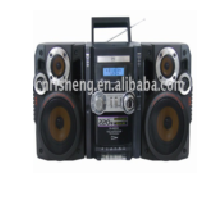

In [0]:
# There are many strange images in this dataset. If this image doesn't make sense to you, change the 10 to any other number between 0 & 13393
show_image(il[10])

In [0]:
import random
# flip the image if random is 0.5 (on average 50% of the times)
def pil_random_flip(x):
    return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random()<0.5 else x

In [0]:
ill = get_il(tfms)

In [0]:
il1 = get_il(tfms)
il1.items = [il1.items[10]]*64
# 8 is bs
dl = DataLoader(il1, 8)

In [0]:
x = next(iter(dl))

##### Flip

In [0]:
# Convenience method to look at images in a batch

def show_image(im, ax=None, figsize=(3,3)):
    if ax is None: _,ax = plt.subplots(1, 1, figsize=figsize)
    ax.axis('off')
    ax.imshow(im.permute(1,2,0))

def show_batch(x, c=4, r=None, figsize=None):
    n = len(x)
    if r is None: r = int(math.ceil(n/c))
    if figsize is None: figsize=(c*3,r*3)
    fig,axes = plt.subplots(r,c, figsize=figsize)
    for xi,ax in zip(x,axes.flat): show_image(xi, ax)

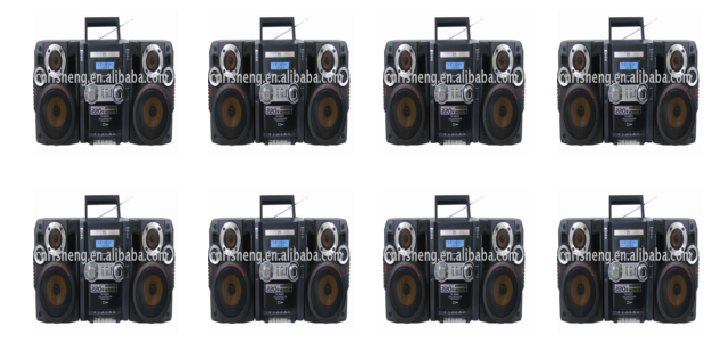

In [0]:
# non transformed images
show_batch(x)

In [0]:
il1.tfms.append(pil_random_flip)

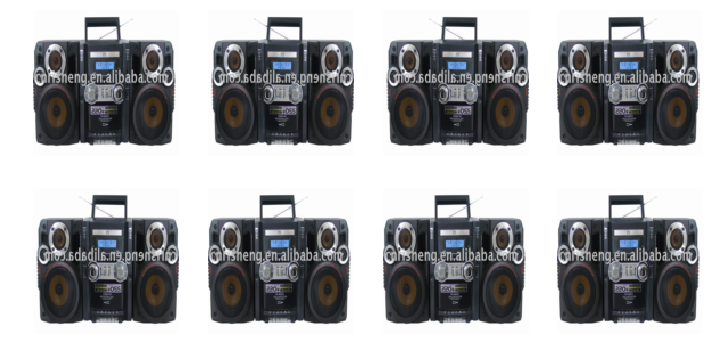

In [0]:
# transformed images. Depending on the image it can be sometimes difficult to notice, If you find it hard to notice, lower the 0.5 in the pil_random_flip method.
x = next(iter(dl))
show_batch(x)

As augmentation can use to generate additional data, we need to think what kind of data makes sense. Do I want my model to learn to recognize upside down houses ? probably not right? because its not going to see it in real life. The left to right augmentation on the other hand, might be a good idea. If I'm building a 3d houses modeling software, maybe I do need upside down houses, this calls for judgement and domain expertise.

In [0]:
# Lets turn this into a class to make modifications of hyperparameters easier

# Other classes will inherit this order to make sure the transfomrations is being done in the right moment
class PilTransform(Transform): _order=11

class PilRandomFlip(PilTransform):
    def __init__(self, p=0.5): self.p=p
    def __call__(self, x):
        return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random()<self.p else x

In [0]:
del(il1.tfms[-1])
il1.tfms.append(PilRandomFlip(0.8))

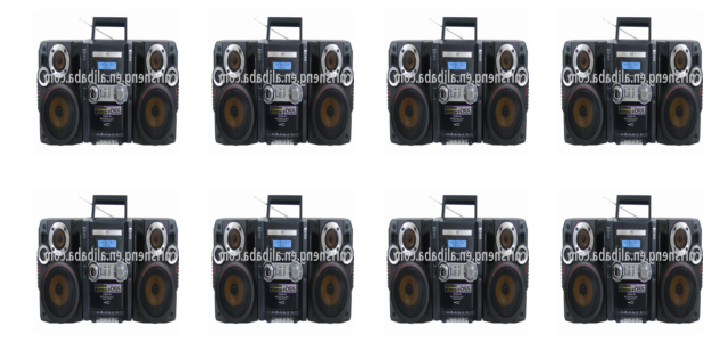

In [0]:
x = next(iter(dl))
show_batch(x)

In [0]:
# Different transfomrations
PIL.Image.FLIP_LEFT_RIGHT,PIL.Image.ROTATE_270,PIL.Image.TRANSVERSE

(0, 4, 6)

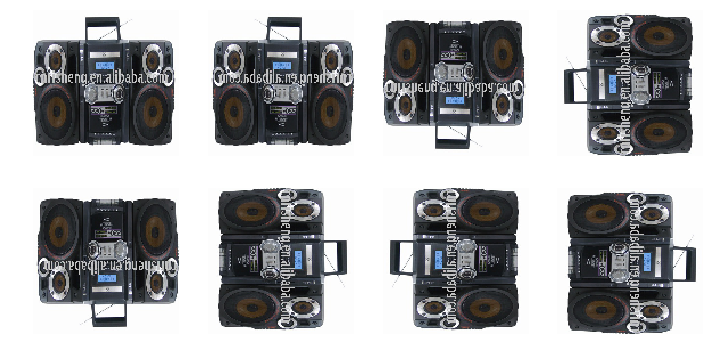

In [0]:
img = PIL.Image.open(il.items[10])
img = img.resize((128,128), resample=PIL.Image.NEAREST)
_, axs = plt.subplots(2, 4, figsize=(12, 6))
for i,ax in enumerate(axs.flatten()):
    if i==0: ax.imshow(img)
    else:    ax.imshow(img.transpose(i-1))
    ax.axis('off')

##### Random Crop

In [0]:
img = PIL.Image.open(il.items[10])
img.size

(500, 305)

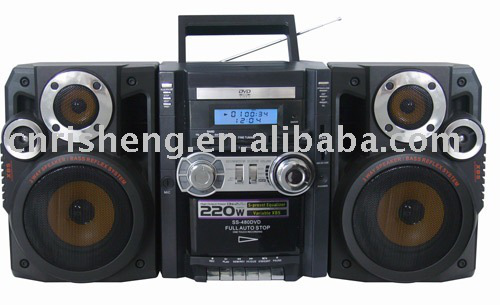

In [0]:
img

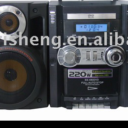

In [0]:
# We specify the location in which we want to crop. Feel free to modify the numbers to see how it changes the cropping
img.crop((60,60,320,320)).resize((128,128), resample=PIL.Image.BILINEAR)

In [0]:
# This process is reasonably fast
cnr2 = (60,60,320,320)
resample = PIL.Image.BILINEAR
%timeit -n 10 img.crop(cnr2).resize((128,128), resample=resample)

10 loops, best of 3: 815 µs per loop


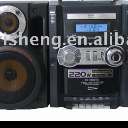

In [0]:
img.transform((128,128), PIL.Image.EXTENT, cnr2, resample=resample)

In [0]:
from random import randint

def process_sz(sz):
    sz = listify(sz)
    return tuple(sz if len(sz)==2 else [sz[0],sz[0]])

def default_crop_size(w,h): return [w,w] if w < h else [h,h]

class GeneralCrop(PilTransform):
    def __init__(self, size, crop_size=None, resample=PIL.Image.BILINEAR): 
        self.resample,self.size = resample,process_sz(size)
        self.crop_size = None if crop_size is None else process_sz(crop_size)
        
    def default_crop_size(self, w,h): return default_crop_size(w,h)

    def __call__(self, x):
        csize = self.default_crop_size(*x.size) if self.crop_size is None else self.crop_size
        return x.transform(self.size, PIL.Image.EXTENT, self.get_corners(*x.size, *csize), resample=self.resample)
    
    def get_corners(self, w, h): return (0,0,w,h)

class CenterCrop(GeneralCrop):
    def __init__(self, size, scale=1.14, resample=PIL.Image.BILINEAR):
        super().__init__(size, resample=resample)
        self.scale = scale
        
    def default_crop_size(self, w,h): return [w/self.scale,h/self.scale]
    
    def get_corners(self, w, h, wc, hc):
        return ((w-wc)//2, (h-hc)//2, (w-wc)//2+wc, (h-hc)//2+hc)

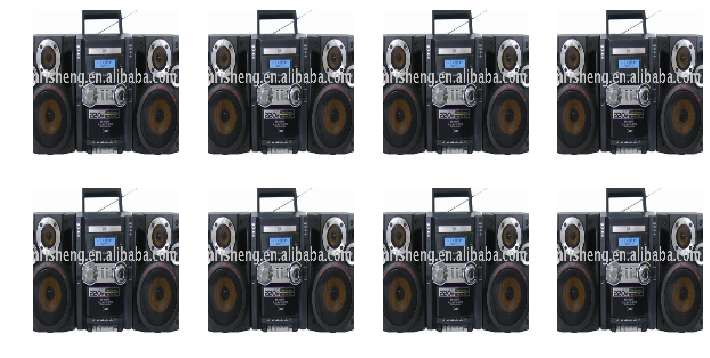

In [0]:
il1.tfms = [make_rgb, CenterCrop(128), to_byte_tensor, to_float_tensor]
show_batch(next(iter(dl)))

In [0]:
class RandomResizedCrop(GeneralCrop):
    def __init__(self, size, scale=(0.08,1.0), ratio=(3./4., 4./3.), resample=PIL.Image.BILINEAR):
        super().__init__(size, resample=resample)
        self.scale,self.ratio = scale,ratio
    
    def get_corners(self, w, h, wc, hc):
        area = w*h
        #Tries 10 times to get a proper crop inside the image.
        for attempt in range(10):
            area = random.uniform(*self.scale) * area
            ratio = math.exp(random.uniform(math.log(self.ratio[0]), math.log(self.ratio[1])))
            new_w = int(round(math.sqrt(area * ratio)))
            new_h = int(round(math.sqrt(area / ratio)))
            if new_w <= w and new_h <= h:
                left = random.randint(0, w - new_w)
                top  = random.randint(0, h - new_h)
                return (left, top, left + new_w, top + new_h)
        
        # Fallback to central crop
        left,top = randint(0,w-self.crop_size[0]),randint(0,h-self.crop_size[1])
        return (left, top, left+self.crop_size[0], top+self.crop_size[1])
        # Fallback to central crop

In [0]:
il1.tfms = [make_rgb, RandomResizedCrop(128), to_byte_tensor, to_float_tensor]


This is the usual data augmentation used on ImageNet (introduced [here](https://arxiv.org/pdf/1409.4842.pdf) that consists of selecting 8 to 100% of the image area and a scale between 3/4 and 4/3 as a crop, then resizing it to the desired size. It combines some zoom and a bit of squishing at a very low computational cost.

This is actually an extremely useful (as proven by competition winners) transformation. Focusing on different parts of the image

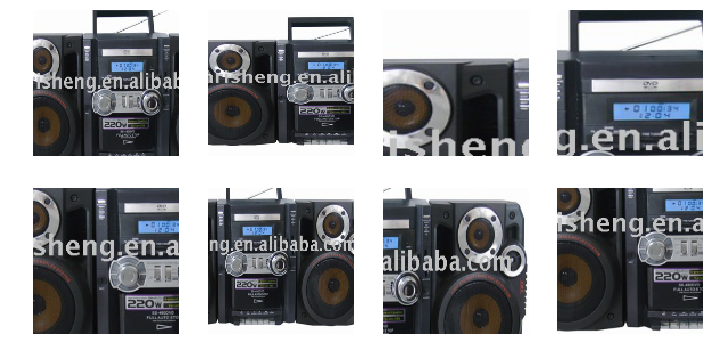

In [0]:
show_batch(next(iter(dl)))

##### Perspective warping

Looking at images from different angles

To do perspective warping, we map the corners of the image to new points: for instance, if we want to tilt the image so that the top looks closer to us, the top/left corner needs to be shifted to the right and the top/right to the left. To avoid squishing, the bottom/left corner needs to be shifted to the left and the bottom/right corner to the right. This obviously requires calculating the right numbers so it looks realistic - this is the [equation](https://web.archive.org/web/20150222120106/xenia.media.mit.edu/~cwren/interpolator/). I will just copy-paste the results so we can understand it better

In [0]:
from torch import FloatTensor,LongTensor

def find_coeffs(orig_pts, targ_pts):
    matrix = []
    #The equations we'll need to solve.
    for p1, p2 in zip(targ_pts, orig_pts):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])

    A = FloatTensor(matrix)
    B = FloatTensor(orig_pts).view(8, 1)
    #The 8 scalars we seek are solution of AX = B
    return list(torch.solve(B,A)[0][:,0])

In [0]:
def warp(img, size, src_coords, resample=PIL.Image.BILINEAR):
    w,h = size
    targ_coords = ((0,0),(0,h),(w,h),(w,0))
    c = find_coeffs(src_coords,targ_coords)
    res = img.transform(size, PIL.Image.PERSPECTIVE, list(c), resample=resample)
    return res

In [0]:
targ = ((0,0),(0,128),(128,128),(128,0))
src  = ((90,60),(30,280),(310,280),(250,60))

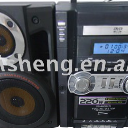

In [0]:
c = find_coeffs(src, targ)
img.transform((128,128), PIL.Image.PERSPECTIVE, list(c), resample=resample)

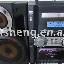

In [0]:
warp(img, (64,64), src, resample=PIL.Image.BICUBIC)

In [0]:
def uniform(a,b): return a + (b-a) * random.random()

In [0]:
class PilTiltRandomCrop(PilTransform):
    def __init__(self, size, crop_size=None, magnitude=0., resample=PIL.Image.BILINEAR): 
        self.resample,self.size,self.magnitude = resample,process_sz(size),magnitude
        self.crop_size = None if crop_size is None else process_sz(crop_size)
        
    def __call__(self, x):
        csize = default_crop_size(*x.size) if self.crop_size is None else self.crop_size
        left,top = randint(0,x.size[0]-csize[0]),randint(0,x.size[1]-csize[1])
        top_magn = min(self.magnitude, left/csize[0], (x.size[0]-left)/csize[0]-1)
        lr_magn  = min(self.magnitude, top /csize[1], (x.size[1]-top) /csize[1]-1)
        up_t,lr_t = uniform(-top_magn, top_magn),uniform(-lr_magn, lr_magn)
        src_corners = tensor([[-up_t, -lr_t], [up_t, 1+lr_t], [1-up_t, 1-lr_t], [1+up_t, lr_t]])
        src_corners = src_corners * tensor(csize).float() + tensor([left,top]).float()
        src_corners = tuple([(int(o[0].item()), int(o[1].item())) for o in src_corners])
        return warp(x, self.size, src_corners, resample=self.resample)

In [0]:
il1.tfms = [make_rgb, PilTiltRandomCrop(128, 200, magnitude=0.2), to_byte_tensor, to_float_tensor]

This is actually a great transformation as looking at something in different angles is quite realistic, it happens in real life as well

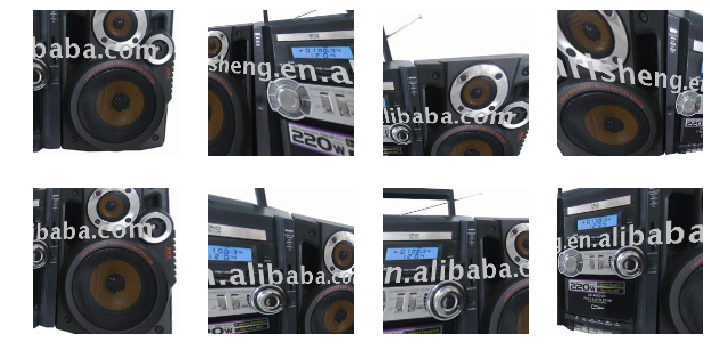

In [0]:
x = next(iter(dl))
show_batch(x)

Jermey introduces new and exciting ways to make augmentation an order of magnitude faster. It's difficult to say I understand it well enough to explain it clearly, and so I will only refer to this great [repo](https://github.com/fastai/course-v3/blob/master/nbs/dl2/10_augmentation.ipynb) for anyone interested in the details

#### Mixup Augmentation

This is a somewhat different kind of data augmentation introduced [here](https://arxiv.org/abs/1710.09412), this is why I put it seperated than the previous augmentations (which are also important of course). Mixup augmentation is combining two images, for example a cat and a shoe, and trying to predict the label accordingly. For example if its a 80% cat and 20% shoe, this is what the model will need to predict

In [0]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [0]:
# We'll start with a few basic augmentations. Making sure/turning into rgb, resizing, turning to a tensor
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs = 64

# Fetching the images
il = ImageList.from_files(path, tfms=tfms)
# Splitting to validation
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

Lets look at mix augmentation. We'll take two images and combine them

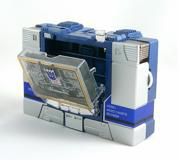

In [0]:
img1 = PIL.Image.open(ll.train.x.items[0])
img1

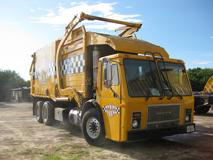

In [0]:
img2 = PIL.Image.open(ll.train.x.items[4000])
img2

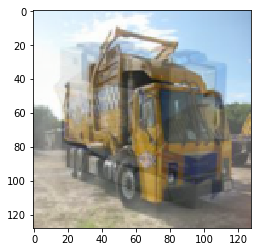

In [0]:
# 30% of image[0] and 70% of images[4000]
mixed_up = ll.train.x[0] * 0.3 + ll.train.x[4000] * 0.7
plt.imshow(mixed_up.permute(1,2,0));

The way we are going to choose the probablity follows a beta distibution (which will be presented very shortly and will be easy to understand). The beta distribution uses the gamma function which is basically a factorial function that interpolates non-integers as well. Let's see this

In [0]:
# If ure using a mac, to write greek symbols you press ctrl+cmd+space, opens the emoji keyboard where you can search for "gamma"
# As pytorch does not have a gamma function, lets create it
Γ = lambda x: x.lgamma().exp()

In [0]:
facts = [math.factorial(i) for i in range(7)]

In [0]:
# Factorial function
facts

[1, 1, 2, 6, 24, 120, 720]

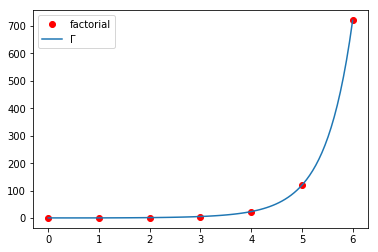

In [0]:
plt.plot(range(7), facts, 'ro')
plt.plot(torch.linspace(0,6), Γ(torch.linspace(0,6)+1))
plt.legend(['factorial', 'Γ'])

The actual distribution function would look like this. We define a parameter α that determines the probablity to get more/less mixed image. if α is high, its more probable to get an image that more of it is mixed

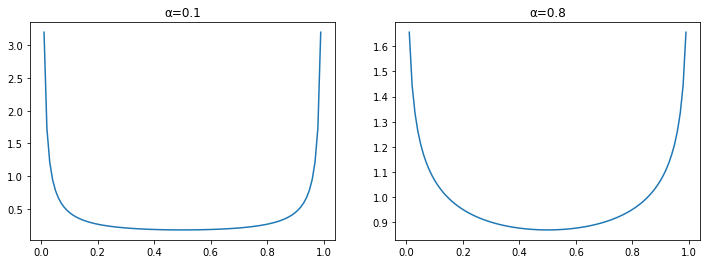

In [0]:
_,axs = plt.subplots(1,2, figsize=(12,4))
x = torch.linspace(0,1, 100)
for α,ax in zip([0.1,0.8], axs):
    α = tensor(α)
#     y = (x.pow(α-1) * (1-x).pow(α-1)) / (gamma_func(α ** 2) / gamma_func(α))
    y = (x**(α-1) * (1-x)**(α-1)) / (Γ(α)**2 / Γ(2*α))
    ax.plot(x,y)
    ax.set_title(f"α={α:.1}")

The origial papper suggests to do a few things:
1. Create two seperate dataloaders and take a batch from each
2. take some t value from a beta distribution with a parameter α
3. Mix the batches with the same t
4. Use one hot-encoded targets

Although this works, we want a bit of a more optimised version. First of all instead of loading 2 different data loaders which is quite slow, we will load one dataloader with a shuffle of itself. Second, if the loss func is crossEntropy we don't really need a one hot encoded vector, we can jsut comute this: loss(output, new_target) = t * loss(output, target1) + (1-t) * loss(output, target2) and do a linear combination. Another change is caclulating two different 't' for every image.
Lastly, as we are taking one dataloader, not two, it could theoretically be very much alike. In case for example we get image0 and image1 with t of 0.9 and then the same images with t of 0.1, we would basically get the same thing twice. The way we handle this is making t = max(t, 1-t). This promises the first (unshuffled) image will have the bigger part of the image, the t won't suddenly become 0.1 for the second image, and we're fine.





Loss functions have something called reduction. For example if we compute the loss over a minibatch, each image has a different loss, so how do we give one loss ? defauling to some calculation, probably mean. The reduce_loss func here will make sure we do the operation we wanted, or none if requested

In [0]:
class NoneReduce():
    def __init__(self, loss_func): 
      # take the loss function and the reduction that has been done.
        self.loss_func,self.old_red = loss_func,None
        
    def __enter__(self):
        if hasattr(self.loss_func, 'reduction'):
            self.old_red = getattr(self.loss_func, 'reduction')
            setattr(self.loss_func, 'reduction', 'none')
            return self.loss_func
        else: return partial(self.loss_func, reduction='none')
        
    def __exit__(self, type, value, traceback):
      # After change, if has been made, put the reduction back
        if self.old_red is not None: setattr(self.loss_func, 'reduction', self.old_red)

In [0]:
from torch.distributions.beta import Beta

def unsqueeze(input, dims):
    for dim in listify(dims): input = torch.unsqueeze(input, dim)
    return input

def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss

In [0]:
def lin_comb(v1, v2, beta): return beta*v1 + (1-beta)*v2

class MixUp(Callback):
     # Runs after normalization and cuda
    _order = 90 
    def __init__(self, α:float=0.4):
      self.distrib = Beta(tensor([α]), tensor([α]))
      
      
    # Keep track of the old loss function as mixup changes the loss funciton, we need to know what it was.
    def begin_fit(self): self.old_loss_func,self.run.loss_func = self.run.loss_func,self.loss_func
    
    def begin_batch(self):
        # Only mixup things during training
        if not self.in_train: return 
        # using the original signs so it resembles the papper. Makes it easier to translate the papper to code
        λ = self.distrib.sample((self.yb.size(0),)).squeeze().to(self.xb.device)
        λ = torch.stack([λ, 1-λ], 1)
        self.λ = unsqueeze(λ.max(1)[0], (1,2,3))
        shuffle = torch.randperm(self.yb.size(0)).to(self.xb.device)
        xb1,self.yb1 = self.xb[shuffle],self.yb[shuffle]
        self.run.xb = lin_comb(self.xb, xb1, self.λ)
        
    def after_fit(self): self.run.loss_func = self.old_loss_func
    
    def loss_func(self, pred, yb):
      # if we're not training, don't change the loss function
        if not self.in_train: return self.old_loss_func(pred, yb)
        # We don't want the mean (or whatevrer operation) reduction loss as we are combining to losses on two images. We actually need each image's loss. Therefor we put this in a
        # context manager where we actually get each image's loss seperately. 
        with NoneReduce(self.old_loss_func) as loss_func:
          # on training, calculate two loss functions. First is on the incoming images, second on the shuffled one
            loss1 = loss_func(pred, yb)
            loss2 = loss_func(pred, self.yb1)
            # lienar combination of the two losses
        loss = lin_comb(loss1, loss2, self.λ)
        # We need that reduction loss, but we need it outside the context manager 
        return reduce_loss(loss, getattr(self.old_loss_func, 'reduction', 'mean'))

In [0]:
nfs = [32,64,128,256,512]

In [0]:
def get_learner(nfs, data, lr, layer, loss_func=F.cross_entropy,
                cb_funcs=None, opt_func=optim.SGD, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return Learner(model, data, loss_func, lr=lr, cb_funcs=cb_funcs, opt_func=opt_func)

In [0]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback, 
        ProgressCallback,
        partial(BatchTransformXCallback, norm_imagenette),
        # Lets add MixUp to our list of Callbacks
        MixUp]

In [0]:
# If in any point you don't understand the parameters being inserted in a function, feel free to ?? it (uncomment example) to see what's being expected
# get_learner??

In [0]:
learn = get_learner(nfs, data, 0.4, conv_layer, cb_funcs=cbfs)

In [0]:
learn.fit(1)

#### Label Smoothing

As we are using a combined image, we need a combined prediction. Softmax isnt going to work too well with this as the exponent of the biggest number will blow up, this is how softmax works. To handle this for our purpose, which could also help with regularization (if we're not sure our labels are accurate for example), what we do is ask the function to give us an almost one hot encoded vector (0.9 encoded, instead of 1 encoded). This lets the other labels to "compete" over 10% of the prediction, which will give some room for the additional correct label to show itself. So the new loss function is this:

$$loss = (1-ε) ce(i) + ε \sum ce(j) / N$$

crossEntropy of i (which is the true label) * 1-ε (so most of the decision) + crossEntropy of everything else devided by n, multiplied by whats left of 1-ε

In [0]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, ε:float=0.1, reduction='mean'):
        super().__init__()
        self.ε,self.reduction = ε,reduction
    
    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        # We add the reduction loss method we introduced so this will work well with MixUp
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return lin_comb(loss/c, nll, self.ε)

In [0]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback,
        ProgressCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [0]:
# Learner with our new modified loss function
learn = get_learner(nfs, data, 0.4, conv_layer, cb_funcs=cbfs, loss_func=LabelSmoothingCrossEntropy())

In [0]:
learn.fit(1)

#### Mixed percision

This part will be more about how python functions than specifically about deep learning, but this could of course use to help training. It goes like this: If you are an up to date Nvidia graphic card you can train about 2-3 times faster. The way you do this is by training parts of the model on 16-bit floats (FP16), and not on 32-bit as we do now. Using FP16 will use half the memory which means we can increase the batch size and get the additional speed. What does this mean, FP16/32 ? explianing this requires a bit of python behind the scences. I will demonstrate with ints as its a bit easier to understand, but its the same idea with floats

Floating points are being represented as base 2 (binary) and not based 10 (as we normally use numbers). Thus, if we save a = 0.3, its not being stored as 0.3, but as the binary representation of 0.3 

In [0]:
# Those looks the same, right ?

a = 0.1 + 0.1
b = 0.2

In [0]:
# They are
a == b

True

In [0]:
# What about this ? 
x = 0.1 + 0.1 + 0.1
y = 0.3

In [0]:
# They arent
x == y

False

The issue is that although python shows us 0.1, it actually stores it somewhat differently. If we look at the representation of 5 numbers after the digit, we see its fine and they match, and we can actually increase this somewhat, but not too much

In [0]:
format(x, '5f')

'0.300000'

In [0]:
format(y, '5f')

'0.300000'

In [0]:
format(x, '5f') == format(y, '5f')

True

In [0]:
# Here we can already see that 0.1 + 0.1 + 0.1 is not really 0.3. The reason is as mentioned, the differnce between the way we think of it (base 10 numbers) and how python stores it
# (base 2 numbers). Seeing what his yields, we understand why the numbers do not match, because behind the scences, its not 0.3
format(x, '.17f')

'0.30000000000000004'

In [0]:
format(x, '.17f') == format(y, '.17f')

False

This is using a 32 bit representation and we see that in some magnitudes of numbers its not accurate. Image what happens for a slight change in the calculation of 100k parameters, going through 40 layers - it wont train well. Thus the concern about degrading to even less percision with 16-bit floats. To sum up - the advantage would be increasing the speed, the disadvantage would be loosing percision. Specifically, this could be problematic in 3 areas:

1. Weight upgrade - as the operation of weights modification goes by computing w = w - lr*w.grad a situation can happen where the gap between w and w.grad, that w.grad could be zeroed and no updating will occur.
2. Gradients are so small they can be zeroed
3. Activation or loss could be so small it also get zeroed.

The solution to this would is doing some of the computations with FP32 where the numbers are bigger and some on FP16 where there is more danger. So the forward pass and gradient computation is being done in FP16 but the update, is being done on FP32. So our training loop changes to:

1. compute the output with the FP16 model, then the loss
2. back-propagate the gradients in half-precision.
3. copy the gradients in FP32 precision (a.k.a mastel model) and divide by scale (explained shortly)
4. do the update on the master model (in FP32 precision)
5. copy the master model in the FP16 model.

As you might notice we are loosing some percision here on stage 5, but, as the next update will be adding 0.0001, and its being done on FP32 it will not be zeroed, and will be calculated and thus it will get big enough for the FP16 to notice its not 0. this takes care of problem number 1. To handle the second issue of gradients being so small they get zeroed, what we do is multiplie them by some scaler, for example 512, and after converting to FP32 we divide back. For handeling the last challenge, which is activation or loss being zeroed, is converting the last layer (that final loss layer) to FP 32 and calculating it on single percision (32FP).
https://devblogs.nvidia.com/wp-content/uploads/2019/01/pasted-image-0-21.png - see this for a better visualization of the moving parts.

This is how its being done theoretically. The machine this is running on does not support this kind of training and so I don't give to the code, it won't work on this machine anyway. Obviously it can be just ran on the cloud, but I tried to make this notebook available for anyone using a GPU (use colab in case you dont have a GPU). If you ARE interested in the implementation details, refer to this repo [https://github.com/fastai/course-v3/blob/master/nbs/dl2/10c_fp16.ipynb] where the nvidia fp16 library is being used.

## XResNet

Xresnet is an improvement model for the famous Resnet model. The main downside of Resnet is the known problem of vanishing gradients. Basically, as activations are often lower then 1, multipliying a fraction many many times, will make it very near zero (0.43^10 = 0.00021611482 for example. Combine that with the floats representation issue we discussed, and its a big problem). Xresnet obviously doesn't fix everything, but it does help using a few tricks

In [0]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [0]:
import numpy as np

def np_to_float(x): return torch.from_numpy(np.array(x, dtype=np.float32, copy=False)).permute(2,0,1).contiguous()/255.
np_to_float._order = 30

In [0]:
size = 128
tfms = [make_rgb, RandomResizedCrop(size, scale=(0.35,1)), np_to_float, PilRandomFlip()]

bs = 64

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

ll.valid.x.tfms = [make_rgb, CenterCrop(size), np_to_float]

data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=8)

In [0]:
# just return x, e.g - do nothing
def noop(x): return x

class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)

def conv(ni, nf, ks=3, stride=1, bias=False):
    return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)

Conv layer here is designed according to the papper, this means it has a few changes then the original resnet. The conv layer is a normal convulutional operation followed by a batchNorm and add an activation function (ReLU by default) unless turned off. There are a few different designs (tricks):

1. Batch norm - in the first 2 layers (or 1 if model < resnet50, resnet < 50 has only two layers in total in this part) batch norm is 1, in the last layer its 0, so it actually zeros everything. In my view this is a pure skip connection as not only it passes the input with no inteference (like a regular skip connection) but it also has the ability to zero everything (and is initialized this way) if it is found useful (and do different things if its not useful). This effectively reduces the numbers of layers, as nothing happens and we can train deeper models with higher lrs (which speeds up training **and** makes generalization better). 

2. Instead of starting with a one layer 7x7 kernel, we actually do a 3 layers 3x3 kernel starting with stride=2. What we get is pretty much the same receptive field with more opportunities to learn. In the identify path, we add 2 extra layers: an AvgPool and a convolutional. We need is because on some cases we want to change the dimensions. Basically we half the grid and double the numbrer of filters. As this changes dimensions we need to adjust them. AvgPool with a stride of 2 will change the number of dimensions as needed and conv 1x1 will change number of filters as needed.

3. Last thing sounds pretty basic but it took time to understnad. If we do a stride=2 on the conv in the first layer (which is done in the original Resnet paper), we loose 3/4 of the data. Moving it to the second stage after the first conv(ks=1, stride=1) which is a ks=3 makes sure we don't loose the data because stride=2 is fine if the filter size is 3x3

In [0]:
act_fn = nn.ReLU(inplace=True)

def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)

      # This will be used as the convulutional layer in the model. Basically just a sequqneitla with some layers, which is a conv,
      # followed by batchnorm, followed by a ReLU (unless turned off)
def conv_layer(ni, nf, ks=3, stride=1, zero_bn=False, act=True):
    bn = nn.BatchNorm2d(nf)
    nn.init.constant_(bn.weight, 0. if zero_bn else 1.)
    layers = [conv(ni, nf, ks, stride=stride), bn]
    if act: layers.append(act_fn)
    return nn.Sequential(*layers)

In [0]:
class ResBlock(nn.Module):
  # expansion deals with the bottle neck issue explained shortly. If its a 18/34 resnet its 1, thus doing nothing. If its bigger (resnet50 and above) its 4
    def __init__(self, expansion, ni, nh, stride=1):
        super().__init__()
        nf,ni = nh*expansion,ni*expansion
        # As explained, this part is 2 layers deep if its a 18/34 resnet (decided according to expansion hypterpamaeter) or 3 if model is resnet50 and above.
        layers  = [conv_layer(ni, nh, 3, stride=stride),
                   conv_layer(nh, nf, 3, zero_bn=True, act=False)
        ] if expansion == 1 else [
                   conv_layer(ni, nh, 1),
                   conv_layer(nh, nh, 3, stride=stride),
                   conv_layer(nh, nf, 1, zero_bn=True, act=False)
        ]
        self.convs = nn.Sequential(*layers)
        # If number of inputs is not the same as number of filters, we add a conv_layer with stride of 1 that changes the filter size. As defined by default
        # bn = 0 is turned off
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False)
        # If stride is not 1, add AvgPooling so it stays the same
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x): return act_fn(self.convs(x) + self.idconv(self.pool(x)))

Instead of building a traditional CNN, we are going to build a model inspried by the [bag of tricks](https://arxiv.org/abs/1812.01187) papper. The stem part of the model, will be an initializing part. Instead of doing a one layer 7x7 kernel stride 2, we will have a 3 layers initialization with a few details:
* in resnet 18/34 its a bit different as it has one conv layer less (only 2). This will detail a resnet 50 and above. 
1. First layer is stride 2, other ones are stride 1.
2. All 3 are 3x3 kernels
3. In Resnet 50 and above, the number of channels get quished by 4, and expanded again. So going from 64 to 16 and expanding back to 64. This is called a bottle neck
4. Last of the 3 has a bn of 0, this basically means everything gets multiplied by 0, 

In [0]:
class XResNet(nn.Sequential):
    @classmethod
    def create(cls, expansion, layers, c_in=3, c_out=1000):
        nfs = [c_in, (c_in+1)*8, 64, 64]
        stem = [conv_layer(nfs[i], nfs[i+1], stride=2 if i==0 else 1)
            for i in range(3)]

        nfs = [64//expansion,64,128,256,512]
        res_layers = [cls._make_layer(expansion, nfs[i], nfs[i+1],
                                      n_blocks=l, stride=1 if i==0 else 2)
                  for i,l in enumerate(layers)]
        res = cls(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *res_layers,
            nn.AdaptiveAvgPool2d(1), Flatten(),
            nn.Linear(nfs[-1]*expansion, c_out),
        )
        init_cnn(res)
        return res
 
    @staticmethod
    def _make_layer(expansion, ni, nf, n_blocks, stride):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
              for i in range(n_blocks)])

In [0]:
# As mentioned, expansion is 1/4 according to the model's size
# second hypterparameter list describes how many resblocks in each laywer. For example, resnet18 has 2 resnete blocks in every layer.
def xresnet18 (**kwargs): return XResNet.create(1, [2, 2,  2, 2], **kwargs)
def xresnet34 (**kwargs): return XResNet.create(1, [3, 4,  6, 3], **kwargs)
def xresnet50 (**kwargs): return XResNet.create(4, [3, 4,  6, 3], **kwargs)
def xresnet101(**kwargs): return XResNet.create(4, [3, 4, 23, 3], **kwargs)
def xresnet152(**kwargs): return XResNet.create(4, [3, 8, 36, 3], **kwargs)

In [0]:
cbfs = [partial(AvgStatsCallback,accuracy), ProgressCallback, CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette),
       ]

In [0]:

loss_func = LabelSmoothingCrossEntropy()
arch = partial(xresnet18, c_out=10)
opt_func = adam_opt(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-2)

In [0]:
def get_batch(dl, learn):
    learn.xb,learn.yb = next(iter(dl))
    learn.do_begin_fit(0)
    learn('begin_batch')
    learn('after_fit')
    return learn.xb,learn.yb

In [0]:
def model_summary(model, data, find_all=False, print_mod=False):
    xb,yb = get_batch(data.valid_dl, learn)
    mods = find_modules(model, is_lin_layer) if find_all else model.children()
    f = lambda hook,mod,inp,out: print(f"====\n{mod}\n" if print_mod else "", out.shape)
    with Hooks(mods, f) as hooks: learn.model(xb)

In [0]:
learn = Learner(arch(), data, loss_func, lr=1, cb_funcs=cbfs, opt_func=opt_func)


As we can see, normally with a convulutional model, we half the image grid size and double the number of filters

In [0]:
learn.model = learn.model.cuda()
# Feel free to change print_mod to True to get additional details on the model
model_summary(learn.model, data, print_mod=False)

 torch.Size([128, 32, 64, 64])
 torch.Size([128, 64, 64, 64])
 torch.Size([128, 64, 64, 64])
 torch.Size([128, 64, 32, 32])
 torch.Size([128, 64, 32, 32])
 torch.Size([128, 128, 16, 16])
 torch.Size([128, 256, 8, 8])
 torch.Size([128, 512, 4, 4])
 torch.Size([128, 512, 1, 1])
 torch.Size([128, 512])
 torch.Size([128, 10])


In [0]:
arch = partial(xresnet34, c_out=10)

In [0]:
learn = Learner(arch(), data, loss_func, lr=1, cb_funcs=cbfs, opt_func=opt_func)

In [0]:
learn.fit(1, cbs=[LR_Find(), Recorder()])

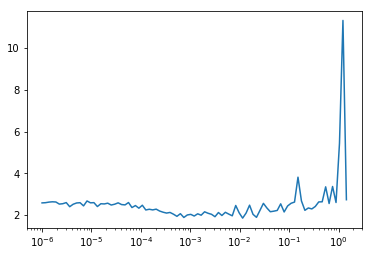

In [0]:
learn.recorder.plot(3)

In [0]:
# Convienience function that divides lr to as many parts as you select + what ever needed to sum to 1
def create_phases(phases):
    phases = listify(phases)
    return phases + [1-sum(phases)]

In [0]:
print(create_phases(0.3))
print(create_phases([0.3,0.2]))

[0.3, 0.7]
[0.3, 0.2, 0.5]


In [0]:
# Convenience function for discriminative learning rates
def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

In [0]:
lr = 1e-2
pct_start = 0.5
phases = create_phases(pct_start)
sched_lr  = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
sched_mom = combine_scheds(phases, cos_1cycle_anneal(0.95, 0.85, 0.95))

In [0]:
cbsched = [
    ParamScheduler('lr', sched_lr),
    ParamScheduler('mom', sched_mom)]

In [0]:
learn = Learner(arch(), data, loss_func, lr=lr, cb_funcs=cbfs, opt_func=opt_func)

In [0]:
# training for a few minutes on 1 10k dataset, this score is pretty good compared to all Jermey's experiments 
%time learn.fit(5)

CPU times: user 3min 30s, sys: 1min 26s, total: 4min 57s
Wall time: 5min 21s


In [0]:
# Lets create a function that just pulls everything together, will make modifications much faster
def cnn_learner(arch, data, loss_func, opt_func, c_in=None, c_out=None,
                lr=1e-2, cuda=True, norm=None, progress=True, mixup=0, xtra_cb=None, **kwargs):
    cbfs = [partial(AvgStatsCallback,accuracy)]+listify(xtra_cb)
    if progress: cbfs.append(ProgressCallback)
    if cuda:     cbfs.append(CudaCallback)
    if norm:     cbfs.append(partial(BatchTransformXCallback, norm))
    if mixup:    cbfs.append(partial(MixUp, mixup))
    arch_args = {}
    if not c_in : c_in  = data.c_in
    if not c_out: c_out = data.c_out
    if c_in:  arch_args['c_in' ]=c_in
    if c_out: arch_args['c_out']=c_out
    return Learner(arch(**arch_args), data, loss_func, opt_func=opt_func, lr=lr, cb_funcs=cbfs, **kwargs)

## Transfer Learning

Transfer learning basically means taking a model that was very well trained (for example on Imagenet dataset) and using it for a different task. Lets use our own self-made model to create our own self-made transfer learning. We are going to train the Pets dataset (10 classes of dogs/cats) with our model. It's not going to be easy as our model has never seen cats, but let's see can what we get out of it.

What we are going to see if that training the model alone, with no pre trained help not going to be too good but then when we add pre trainning, it improves alot.

### Preparing the model

In [0]:
# path = datasets.untar_data(datasets.URLs.IMAGEWOOF_160)
path = datasets.untar_data(datasets.URLs.IMAGEWOOF_160)

In [0]:
size = 128
bs = 64

# All the usual stuff we need
tfms = [make_rgb, RandomResizedCrop(size, scale=(0.35,1)), np_to_float, PilRandomFlip()]
val_tfms = [make_rgb, CenterCrop(size), np_to_float]
il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
ll.valid.x.tfms = val_tfms
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=8)


In [0]:
len(il)

12954

In [0]:
loss_func = LabelSmoothingCrossEntropy()
opt_func = adam_opt(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-2)

In [0]:
# cnn_learner we just made
learn = cnn_learner(xresnet18, data, loss_func, opt_func, norm=norm_imagenette)

In [0]:
# # Instead of writing this over multiplie lines everytime, lets put the same things we had into a function
def sched_1cycle(lr, pct_start=0.3, mom_start=0.95, mom_mid=0.85, mom_end=0.95):
    phases = create_phases(pct_start)
    sched_lr  = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
    sched_mom = combine_scheds(phases, cos_1cycle_anneal(mom_start, mom_mid, mom_end))
    return [ParamScheduler('lr', sched_lr),
            ParamScheduler('mom', sched_mom)]

In [0]:
lr = 3e-3
pct_start = 0.5
# percentage of epochs at the start
cbsched = sched_1cycle(lr, pct_start)

In [0]:
# We trian quite a lot because we need a good model. We get to 83% acc
# learn.fit(40, cbsched) 15 epochs is enough
learn.fit(1, cbsched)

In [0]:
# Let save the mode's state_dict
# st = learn.model.state_dict()
st = learn.model.state_dict()

In [0]:
type(st)

collections.OrderedDict

As we can see a state dict is just the name of all the layers in order

In [0]:
', '.join(st.keys())

'0.0.weight, 0.1.weight, 0.1.bias, 0.1.running_mean, 0.1.running_var, 0.1.num_batches_tracked, 1.0.weight, 1.1.weight, 1.1.bias, 1.1.running_mean, 1.1.running_var, 1.1.num_batches_tracked, 2.0.weight, 2.1.weight, 2.1.bias, 2.1.running_mean, 2.1.running_var, 2.1.num_batches_tracked, 4.0.convs.0.0.weight, 4.0.convs.0.1.weight, 4.0.convs.0.1.bias, 4.0.convs.0.1.running_mean, 4.0.convs.0.1.running_var, 4.0.convs.0.1.num_batches_tracked, 4.0.convs.1.0.weight, 4.0.convs.1.1.weight, 4.0.convs.1.1.bias, 4.0.convs.1.1.running_mean, 4.0.convs.1.1.running_var, 4.0.convs.1.1.num_batches_tracked, 4.1.convs.0.0.weight, 4.1.convs.0.1.weight, 4.1.convs.0.1.bias, 4.1.convs.0.1.running_mean, 4.1.convs.0.1.running_var, 4.1.convs.0.1.num_batches_tracked, 4.1.convs.1.0.weight, 4.1.convs.1.1.weight, 4.1.convs.1.1.bias, 4.1.convs.1.1.running_mean, 4.1.convs.1.1.running_var, 4.1.convs.1.1.num_batches_tracked, 5.0.convs.0.0.weight, 5.0.convs.0.1.weight, 5.0.convs.0.1.bias, 5.0.convs.0.1.running_mean, 5.0.convs

In [0]:
# Show the weights of some random layer I chose
st['10.bias']

tensor([ 0.0091,  0.0068,  0.0010, -0.0021,  0.0004, -0.0069,  0.0054,  0.0015,
        -0.0042, -0.0092], device='cuda:0')

In [0]:
mdl_path = path/'models'
mdl_path.mkdir(exist_ok=True)

In [0]:
# save the model under the name iw5
torch.save(st, mdl_path/'iw5')

In [0]:
pets = datasets.untar_data(datasets.URLs.PETS)

In [0]:
pets.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [0]:
 pets_path = pets/'images'

In [0]:
il = ImageList.from_files(pets_path, tfms=tfms)

In [0]:
il

ImageList (7390 items)
[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/miniature_pinscher_199.jpg'), PosixPath('/root/.fastai/data/oxford-iiit-pet/images/beagle_100.jpg'), PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_31.jpg'), PosixPath('/root/.fastai/data/oxford-iiit-pet/images/german_shorthaired_195.jpg'), PosixPath('/root/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_123.jpg'), PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_160.jpg'), PosixPath('/root/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_57.jpg'), PosixPath('/root/.fastai/data/oxford-iiit-pet/images/great_pyrenees_137.jpg'), PosixPath('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_176.jpg'), PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_67.jpg')...]
Path: /root/.fastai/data/oxford-iiit-pet/images

In [0]:
# We cant use our self-made automatic data splitter has it uses the "gradparent" filename, and this dataset is not stored this way.
# We do however have a split by function class, which we could use, so we just create a function to split by some hyperparameter
def random_splitter(fn, p_valid): return random.random() < p_valid

In [0]:
random.seed(42)

In [0]:
# split 10% of the data to validation
sd = SplitData.split_by_func(il, partial(random_splitter, p_valid=0.1))
sd

SplitData
Train: ImageList (6667 items)
[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/miniature_pinscher_199.jpg'), PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_31.jpg'), PosixPath('/root/.fastai/data/oxford-iiit-pet/images/german_shorthaired_195.jpg'), PosixPath('/root/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_123.jpg'), PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_160.jpg'), PosixPath('/root/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_57.jpg'), PosixPath('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_176.jpg'), PosixPath('/root/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_15.jpg'), PosixPath('/root/.fastai/data/oxford-iiit-pet/images/havanese_182.jpg'), PosixPath('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_170.jpg')...]
Path: /root/.fastai/data/oxford-iiit-pet/images
Valid: ImageList (723 items)
[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/beagle_100.jpg'), Po

In [0]:
# Now lets label it. In this dataset the labels are by name then underscore+number.extension
n = il.items[0].name; n

'miniature_pinscher_199.jpg'

In [0]:
# Lets extract the name by finding everything that comes before an underscore and followed by a digit and .jpg
re.findall(r'^(.*)_\d+.jpg$', n)[0]

'miniature_pinscher'

In [0]:
def pet_labeler(fn): return re.findall(r'^(.*)_\d+.jpg$', fn.name)[0]

In [0]:
proc = CategoryProcessor()

In [0]:
proc

In [0]:
ll = label_by_func(sd, pet_labeler, proc_y=proc)

In [0]:
', '.join(proc.vocab)


'miniature_pinscher, Abyssinian, german_shorthaired, wheaten_terrier, Maine_Coon, american_pit_bull_terrier, american_bulldog, english_cocker_spaniel, havanese, scottish_terrier, keeshond, Sphynx, Bombay, chihuahua, basset_hound, Egyptian_Mau, boxer, yorkshire_terrier, Siamese, pug, Persian, english_setter, leonberger, pomeranian, Birman, Russian_Blue, samoyed, Bengal, shiba_inu, newfoundland, staffordshire_bull_terrier, saint_bernard, great_pyrenees, British_Shorthair, japanese_chin, Ragdoll, beagle'

In [0]:
ll.valid.x.tfms = val_tfms


In [0]:
c_out = len(proc.vocab)

In [0]:
data = ll.to_databunch(bs, c_in=3, c_out=c_out, num_workers=0)

In [0]:
learn = cnn_learner(xresnet18, data, loss_func, opt_func, norm=norm_imagenette)

~40% accuracy with 5 epochs. Let's improve this

In [0]:
learn.fit(5, cbsched)

### Freezing the model
We need 37 classes instead of 10. What we do is store everything up to the AdaptiveAvgPool layer, and from here on we'll do the change. This is a bit tricky, as we need to know what is the size of the input to this layer, so we'll do what does it expect. To do this we'll take a dataloader and create a prediction. We will then see the size of this prediction

In [0]:
# To load the model we will have to ask for a model with 10 activations/cklasses. We will need to change it
# for the pets dataset which only has 10 classes. So this is currently an Imagewolf model (original trained model)
# but the data is for the pets model.
learn = cnn_learner(xresnet18, data, loss_func, opt_func, c_out=10, norm=norm_imagenette)

In [0]:
# Load our model. st will be the pre trained model
st = torch.load(mdl_path/'iw5')

In [0]:
m = learn.model

In [0]:
st.keys()

odict_keys(['0.0.weight', '0.1.weight', '0.1.bias', '0.1.running_mean', '0.1.running_var', '0.1.num_batches_tracked', '1.0.weight', '1.1.weight', '1.1.bias', '1.1.running_mean', '1.1.running_var', '1.1.num_batches_tracked', '2.0.weight', '2.1.weight', '2.1.bias', '2.1.running_mean', '2.1.running_var', '2.1.num_batches_tracked', '4.0.convs.0.0.weight', '4.0.convs.0.1.weight', '4.0.convs.0.1.bias', '4.0.convs.0.1.running_mean', '4.0.convs.0.1.running_var', '4.0.convs.0.1.num_batches_tracked', '4.0.convs.1.0.weight', '4.0.convs.1.1.weight', '4.0.convs.1.1.bias', '4.0.convs.1.1.running_mean', '4.0.convs.1.1.running_var', '4.0.convs.1.1.num_batches_tracked', '4.1.convs.0.0.weight', '4.1.convs.0.1.weight', '4.1.convs.0.1.bias', '4.1.convs.0.1.running_mean', '4.1.convs.0.1.running_var', '4.1.convs.0.1.num_batches_tracked', '4.1.convs.1.0.weight', '4.1.convs.1.1.weight', '4.1.convs.1.1.bias', '4.1.convs.1.1.running_mean', '4.1.convs.1.1.running_var', '4.1.convs.1.1.num_batches_tracked', '5.0.c

In [0]:
m.load_state_dict(st)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
cut = next(i for i,o in enumerate(m.children()) if isinstance(o,nn.AdaptiveAvgPool2d))
m_cut = m[:cut]

In [0]:
xb, yb = get_batch(data.valid_dl, learn)

In [0]:
pred = m_cut(xb)

In [0]:
# As we can see, 512 filters. This is the number of activcations going in, we will change the number going out
pred.shape

torch.Size([128, 512, 4, 4])

In [0]:
ni = pred.shape[1]

In [0]:
# dynamic pooling layer. We use two kinds of pooling here (and concatinating the result), both avg and max. We will therefor need to double the 

class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=1):
        super().__init__()
        self.output_size = sz
        self.ap = nn.AdaptiveAvgPool2d(sz)
        self.mp = nn.AdaptiveMaxPool2d(sz)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

In [0]:
nh = 40

m_new = nn.Sequential(
    m_cut, AdaptiveConcatPool2d(), Flatten(),
    # We need twice as many inputs to keep the expected grid size, because we did 2 poolings
    nn.Linear(ni*2, data.c_out))

In [0]:
learn.model = m_new

And .. its working ! same without pre training we get to 38%, with - 73%. Magic.

In [0]:
learn.fit(5, cbsched)

### Gradual Freezing

To make this work somewhat faster and maybe better, lets use gradual freezing. What we do in gradual freezing is we train different parts of the model in different times. In general the lower level layers would probably fit us just fine even if it was trained on a totally different dataset. The reason is that at first the convuliotnal operations understand very vague and general features. Does it have a tail ? what is the height, how many legs etc. The lower level layers are not about details, but general specifications and so it can fit more datasets. The last layer however, is something we just put there, so we want to train it to be better. Freezing the rest of the model (setting grad's calculation to False) will be good for a number of reasons:
1. Less training = less time
2. As explained the deeper layers are fine, we don't want to modify them with random data.

In [0]:
# Same thing we did exactly, just put in a function
def adapt_model(learn, data):
    cut = next(i for i,o in enumerate(learn.model.children())
               if isinstance(o,nn.AdaptiveAvgPool2d))
    m_cut = learn.model[:cut]
    xb,yb = get_batch(data.valid_dl, learn)
    pred = m_cut(xb)
    ni = pred.shape[1]
    m_new = nn.Sequential(
        m_cut, AdaptiveConcatPool2d(), Flatten(),
        nn.Linear(ni*2, data.c_out))
    learn.model = m_new

In [0]:
# Same as before, just preparing the new model
learn = cnn_learner(xresnet18, data, loss_func, opt_func, c_out=10, norm=norm_imagenette)
learn.model.load_state_dict(torch.load(mdl_path/'iw5'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
adapt_model(learn, data)

In [0]:
# turn off the gradients calculations
for p in learn.model[0].parameters(): p.requires_grad_(False)

In [0]:
# Trained the head of the network
learn.fit(3, sched_1cycle(1e-2, 0.5))

In [0]:
# Now unfreeze the entire model so everything can be trained.
for p in learn.model[0].parameters(): p.requires_grad_(True)

And .. we have a problem. Unfreezing thing ruined our training. It's better than no pre trained model at all, but worse then the best we had. Why is that? Batchnorm of course. Batchnorm is always the blame. 

What actually happens is batchnorm does the normalization according to the data in the imagewolf training. These images now are different and so batchnorm does the wrong normalization. We could say it actually doesn't really normalize. 
The solution we will use here will be seperating the batchnorm layers from the rest, and training everything but the batchnorm.

What happened is we trained the head layers group alone, with its batchnorm and then trained the entire model (with its batchnorm) and so basically the two batch norm stats are different. Training all the batchnorm together, would allow them to match.

In [0]:
learn.fit(5, cbsched, reset_opt=True)

#### Seperating Batchnorm

In [0]:
# prepare the model again

learn = cnn_learner(xresnet18, data, loss_func, opt_func, c_out=10, norm=norm_imagenette)
learn.model.load_state_dict(torch.load(mdl_path/'iw5'))
adapt_model(learn, data)

Lets create a function that goes recursevley through the entire model (apply_mod) and does some function (set_grad) to every layer. What set_grad is doing is checking if the layer is linear followed by a batchnorm - if so, it does nothing. If its not the case, thain modify the gradients (e.g do the training).

In [0]:
def apply_mod(m, f):
    f(m)
    for l in m.children(): apply_mod(l, f)

def set_grad(m, b):
    if isinstance(m, (nn.Linear,nn.BatchNorm2d)): return
    if hasattr(m, 'weight'):
        for p in m.parameters(): p.requires_grad_(b)

In [0]:
# b is what ever modifications we asked for, defaults to false as in case there is nothing, (e.g None), None is Python is false.
apply_mod(learn.model, partial(set_grad, b=False))

In [0]:
learn.fit(3, sched_1cycle(1e-2, 0.5))

In [0]:
apply_mod(learn.model, partial(set_grad, b=True))

And .. it works again !

In [0]:
learn.fit(5, cbsched, reset_opt=True)

In [0]:
learn.model.apply(partial(set_grad, b=False));

### Disctriminative LR 

We are going to give different (distriminative) lrs to different parts of the model. Considering how nonlinear a neural net is, it sounds like a good idea to give it different hyperparameters in different parts of the training. It is actually, a good idea. How do we acheieve this ? we split the model into 2 (or more) layer groups and give it different lrs

In [0]:
learn = cnn_learner(xresnet18, data, loss_func, opt_func, c_out=10, norm=norm_imagenette)

In [0]:
learn.model.load_state_dict(torch.load(mdl_path/'iw5'))
adapt_model(learn, data)

In [0]:
def bn_splitter(m):
    def _bn_splitter(l, g1, g2):
      # if this is a batchnorm, put it in group number 2
        if isinstance(l, nn.BatchNorm2d): g2 += l.parameters()
          # if it doesnt have batchnorm, and it does have weights, put it in layer group 1
        elif hasattr(l, 'weight'): g1 += l.parameters()
        for ll in l.children(): _bn_splitter(ll, g1, g2)
        
    g1,g2 = [],[]
    _bn_splitter(m[0], g1, g2)
    
    # layer group 2 gets the last part fo the model
    g2 += m[1:].parameters()
    return g1,g2

In [0]:
a,b = bn_splitter(learn.model)

Lets see that the two parts of the layer groups sum into the complete model

In [0]:
print(len(a)), print(len(b)), print(len(list(m.parameters())))

22
46
68


(None, None, None)

In [0]:
# passes
test_eq(len(a)+len(b), len(list(m.parameters())))

In [0]:
Learner.ALL_CBS

{'after_backward',
 'after_batch',
 'after_cancel_batch',
 'after_cancel_epoch',
 'after_cancel_train',
 'after_epoch',
 'after_fit',
 'after_loss',
 'after_pred',
 'after_step',
 'begin_batch',
 'begin_epoch',
 'begin_fit',
 'begin_validate'}

Anyone whose done web/mobile development would probably agree debugging DNN is much harder. The reason being that many times we don't get an error, just a bit of a less good model because one part of one layer (out of tens) isn't working perfectlly well. It's hard to debug this. In this case specifically, we won't really know if this is working properly, without adding some functionallity. What we'll do is add a callback that will run over __call__ and call some function in the the callback we choose. This will make things much easier to debug

In [0]:
from types import SimpleNamespace
cb_types = SimpleNamespace(**{o:o for o in Learner.ALL_CBS})

In [0]:
cb_types.after_backward

'after_backward'

The callback runs last (order=999) and if the callback that is being run, fits the name specified, then if theres a requested function it runs it, otherwise it activates the debugger

In [0]:
class DebugCallback(Callback):
    _order = 999
    def __init__(self, cb_name, f=None): self.cb_name,self.f = cb_name,f
    def __call__(self, cb_name):
        if cb_name==self.cb_name:
            if self.f: self.f(self.run)
            else:      set_trace()

This is the function that will allow us to do discriminitve learning. This function will not get a single lr but an array of lrs, and schedule them using combine_scheds. (type combine_scheds?? to see how it works). 

In [0]:
def sched_1cycle(lrs, pct_start=0.3, mom_start=0.95, mom_mid=0.85, mom_end=0.95):
    phases = create_phases(pct_start)
    sched_lr  = [combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
                 for lr in lrs]
    sched_mom = combine_scheds(phases, cos_1cycle_anneal(mom_start, mom_mid, mom_end))
    return [ParamScheduler('lr', sched_lr),
            ParamScheduler('mom', sched_mom)]

In [0]:
# lr = 0 for the first part of the model, 3e-2 for the second. This is the same as only training the head of the model.
disc_lr_sched = sched_1cycle([0,3e-2], 0.5)

In [0]:
learn = cnn_learner(xresnet18, data, loss_func, opt_func,
                    c_out=10, norm=norm_imagenette, splitter=bn_splitter)

learn.model.load_state_dict(torch.load(mdl_path/'iw5'))
adapt_model(learn, data)

As we can see, 2 layer group as we asked, first lr is 0, second lr is 0.03 (we asked for 0.03) but we're using a scheduler for lr so it starts 10 times smaller. This is a debugging technique, to make sure we know whats going on

In [0]:
# Functions that will get run when ever the specified callback will be activated.
def _print_det(o): 
  # print the hyperparameters
    print (len(o.opt.param_groups), o.opt.hypers)
    # stop the training as this is just for debugging
    raise CancelTrainException()

learn.fit(1, disc_lr_sched + [DebugCallback(cb_types.after_batch, _print_det)])

2 [{'mom': 0.9499999999999997, 'mom_sqr': 0.99, 'eps': 1e-06, 'wd': 0.01, 'lr': 0.0, 'sqr_mom': 0.99}, {'mom': 0.9499999999999997, 'mom_sqr': 0.99, 'eps': 1e-06, 'wd': 0.01, 'lr': 0.0030000000000000512, 'sqr_mom': 0.99}]


So lets see a real training (which doesn't cancel out) with lr=0 the first layer at first and then train everything with lr > 0 and see the results

In [0]:
learn.fit(3, disc_lr_sched)

In [0]:
disc_lr_sched = sched_1cycle([1e-3,1e-2], 0.3)

In [0]:
# ~ 69% acc, it works.
learn.fit(5, disc_lr_sched)